In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.math import argmax
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
rng = np.random.default_rng(358)

In [3]:
disc_actions_num = 4

In [4]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [5]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions=1, upper_bound=1, continuous=True, layer1=400, layer2=300, 
              init_weights_min=-0.003, init_weights_max=0.003):
    last_init = tf.random_uniform_initializer(minval=init_weights_min, maxval=init_weights_max)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(disc_actions_num, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    return tf.keras.Model(inputs, outputs)

def get_critic(num_states, num_actions=1, continuous=True, layer1=400, layer2=300):
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    if continuous:
        action_input = layers.Input(shape=(num_actions,))
    else:
        action_input = layers.Input(shape=(disc_actions_num,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(num_actions)(out)
#     if continuous:
#         outputs = layers.Dense(num_actions)(out)
#     else:
#         outputs = layers.Dense(disc_actions_num)(out)

    return tf.keras.Model([state_input, action_input], outputs)

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [6]:
class Agent:
    def __init__(self, num_states, num_actions=1, lower_bound=-1, upper_bound=1, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2, adam_critic_eps=1e-07,
            adam_actor_eps=1e-07, actor_amsgrad=False, critic_amsgrad=False):
        
        self.continuous = continuous
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        if self.continuous:
            self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        else:
            self.action_buffer = np.zeros((self.buffer_capacity, disc_actions_num))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # Also keep track if it is in terminal state (legs on ground)
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        # Epsilon in epsilon-greedy
        self.epsilon = epsilon
        
        self.actor_model = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=256, layer2=256)
        self.critic_model = get_critic(num_states, num_actions, continuous=continuous, layer1=256, layer2=256)
        
        self.target_actor = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=256, layer2=256)
        self.target_critic = get_critic(num_states, num_actions, continuous=continuous, layer1=256, layer2=256)
        
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_actor_eps, amsgrad=actor_amsgrad,
        )
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_critic_eps, amsgrad=critic_amsgrad,
        )
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Calculation of loss and gradients
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping to avoid exploding and vanishing gradients
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-2, clip_value_max=2), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-2, clip_value_max=2), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                return self.actor_model(state)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    action = np.zeros(disc_actions_num)
                    action[np.random.randint(0, disc_actions_num, 1)[0]] = 1
                    return action
                else:
                    return self.actor_model(state)

In [7]:
rng.random()

0.6070693511849563

In [8]:
def fixed(x, episode):
    return x

In [9]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07,
            actor_amsgrad=False, critic_amsgrad=False):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        # Stepcount used for random start
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau, epsilon=epsilon, adam_critic_eps=adam_critic_eps, adam_actor_eps=adam_actor_eps,
                actor_amsgrad=actor_amsgrad, critic_amsgrad=critic_amsgrad)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                if continuous:
                    state, reward, done, info = env.step(action)
                else:
                    state, reward, done, info = env.step(np.argmax(action))
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground.
                terminal_state = int(not (state[6] and state[7]))
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            true_reward_list[trial].append(true_reward)
            
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, 
                          true_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
            environment, total_episodes, 
            buffer_capacity, batch_size, 
            std_dev, critic_lr, actor_lr, 
            gamma, tau, noise_mult, 
            gamma_func.__name__, tau_func.__name__, 
            critic_lr_func.__name__, actor_lr_func.__name__, 
            noise_mult_func.__name__, std_dev_func.__name__, 
            mean_number, use_guide, 
            solved, continuous, 
            start_steps, gravity, 
            enable_wind, wind_power,
            turbulence_power, 
            epsilon, epsilon_func.__name__,
            adam_critic_eps, adam_actor_eps,
            actor_amsgrad, critic_amsgrad,
            timestamp,
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.savefig('Graphs/' + save_name + '.png')
    plt.show()
    
    print('total time:', time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [10]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0, epsilon=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)

            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [11]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [12]:
xax = [x for x in range(-600,250)]

In [13]:
def decreasing_std(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

In [14]:
def decreasing_alr(x, episode):
    return max(0, min(0.001, 0.001 - (x+500)*(0.001/700)))

In [15]:
def decreasing_clr(x, episode):
    return max(0, min(0.002, 0.002 - (x+500)*(0.002/700)))

In [16]:
def decreasing_eps(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

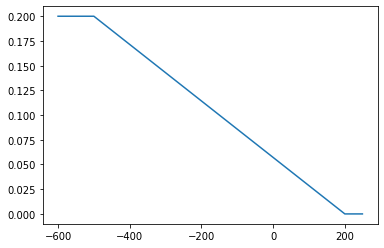

In [17]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,250)])

In [18]:
#run(total_trials=2, total_episodes=2000, buffer_capacity=300000, tau=0.002, critic_lr=0.0003, 
#    actor_lr=0.0002, start_steps=10000, continuous=True)

In [19]:
# run(total_trials=2, total_episodes=3000, buffer_capacity=25000, tau=0.001, critic_lr=0.0002, 
#     actor_lr=0.0001, start_steps=40000, continuous=False, std_dev_func=decreasing_std, actor_lr_func=decreasing_alr,
#     critic_lr_func=decreasing_clr, epsilon_func=decreasing_eps)

In [20]:
# run(total_trials=1, total_episodes=500, buffer_capacity=20000, tau=0.001, critic_lr=0.0002, 
#     actor_lr=0.0001, start_steps=5000, continuous=False, epsilon_func=decreasing_eps, actor_lr_func=decreasing_alr,
#     critic_lr_func=decreasing_clr)

In [21]:
# run(total_trials=1, total_episodes=500, buffer_capacity=20000, tau=0.001, critic_lr=0.0002, 
#     actor_lr=0.0001, start_steps=5000, continuous=False, )

In [22]:
#test(render=True, continuous=False, actor_weights='Weights/actor-trial0_LunarLander-v2_500_20000_64_0.3_0.0002_0.0001_0.99_0.001_1_fixed_fixed_fixed_fixed_fixed_fixed_20_False_200_False_5000_-10.0_False_15.0_1.5_0.2.h5')

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 1.02 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 0.44 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 0.42 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 0.39 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 0.46 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 0.31 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 0.46 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 0.40 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.33 * step 643
Ep 9 

Ep 73 * AvgReward -128.29 * true AvgReward -128.29 * Reward -138.39 * True Reward -138.39 * time 0.53 * step 5187
Ep 74 * AvgReward -127.56 * true AvgReward -127.56 * Reward -119.50 * True Reward -119.50 * time 0.64 * step 5271
Ep 75 * AvgReward -121.49 * true AvgReward -121.49 * Reward -31.14 * True Reward -31.14 * time 0.58 * step 5339
Ep 76 * AvgReward -122.94 * true AvgReward -122.94 * Reward -149.89 * True Reward -149.89 * time 0.50 * step 5406
Ep 77 * AvgReward -123.30 * true AvgReward -123.30 * Reward -140.74 * True Reward -140.74 * time 0.42 * step 5465
Ep 78 * AvgReward -123.87 * true AvgReward -123.87 * Reward -138.59 * True Reward -138.59 * time 0.45 * step 5528
Ep 79 * AvgReward -124.21 * true AvgReward -124.21 * Reward -135.67 * True Reward -135.67 * time 0.67 * step 5606
Ep 80 * AvgReward -117.66 * true AvgReward -117.66 * Reward -15.34 * True Reward -15.34 * time 0.43 * step 5663
Ep 81 * AvgReward -117.93 * true AvgReward -117.93 * Reward -124.36 * True Reward -124.36 * 

Ep 145 * AvgReward -179.43 * true AvgReward -179.43 * Reward -514.26 * True Reward -514.26 * time 0.70 * step 10226
Ep 146 * AvgReward -192.45 * true AvgReward -192.45 * Reward -370.67 * True Reward -370.67 * time 0.94 * step 10338
Ep 147 * AvgReward -215.60 * true AvgReward -215.60 * Reward -590.52 * True Reward -590.52 * time 0.57 * step 10405
Ep 148 * AvgReward -242.32 * true AvgReward -242.32 * Reward -663.41 * True Reward -663.41 * time 1.34 * step 10561
Ep 149 * AvgReward -263.82 * true AvgReward -263.82 * Reward -535.55 * True Reward -535.55 * time 0.57 * step 10629
Ep 150 * AvgReward -274.07 * true AvgReward -274.07 * Reward -358.54 * True Reward -358.54 * time 0.45 * step 10682
Ep 151 * AvgReward -298.37 * true AvgReward -298.37 * Reward -596.11 * True Reward -596.11 * time 0.58 * step 10752
Ep 152 * AvgReward -317.87 * true AvgReward -317.87 * Reward -550.55 * True Reward -550.55 * time 0.58 * step 10821
Ep 153 * AvgReward -332.05 * true AvgReward -332.05 * Reward -413.11 * T

Ep 216 * AvgReward -284.71 * true AvgReward -284.71 * Reward -230.21 * True Reward -230.21 * time 0.69 * step 16685
Ep 217 * AvgReward -282.04 * true AvgReward -282.04 * Reward -283.03 * True Reward -283.03 * time 0.71 * step 16772
Ep 218 * AvgReward -288.60 * true AvgReward -288.60 * Reward -227.10 * True Reward -227.10 * time 0.94 * step 16886
Ep 219 * AvgReward -287.74 * true AvgReward -287.74 * Reward -142.46 * True Reward -142.46 * time 0.55 * step 16955
Ep 220 * AvgReward -287.92 * true AvgReward -287.92 * Reward -175.75 * True Reward -175.75 * time 0.56 * step 17022
Ep 221 * AvgReward -296.51 * true AvgReward -296.51 * Reward -255.79 * True Reward -255.79 * time 0.91 * step 17125
Ep 222 * AvgReward -302.92 * true AvgReward -302.92 * Reward -227.73 * True Reward -227.73 * time 1.15 * step 17243
Ep 223 * AvgReward -302.40 * true AvgReward -302.40 * Reward -306.23 * True Reward -306.23 * time 1.13 * step 17372
Ep 224 * AvgReward -286.08 * true AvgReward -286.08 * Reward -182.28 * T

Ep 287 * AvgReward -272.76 * true AvgReward -272.76 * Reward -336.70 * True Reward -336.70 * time 0.95 * step 23110
Ep 288 * AvgReward -279.61 * true AvgReward -279.61 * Reward -478.67 * True Reward -478.67 * time 1.26 * step 23255
Ep 289 * AvgReward -289.03 * true AvgReward -289.03 * Reward -458.12 * True Reward -458.12 * time 1.28 * step 23402
Ep 290 * AvgReward -301.37 * true AvgReward -301.37 * Reward -468.30 * True Reward -468.30 * time 1.14 * step 23536
Ep 291 * AvgReward -311.27 * true AvgReward -311.27 * Reward -481.17 * True Reward -481.17 * time 1.18 * step 23669
Ep 292 * AvgReward -319.29 * true AvgReward -319.29 * Reward -281.67 * True Reward -281.67 * time 0.97 * step 23780
Ep 293 * AvgReward -327.49 * true AvgReward -327.49 * Reward -378.98 * True Reward -378.98 * time 1.50 * step 23951
Ep 294 * AvgReward -341.69 * true AvgReward -341.69 * Reward -443.58 * True Reward -443.58 * time 1.31 * step 24101
Ep 295 * AvgReward -349.99 * true AvgReward -349.99 * Reward -439.97 * T

Ep 358 * AvgReward -233.13 * true AvgReward -233.13 * Reward -176.17 * True Reward -176.17 * time 1.03 * step 33827
Ep 359 * AvgReward -230.91 * true AvgReward -230.91 * Reward -206.43 * True Reward -206.43 * time 2.84 * step 34150
Ep 360 * AvgReward -228.80 * true AvgReward -228.80 * Reward -225.90 * True Reward -225.90 * time 0.74 * step 34238
Ep 361 * AvgReward -228.05 * true AvgReward -228.05 * Reward -267.14 * True Reward -267.14 * time 0.80 * step 34333
Ep 362 * AvgReward -222.50 * true AvgReward -222.50 * Reward -272.91 * True Reward -272.91 * time 1.84 * step 34550
Ep 363 * AvgReward -223.76 * true AvgReward -223.76 * Reward -229.68 * True Reward -229.68 * time 1.26 * step 34697
Ep 364 * AvgReward -224.40 * true AvgReward -224.40 * Reward -277.00 * True Reward -277.00 * time 1.24 * step 34844
Ep 365 * AvgReward -226.36 * true AvgReward -226.36 * Reward -295.35 * True Reward -295.35 * time 1.20 * step 34983
Ep 366 * AvgReward -231.82 * true AvgReward -231.82 * Reward -377.69 * T

Ep 429 * AvgReward -195.36 * true AvgReward -195.36 * Reward -222.16 * True Reward -222.16 * time 0.89 * step 46288
Ep 430 * AvgReward -184.96 * true AvgReward -184.96 * Reward -273.95 * True Reward -273.95 * time 1.45 * step 46449
Ep 431 * AvgReward -180.27 * true AvgReward -180.27 * Reward -136.61 * True Reward -136.61 * time 2.37 * step 46718
Ep 432 * AvgReward -181.29 * true AvgReward -181.29 * Reward -229.48 * True Reward -229.48 * time 1.61 * step 46899
Ep 433 * AvgReward -184.48 * true AvgReward -184.48 * Reward -160.80 * True Reward -160.80 * time 0.71 * step 46981
Ep 434 * AvgReward -187.60 * true AvgReward -187.60 * Reward -223.84 * True Reward -223.84 * time 1.43 * step 47131
Ep 435 * AvgReward -194.84 * true AvgReward -194.84 * Reward -281.01 * True Reward -281.01 * time 2.59 * step 47424
Ep 436 * AvgReward -196.28 * true AvgReward -196.28 * Reward -208.85 * True Reward -208.85 * time 1.28 * step 47574
Ep 437 * AvgReward -199.02 * true AvgReward -199.02 * Reward -245.25 * T

Ep 500 * AvgReward -189.91 * true AvgReward -189.91 * Reward -234.38 * True Reward -234.38 * time 2.39 * step 65313
Ep 501 * AvgReward -190.42 * true AvgReward -190.42 * Reward -187.92 * True Reward -187.92 * time 2.10 * step 65549
Ep 502 * AvgReward -190.27 * true AvgReward -190.27 * Reward -235.68 * True Reward -235.68 * time 4.28 * step 66022
Ep 503 * AvgReward -196.19 * true AvgReward -196.19 * Reward -225.76 * True Reward -225.76 * time 2.31 * step 66289
Ep 504 * AvgReward -204.55 * true AvgReward -204.55 * Reward -237.95 * True Reward -237.95 * time 2.71 * step 66600
Ep 505 * AvgReward -191.45 * true AvgReward -191.45 * Reward 140.28 * True Reward 140.28 * time 7.09 * step 67313
Ep 506 * AvgReward -191.27 * true AvgReward -191.27 * Reward -157.55 * True Reward -157.55 * time 1.36 * step 67472
Ep 507 * AvgReward -196.22 * true AvgReward -196.22 * Reward -209.78 * True Reward -209.78 * time 2.29 * step 67734
Ep 508 * AvgReward -200.53 * true AvgReward -200.53 * Reward -253.65 * Tru

Ep 571 * AvgReward -163.86 * true AvgReward -163.86 * Reward -257.38 * True Reward -257.38 * time 1.72 * step 88110
Ep 572 * AvgReward -167.17 * true AvgReward -167.17 * Reward -182.36 * True Reward -182.36 * time 1.42 * step 88273
Ep 573 * AvgReward -166.11 * true AvgReward -166.11 * Reward -194.40 * True Reward -194.40 * time 1.32 * step 88422
Ep 574 * AvgReward -167.40 * true AvgReward -167.40 * Reward -197.47 * True Reward -197.47 * time 1.27 * step 88565
Ep 575 * AvgReward -171.43 * true AvgReward -171.43 * Reward -183.92 * True Reward -183.92 * time 3.09 * step 88884
Ep 576 * AvgReward -173.16 * true AvgReward -173.16 * Reward -185.34 * True Reward -185.34 * time 1.33 * step 89025
Ep 577 * AvgReward -175.60 * true AvgReward -175.60 * Reward -187.14 * True Reward -187.14 * time 2.70 * step 89300
Ep 578 * AvgReward -175.41 * true AvgReward -175.41 * Reward -169.20 * True Reward -169.20 * time 2.88 * step 89611
Ep 579 * AvgReward -178.98 * true AvgReward -178.98 * Reward -167.19 * T

Ep 642 * AvgReward -150.16 * true AvgReward -150.16 * Reward -119.10 * True Reward -119.10 * time 9.83 * step 118909
Ep 643 * AvgReward -144.05 * true AvgReward -144.05 * Reward -113.17 * True Reward -113.17 * time 10.11 * step 119909
Ep 644 * AvgReward -140.41 * true AvgReward -140.41 * Reward -138.41 * True Reward -138.41 * time 3.18 * step 120257
Ep 645 * AvgReward -134.12 * true AvgReward -134.12 * Reward -27.97 * True Reward -27.97 * time 9.63 * step 121257
Ep 646 * AvgReward -127.03 * true AvgReward -127.03 * Reward -18.11 * True Reward -18.11 * time 9.60 * step 122257
Ep 647 * AvgReward -120.44 * true AvgReward -120.44 * Reward -52.03 * True Reward -52.03 * time 11.14 * step 123257
Ep 648 * AvgReward -115.33 * true AvgReward -115.33 * Reward -187.64 * True Reward -187.64 * time 7.85 * step 124093
Ep 649 * AvgReward -104.00 * true AvgReward -104.00 * Reward -61.89 * True Reward -61.89 * time 9.64 * step 125093
Ep 650 * AvgReward -103.24 * true AvgReward -103.24 * Reward -64.52 * 

Ep 714 * AvgReward -145.05 * true AvgReward -145.05 * Reward -156.97 * True Reward -156.97 * time 7.94 * step 170170
Ep 715 * AvgReward -142.56 * true AvgReward -142.56 * Reward -136.07 * True Reward -136.07 * time 3.52 * step 170543
Ep 716 * AvgReward -141.95 * true AvgReward -141.95 * Reward -120.36 * True Reward -120.36 * time 7.89 * step 171352
Ep 717 * AvgReward -139.78 * true AvgReward -139.78 * Reward -57.04 * True Reward -57.04 * time 8.45 * step 172191
Ep 718 * AvgReward -132.01 * true AvgReward -132.01 * Reward -59.19 * True Reward -59.19 * time 7.81 * step 172988
Ep 719 * AvgReward -125.87 * true AvgReward -125.87 * Reward -37.56 * True Reward -37.56 * time 1.37 * step 173138
Ep 720 * AvgReward -125.23 * true AvgReward -125.23 * Reward -61.05 * True Reward -61.05 * time 1.03 * step 173254
Ep 721 * AvgReward -126.08 * true AvgReward -126.08 * Reward -111.12 * True Reward -111.12 * time 1.45 * step 173414
Ep 722 * AvgReward -120.33 * true AvgReward -120.33 * Reward -121.45 * T

Ep 785 * AvgReward -80.80 * true AvgReward -80.80 * Reward -7.46 * True Reward -7.46 * time 1.43 * step 179931
Ep 786 * AvgReward -67.11 * true AvgReward -67.11 * Reward -20.33 * True Reward -20.33 * time 0.60 * step 179997
Ep 787 * AvgReward -68.70 * true AvgReward -68.70 * Reward -39.91 * True Reward -39.91 * time 0.89 * step 180093
Ep 788 * AvgReward -59.07 * true AvgReward -59.07 * Reward -49.54 * True Reward -49.54 * time 2.86 * step 180398
Ep 789 * AvgReward -71.25 * true AvgReward -71.25 * Reward -263.35 * True Reward -263.35 * time 2.69 * step 180686
Ep 790 * AvgReward -79.66 * true AvgReward -79.66 * Reward -294.79 * True Reward -294.79 * time 3.68 * step 181072
Ep 791 * AvgReward -87.00 * true AvgReward -87.00 * Reward -213.39 * True Reward -213.39 * time 1.50 * step 181235
Ep 792 * AvgReward -98.56 * true AvgReward -98.56 * Reward -277.16 * True Reward -277.16 * time 1.28 * step 181373
Ep 793 * AvgReward -97.88 * true AvgReward -97.88 * Reward -252.29 * True Reward -252.29 *

Ep 857 * AvgReward -80.52 * true AvgReward -80.52 * Reward -128.38 * True Reward -128.38 * time 1.66 * step 192691
Ep 858 * AvgReward -82.83 * true AvgReward -82.83 * Reward -106.18 * True Reward -106.18 * time 1.18 * step 192817
Ep 859 * AvgReward -89.63 * true AvgReward -89.63 * Reward -209.11 * True Reward -209.11 * time 1.47 * step 192975
Ep 860 * AvgReward -91.69 * true AvgReward -91.69 * Reward -162.22 * True Reward -162.22 * time 1.25 * step 193111
Ep 861 * AvgReward -94.46 * true AvgReward -94.46 * Reward -143.10 * True Reward -143.10 * time 1.37 * step 193256
Ep 862 * AvgReward -98.00 * true AvgReward -98.00 * Reward -101.15 * True Reward -101.15 * time 2.17 * step 193485
Ep 863 * AvgReward -100.64 * true AvgReward -100.64 * Reward -133.54 * True Reward -133.54 * time 2.13 * step 193711
Ep 864 * AvgReward -101.11 * true AvgReward -101.11 * Reward -12.99 * True Reward -12.99 * time 1.11 * step 193831
Ep 865 * AvgReward -98.89 * true AvgReward -98.89 * Reward -18.36 * True Rewar

Ep 929 * AvgReward -148.46 * true AvgReward -148.46 * Reward -278.98 * True Reward -278.98 * time 1.56 * step 200397
Ep 930 * AvgReward -152.20 * true AvgReward -152.20 * Reward -82.00 * True Reward -82.00 * time 0.86 * step 200489
Ep 931 * AvgReward -157.43 * true AvgReward -157.43 * Reward -152.67 * True Reward -152.67 * time 1.45 * step 200644
Ep 932 * AvgReward -160.90 * true AvgReward -160.90 * Reward -182.00 * True Reward -182.00 * time 1.00 * step 200750
Ep 933 * AvgReward -160.82 * true AvgReward -160.82 * Reward -170.12 * True Reward -170.12 * time 2.10 * step 200969
Ep 934 * AvgReward -161.02 * true AvgReward -161.02 * Reward -178.81 * True Reward -178.81 * time 2.36 * step 201207
Ep 935 * AvgReward -156.27 * true AvgReward -156.27 * Reward -145.54 * True Reward -145.54 * time 0.96 * step 201310
Ep 936 * AvgReward -148.80 * true AvgReward -148.80 * Reward -77.32 * True Reward -77.32 * time 4.76 * step 201785
Ep 937 * AvgReward -145.47 * true AvgReward -145.47 * Reward -102.14

Ep 1000 * AvgReward -231.25 * true AvgReward -231.25 * Reward -310.98 * True Reward -310.98 * time 9.19 * step 236565
Ep 1001 * AvgReward -232.36 * true AvgReward -232.36 * Reward -163.66 * True Reward -163.66 * time 3.47 * step 236912
Ep 1002 * AvgReward -237.60 * true AvgReward -237.60 * Reward -254.71 * True Reward -254.71 * time 6.16 * step 237482
Ep 1003 * AvgReward -227.57 * true AvgReward -227.57 * Reward -213.84 * True Reward -213.84 * time 4.42 * step 237921
Ep 1004 * AvgReward -222.64 * true AvgReward -222.64 * Reward -153.19 * True Reward -153.19 * time 1.31 * step 238055
Ep 1005 * AvgReward -212.93 * true AvgReward -212.93 * Reward -134.71 * True Reward -134.71 * time 1.65 * step 238227
Ep 1006 * AvgReward -219.39 * true AvgReward -219.39 * Reward -352.35 * True Reward -352.35 * time 5.65 * step 238769
Ep 1007 * AvgReward -228.23 * true AvgReward -228.23 * Reward -348.10 * True Reward -348.10 * time 9.61 * step 239684
Ep 1008 * AvgReward -225.28 * true AvgReward -225.28 * R

Ep 1070 * AvgReward -134.13 * true AvgReward -134.13 * Reward -25.15 * True Reward -25.15 * time 0.58 * step 266817
Ep 1071 * AvgReward -134.14 * true AvgReward -134.14 * Reward -62.69 * True Reward -62.69 * time 0.55 * step 266875
Ep 1072 * AvgReward -132.94 * true AvgReward -132.94 * Reward -198.13 * True Reward -198.13 * time 3.95 * step 267241
Ep 1073 * AvgReward -138.53 * true AvgReward -138.53 * Reward -122.46 * True Reward -122.46 * time 0.57 * step 267300
Ep 1074 * AvgReward -137.24 * true AvgReward -137.24 * Reward -125.07 * True Reward -125.07 * time 3.72 * step 267666
Ep 1075 * AvgReward -137.49 * true AvgReward -137.49 * Reward -169.97 * True Reward -169.97 * time 2.01 * step 267865
Ep 1076 * AvgReward -130.67 * true AvgReward -130.67 * Reward -35.23 * True Reward -35.23 * time 0.58 * step 267922
Ep 1077 * AvgReward -129.30 * true AvgReward -129.30 * Reward -67.13 * True Reward -67.13 * time 2.65 * step 268185
Ep 1078 * AvgReward -124.81 * true AvgReward -124.81 * Reward -6

Ep 1141 * AvgReward -173.17 * true AvgReward -173.17 * Reward -212.32 * True Reward -212.32 * time 1.58 * step 279271
Ep 1142 * AvgReward -182.51 * true AvgReward -182.51 * Reward -274.21 * True Reward -274.21 * time 2.17 * step 279486
Ep 1143 * AvgReward -190.35 * true AvgReward -190.35 * Reward -232.18 * True Reward -232.18 * time 1.88 * step 279664
Ep 1144 * AvgReward -189.29 * true AvgReward -189.29 * Reward -64.24 * True Reward -64.24 * time 0.66 * step 279728
Ep 1145 * AvgReward -199.02 * true AvgReward -199.02 * Reward -284.79 * True Reward -284.79 * time 2.79 * step 280005
Ep 1146 * AvgReward -208.13 * true AvgReward -208.13 * Reward -252.09 * True Reward -252.09 * time 3.09 * step 280307
Ep 1147 * AvgReward -216.51 * true AvgReward -216.51 * Reward -247.29 * True Reward -247.29 * time 3.44 * step 280640
Ep 1148 * AvgReward -219.45 * true AvgReward -219.45 * Reward -243.42 * True Reward -243.42 * time 10.57 * step 281640
Ep 1149 * AvgReward -220.76 * true AvgReward -220.76 * Re

Ep 1211 * AvgReward -230.39 * true AvgReward -230.39 * Reward -170.80 * True Reward -170.80 * time 1.44 * step 293134
Ep 1212 * AvgReward -234.58 * true AvgReward -234.58 * Reward -185.41 * True Reward -185.41 * time 0.81 * step 293216
Ep 1213 * AvgReward -227.77 * true AvgReward -227.77 * Reward -178.01 * True Reward -178.01 * time 1.00 * step 293314
Ep 1214 * AvgReward -227.33 * true AvgReward -227.33 * Reward -214.29 * True Reward -214.29 * time 2.88 * step 293596
Ep 1215 * AvgReward -211.36 * true AvgReward -211.36 * Reward 22.85 * True Reward 22.85 * time 0.96 * step 293690
Ep 1216 * AvgReward -213.72 * true AvgReward -213.72 * Reward -342.05 * True Reward -342.05 * time 1.00 * step 293789
Ep 1217 * AvgReward -218.34 * true AvgReward -218.34 * Reward -385.97 * True Reward -385.97 * time 0.90 * step 293878
Ep 1218 * AvgReward -231.70 * true AvgReward -231.70 * Reward -317.54 * True Reward -317.54 * time 1.23 * step 293999
Ep 1219 * AvgReward -247.04 * true AvgReward -247.04 * Rewar

Ep 1281 * AvgReward -77.08 * true AvgReward -77.08 * Reward -192.51 * True Reward -192.51 * time 0.80 * step 302774
Ep 1282 * AvgReward -76.71 * true AvgReward -76.71 * Reward -48.34 * True Reward -48.34 * time 1.63 * step 302932
Ep 1283 * AvgReward -55.28 * true AvgReward -55.28 * Reward 221.49 * True Reward 221.49 * time 4.74 * step 303368
Ep 1284 * AvgReward -46.08 * true AvgReward -46.08 * Reward -32.35 * True Reward -32.35 * time 1.13 * step 303478
Ep 1285 * AvgReward -39.88 * true AvgReward -39.88 * Reward 36.64 * True Reward 36.64 * time 2.14 * step 303666
Ep 1286 * AvgReward -32.20 * true AvgReward -32.20 * Reward -56.26 * True Reward -56.26 * time 3.04 * step 303896
Ep 1287 * AvgReward -46.28 * true AvgReward -46.28 * Reward -170.34 * True Reward -170.34 * time 0.73 * step 303964
Ep 1288 * AvgReward -29.36 * true AvgReward -29.36 * Reward 279.68 * True Reward 279.68 * time 4.29 * step 304369
Ep 1289 * AvgReward -38.04 * true AvgReward -38.04 * Reward -188.16 * True Reward -188

Ep 1352 * AvgReward -123.96 * true AvgReward -123.96 * Reward -327.02 * True Reward -327.02 * time 0.83 * step 312461
Ep 1353 * AvgReward -131.11 * true AvgReward -131.11 * Reward -377.05 * True Reward -377.05 * time 1.52 * step 312610
Ep 1354 * AvgReward -145.94 * true AvgReward -145.94 * Reward -314.13 * True Reward -314.13 * time 1.83 * step 312782
Ep 1355 * AvgReward -145.63 * true AvgReward -145.63 * Reward -361.63 * True Reward -361.63 * time 1.57 * step 312935
Ep 1356 * AvgReward -148.92 * true AvgReward -148.92 * Reward -282.87 * True Reward -282.87 * time 1.85 * step 313116
Ep 1357 * AvgReward -148.02 * true AvgReward -148.02 * Reward -119.57 * True Reward -119.57 * time 1.27 * step 313239
Ep 1358 * AvgReward -166.46 * true AvgReward -166.46 * Reward -403.83 * True Reward -403.83 * time 1.35 * step 313370
Ep 1359 * AvgReward -183.06 * true AvgReward -183.06 * Reward -404.85 * True Reward -404.85 * time 1.06 * step 313474
Ep 1360 * AvgReward -190.07 * true AvgReward -190.07 * R

Ep 1423 * AvgReward -7.34 * true AvgReward -7.34 * Reward 202.34 * True Reward 202.34 * time 10.48 * step 324948
Ep 1424 * AvgReward -13.50 * true AvgReward -13.50 * Reward -167.95 * True Reward -167.95 * time 2.85 * step 325219
Ep 1425 * AvgReward -29.39 * true AvgReward -29.39 * Reward -118.50 * True Reward -118.50 * time 4.48 * step 325644
Ep 1426 * AvgReward -39.61 * true AvgReward -39.61 * Reward -33.50 * True Reward -33.50 * time 2.69 * step 325904
Ep 1427 * AvgReward -47.32 * true AvgReward -47.32 * Reward -233.50 * True Reward -233.50 * time 11.04 * step 326898
Ep 1428 * AvgReward -48.74 * true AvgReward -48.74 * Reward -147.52 * True Reward -147.52 * time 5.87 * step 327434
Ep 1429 * AvgReward -48.97 * true AvgReward -48.97 * Reward -154.22 * True Reward -154.22 * time 1.70 * step 327599
Ep 1430 * AvgReward -49.25 * true AvgReward -49.25 * Reward -149.83 * True Reward -149.83 * time 4.98 * step 328054
Ep 1431 * AvgReward -51.75 * true AvgReward -51.75 * Reward -100.40 * True R

Ep 1495 * AvgReward -48.16 * true AvgReward -48.16 * Reward -355.55 * True Reward -355.55 * time 1.47 * step 358951
Ep 1496 * AvgReward -52.09 * true AvgReward -52.09 * Reward -261.07 * True Reward -261.07 * time 2.43 * step 359179
Ep 1497 * AvgReward -53.12 * true AvgReward -53.12 * Reward -124.64 * True Reward -124.64 * time 10.09 * step 360048
Ep 1498 * AvgReward -83.12 * true AvgReward -83.12 * Reward -392.08 * True Reward -392.08 * time 1.59 * step 360198
Ep 1499 * AvgReward -81.23 * true AvgReward -81.23 * Reward -24.62 * True Reward -24.62 * time 11.57 * step 361198
Ep 1500 * AvgReward -97.91 * true AvgReward -97.91 * Reward -310.90 * True Reward -310.90 * time 1.43 * step 361332
Ep 1501 * AvgReward -91.96 * true AvgReward -91.96 * Reward 81.58 * True Reward 81.58 * time 11.56 * step 362332
Ep 1502 * AvgReward -95.90 * true AvgReward -95.90 * Reward -108.01 * True Reward -108.01 * time 12.13 * step 363332
Ep 1503 * AvgReward -95.52 * true AvgReward -95.52 * Reward -78.95 * True 

Ep 1566 * AvgReward -124.04 * true AvgReward -124.04 * Reward -295.10 * True Reward -295.10 * time 7.29 * step 380956
Ep 1567 * AvgReward -130.03 * true AvgReward -130.03 * Reward -200.23 * True Reward -200.23 * time 11.68 * step 381956
Ep 1568 * AvgReward -141.89 * true AvgReward -141.89 * Reward -332.17 * True Reward -332.17 * time 10.24 * step 382863
Ep 1569 * AvgReward -142.63 * true AvgReward -142.63 * Reward -97.70 * True Reward -97.70 * time 1.47 * step 383000
Ep 1570 * AvgReward -153.15 * true AvgReward -153.15 * Reward -277.83 * True Reward -277.83 * time 5.49 * step 383481
Ep 1571 * AvgReward -139.49 * true AvgReward -139.49 * Reward 167.67 * True Reward 167.67 * time 5.34 * step 383952
Ep 1572 * AvgReward -151.61 * true AvgReward -151.61 * Reward -326.77 * True Reward -326.77 * time 4.72 * step 384368
Ep 1573 * AvgReward -159.77 * true AvgReward -159.77 * Reward -300.33 * True Reward -300.33 * time 3.05 * step 384635
Ep 1574 * AvgReward -165.88 * true AvgReward -165.88 * Rew

Ep 1636 * AvgReward -210.76 * true AvgReward -210.76 * Reward -137.45 * True Reward -137.45 * time 11.97 * step 410184
Ep 1637 * AvgReward -209.88 * true AvgReward -209.88 * Reward -165.37 * True Reward -165.37 * time 12.40 * step 411184
Ep 1638 * AvgReward -200.03 * true AvgReward -200.03 * Reward -161.56 * True Reward -161.56 * time 1.26 * step 411296
Ep 1639 * AvgReward -188.48 * true AvgReward -188.48 * Reward -140.68 * True Reward -140.68 * time 12.29 * step 412296
Ep 1640 * AvgReward -190.06 * true AvgReward -190.06 * Reward -241.32 * True Reward -241.32 * time 12.46 * step 413277
Ep 1641 * AvgReward -191.88 * true AvgReward -191.88 * Reward -137.39 * True Reward -137.39 * time 12.44 * step 414277
Ep 1642 * AvgReward -193.72 * true AvgReward -193.72 * Reward -119.10 * True Reward -119.10 * time 12.32 * step 415277
Ep 1643 * AvgReward -196.31 * true AvgReward -196.31 * Reward -127.65 * True Reward -127.65 * time 12.71 * step 416277
Ep 1644 * AvgReward -203.88 * true AvgReward -203

Ep 1706 * AvgReward -113.76 * true AvgReward -113.76 * Reward -70.68 * True Reward -70.68 * time 3.71 * step 452288
Ep 1707 * AvgReward -112.22 * true AvgReward -112.22 * Reward -76.47 * True Reward -76.47 * time 2.90 * step 452534
Ep 1708 * AvgReward -109.60 * true AvgReward -109.60 * Reward -41.03 * True Reward -41.03 * time 2.90 * step 452776
Ep 1709 * AvgReward -113.90 * true AvgReward -113.90 * Reward -123.42 * True Reward -123.42 * time 2.06 * step 452947
Ep 1710 * AvgReward -94.84 * true AvgReward -94.84 * Reward -11.03 * True Reward -11.03 * time 2.67 * step 453172
Ep 1711 * AvgReward -84.06 * true AvgReward -84.06 * Reward -77.74 * True Reward -77.74 * time 5.49 * step 453624
Ep 1712 * AvgReward -90.25 * true AvgReward -90.25 * Reward -207.13 * True Reward -207.13 * time 10.06 * step 454443
Ep 1713 * AvgReward -88.81 * true AvgReward -88.81 * Reward -58.57 * True Reward -58.57 * time 3.66 * step 454746
Ep 1714 * AvgReward -88.34 * true AvgReward -88.34 * Reward -147.47 * True 

Ep 1776 * AvgReward -115.91 * true AvgReward -115.91 * Reward -58.12 * True Reward -58.12 * time 5.71 * step 467326
Ep 1777 * AvgReward -122.47 * true AvgReward -122.47 * Reward -292.99 * True Reward -292.99 * time 1.00 * step 467402
Ep 1778 * AvgReward -120.98 * true AvgReward -120.98 * Reward -24.72 * True Reward -24.72 * time 2.94 * step 467640
Ep 1779 * AvgReward -118.31 * true AvgReward -118.31 * Reward -53.72 * True Reward -53.72 * time 7.07 * step 468206
Ep 1780 * AvgReward -115.31 * true AvgReward -115.31 * Reward -47.91 * True Reward -47.91 * time 4.59 * step 468577
Ep 1781 * AvgReward -121.78 * true AvgReward -121.78 * Reward -244.18 * True Reward -244.18 * time 2.48 * step 468774
Ep 1782 * AvgReward -115.82 * true AvgReward -115.82 * Reward -75.97 * True Reward -75.97 * time 3.39 * step 469042
Ep 1783 * AvgReward -112.73 * true AvgReward -112.73 * Reward -45.46 * True Reward -45.46 * time 2.89 * step 469282
Ep 1784 * AvgReward -111.33 * true AvgReward -111.33 * Reward -42.13

Ep 1846 * AvgReward -203.09 * true AvgReward -203.09 * Reward -219.93 * True Reward -219.93 * time 4.49 * step 513907
Ep 1847 * AvgReward -185.97 * true AvgReward -185.97 * Reward 127.06 * True Reward 127.06 * time 10.13 * step 514633
Ep 1848 * AvgReward -175.80 * true AvgReward -175.80 * Reward -148.84 * True Reward -148.84 * time 2.15 * step 514804
Ep 1849 * AvgReward -166.73 * true AvgReward -166.73 * Reward -94.85 * True Reward -94.85 * time 1.06 * step 514889
Ep 1850 * AvgReward -158.30 * true AvgReward -158.30 * Reward -14.63 * True Reward -14.63 * time 1.23 * step 514987
Ep 1851 * AvgReward -156.42 * true AvgReward -156.42 * Reward -81.59 * True Reward -81.59 * time 0.91 * step 515062
Ep 1852 * AvgReward -160.62 * true AvgReward -160.62 * Reward -270.69 * True Reward -270.69 * time 4.13 * step 515386
Ep 1853 * AvgReward -151.77 * true AvgReward -151.77 * Reward -11.41 * True Reward -11.41 * time 0.97 * step 515463
Ep 1854 * AvgReward -147.27 * true AvgReward -147.27 * Reward 16.

Ep 1918 * AvgReward -91.31 * true AvgReward -91.31 * Reward 36.78 * True Reward 36.78 * time 2.44 * step 523841
Ep 1919 * AvgReward -98.72 * true AvgReward -98.72 * Reward -196.32 * True Reward -196.32 * time 0.67 * step 523892
Ep 1920 * AvgReward -102.74 * true AvgReward -102.74 * Reward -138.94 * True Reward -138.94 * time 1.19 * step 523985
Ep 1921 * AvgReward -110.65 * true AvgReward -110.65 * Reward -217.77 * True Reward -217.77 * time 0.92 * step 524056
Ep 1922 * AvgReward -116.59 * true AvgReward -116.59 * Reward -180.02 * True Reward -180.02 * time 2.43 * step 524242
Ep 1923 * AvgReward -124.70 * true AvgReward -124.70 * Reward -258.48 * True Reward -258.48 * time 2.67 * step 524448
Ep 1924 * AvgReward -130.90 * true AvgReward -130.90 * Reward -117.55 * True Reward -117.55 * time 1.32 * step 524531
Ep 1925 * AvgReward -137.37 * true AvgReward -137.37 * Reward -97.90 * True Reward -97.90 * time 2.11 * step 524694
Ep 1926 * AvgReward -141.65 * true AvgReward -141.65 * Reward -163

Ep 1989 * AvgReward -86.69 * true AvgReward -86.69 * Reward -120.87 * True Reward -120.87 * time 3.18 * step 532887
Ep 1990 * AvgReward -83.88 * true AvgReward -83.88 * Reward -145.94 * True Reward -145.94 * time 2.83 * step 533103
Ep 1991 * AvgReward -86.83 * true AvgReward -86.83 * Reward -33.84 * True Reward -33.84 * time 1.03 * step 533183
Ep 1992 * AvgReward -86.54 * true AvgReward -86.54 * Reward 1.04 * True Reward 1.04 * time 0.87 * step 533250
Ep 1993 * AvgReward -92.28 * true AvgReward -92.28 * Reward -125.95 * True Reward -125.95 * time 0.96 * step 533325
Ep 1994 * AvgReward -90.91 * true AvgReward -90.91 * Reward -138.86 * True Reward -138.86 * time 1.24 * step 533420
Ep 1995 * AvgReward -86.09 * true AvgReward -86.09 * Reward -45.49 * True Reward -45.49 * time 0.70 * step 533474
Ep 1996 * AvgReward -88.43 * true AvgReward -88.43 * Reward -139.69 * True Reward -139.69 * time 3.62 * step 533747
Ep 1997 * AvgReward -89.19 * true AvgReward -89.19 * Reward -43.59 * True Reward -

Ep 2060 * AvgReward -166.88 * true AvgReward -166.88 * Reward -142.11 * True Reward -142.11 * time 3.64 * step 544676
Ep 2061 * AvgReward -177.83 * true AvgReward -177.83 * Reward -469.43 * True Reward -469.43 * time 2.80 * step 544886
Ep 2062 * AvgReward -179.52 * true AvgReward -179.52 * Reward -172.46 * True Reward -172.46 * time 1.85 * step 545028
Ep 2063 * AvgReward -183.28 * true AvgReward -183.28 * Reward -227.73 * True Reward -227.73 * time 1.88 * step 545173
Ep 2064 * AvgReward -183.80 * true AvgReward -183.80 * Reward -261.41 * True Reward -261.41 * time 1.71 * step 545306
Ep 2065 * AvgReward -205.73 * true AvgReward -205.73 * Reward -624.62 * True Reward -624.62 * time 2.87 * step 545525
Ep 2066 * AvgReward -219.67 * true AvgReward -219.67 * Reward -472.76 * True Reward -472.76 * time 1.72 * step 545655
Ep 2067 * AvgReward -230.39 * true AvgReward -230.39 * Reward -209.62 * True Reward -209.62 * time 1.67 * step 545776
Ep 2068 * AvgReward -242.87 * true AvgReward -242.87 * R

Ep 2130 * AvgReward -281.77 * true AvgReward -281.77 * Reward -356.92 * True Reward -356.92 * time 1.01 * step 556905
Ep 2131 * AvgReward -280.98 * true AvgReward -280.98 * Reward -288.03 * True Reward -288.03 * time 6.76 * step 557392
Ep 2132 * AvgReward -270.99 * true AvgReward -270.99 * Reward -282.16 * True Reward -282.16 * time 5.77 * step 557820
Ep 2133 * AvgReward -267.64 * true AvgReward -267.64 * Reward -163.03 * True Reward -163.03 * time 4.46 * step 558155
Ep 2134 * AvgReward -263.58 * true AvgReward -263.58 * Reward -162.78 * True Reward -162.78 * time 5.68 * step 558557
Ep 2135 * AvgReward -264.07 * true AvgReward -264.07 * Reward -263.36 * True Reward -263.36 * time 5.01 * step 558928
Ep 2136 * AvgReward -266.50 * true AvgReward -266.50 * Reward -292.24 * True Reward -292.24 * time 1.46 * step 559037
Ep 2137 * AvgReward -264.88 * true AvgReward -264.88 * Reward -138.57 * True Reward -138.57 * time 5.18 * step 559410
Ep 2138 * AvgReward -263.25 * true AvgReward -263.25 * R

Ep 2200 * AvgReward -178.68 * true AvgReward -178.68 * Reward -238.11 * True Reward -238.11 * time 2.34 * step 595854
Ep 2201 * AvgReward -182.93 * true AvgReward -182.93 * Reward -224.58 * True Reward -224.58 * time 2.62 * step 596036
Ep 2202 * AvgReward -187.79 * true AvgReward -187.79 * Reward -185.52 * True Reward -185.52 * time 3.09 * step 596255
Ep 2203 * AvgReward -188.67 * true AvgReward -188.67 * Reward -171.96 * True Reward -171.96 * time 3.18 * step 596485
Ep 2204 * AvgReward -189.91 * true AvgReward -189.91 * Reward -205.14 * True Reward -205.14 * time 2.17 * step 596643
Ep 2205 * AvgReward -191.02 * true AvgReward -191.02 * Reward -215.91 * True Reward -215.91 * time 2.80 * step 596846
Ep 2206 * AvgReward -190.65 * true AvgReward -190.65 * Reward -158.97 * True Reward -158.97 * time 1.68 * step 596969
Ep 2207 * AvgReward -192.72 * true AvgReward -192.72 * Reward -211.43 * True Reward -211.43 * time 3.63 * step 597230
Ep 2208 * AvgReward -194.46 * true AvgReward -194.46 * R

Ep 2270 * AvgReward -181.90 * true AvgReward -181.90 * Reward -208.63 * True Reward -208.63 * time 9.36 * step 617581
Ep 2271 * AvgReward -174.89 * true AvgReward -174.89 * Reward -122.07 * True Reward -122.07 * time 2.48 * step 617759
Ep 2272 * AvgReward -172.30 * true AvgReward -172.30 * Reward -176.53 * True Reward -176.53 * time 6.03 * step 618167
Ep 2273 * AvgReward -171.52 * true AvgReward -171.52 * Reward -160.51 * True Reward -160.51 * time 7.73 * step 618685
Ep 2274 * AvgReward -171.58 * true AvgReward -171.58 * Reward -202.64 * True Reward -202.64 * time 7.64 * step 619201
Ep 2275 * AvgReward -167.79 * true AvgReward -167.79 * Reward -136.14 * True Reward -136.14 * time 6.61 * step 619666
Ep 2276 * AvgReward -171.80 * true AvgReward -171.80 * Reward -215.39 * True Reward -215.39 * time 9.11 * step 620287
Ep 2277 * AvgReward -173.52 * true AvgReward -173.52 * Reward -149.95 * True Reward -149.95 * time 4.57 * step 620605
Ep 2278 * AvgReward -172.53 * true AvgReward -172.53 * R

Ep 2340 * AvgReward -13.95 * true AvgReward -13.95 * Reward -54.12 * True Reward -54.12 * time 1.86 * step 651837
Ep 2341 * AvgReward -12.83 * true AvgReward -12.83 * Reward -57.79 * True Reward -57.79 * time 1.92 * step 651971
Ep 2342 * AvgReward -8.90 * true AvgReward -8.90 * Reward -53.32 * True Reward -53.32 * time 1.44 * step 652072
Ep 2343 * AvgReward 1.26 * true AvgReward 1.26 * Reward -27.18 * True Reward -27.18 * time 1.35 * step 652166
Ep 2344 * AvgReward 1.50 * true AvgReward 1.50 * Reward 21.09 * True Reward 21.09 * time 1.20 * step 652249
Ep 2345 * AvgReward -3.20 * true AvgReward -3.20 * Reward -69.14 * True Reward -69.14 * time 1.40 * step 652347
Ep 2346 * AvgReward -1.28 * true AvgReward -1.28 * Reward 19.37 * True Reward 19.37 * time 1.36 * step 652442
Ep 2347 * AvgReward -1.91 * true AvgReward -1.91 * Reward 16.02 * True Reward 16.02 * time 1.70 * step 652560
Ep 2348 * AvgReward -4.02 * true AvgReward -4.02 * Reward -18.87 * True Reward -18.87 * time 1.26 * step 65265

Ep 2414 * AvgReward -53.16 * true AvgReward -53.16 * Reward 21.41 * True Reward 21.41 * time 1.70 * step 663114
Ep 2415 * AvgReward -52.56 * true AvgReward -52.56 * Reward -30.58 * True Reward -30.58 * time 1.10 * step 663190
Ep 2416 * AvgReward -52.07 * true AvgReward -52.07 * Reward -33.86 * True Reward -33.86 * time 1.65 * step 663306
Ep 2417 * AvgReward -54.05 * true AvgReward -54.05 * Reward -70.83 * True Reward -70.83 * time 1.37 * step 663400
Ep 2418 * AvgReward -53.91 * true AvgReward -53.91 * Reward -74.91 * True Reward -74.91 * time 1.25 * step 663485
Ep 2419 * AvgReward -51.97 * true AvgReward -51.97 * Reward -58.55 * True Reward -58.55 * time 1.31 * step 663577
Ep 2420 * AvgReward -60.90 * true AvgReward -60.90 * Reward -139.61 * True Reward -139.61 * time 4.27 * step 663868
Ep 2421 * AvgReward -66.66 * true AvgReward -66.66 * Reward -111.32 * True Reward -111.32 * time 5.27 * step 664223
Ep 2422 * AvgReward -64.74 * true AvgReward -64.74 * Reward 27.07 * True Reward 27.07 

Ep 2486 * AvgReward -65.70 * true AvgReward -65.70 * Reward -72.01 * True Reward -72.01 * time 1.66 * step 673692
Ep 2487 * AvgReward -68.76 * true AvgReward -68.76 * Reward -51.43 * True Reward -51.43 * time 1.78 * step 673814
Ep 2488 * AvgReward -75.24 * true AvgReward -75.24 * Reward -211.22 * True Reward -211.22 * time 3.40 * step 674045
Ep 2489 * AvgReward -66.73 * true AvgReward -66.73 * Reward -31.12 * True Reward -31.12 * time 1.36 * step 674139
Ep 2490 * AvgReward -70.26 * true AvgReward -70.26 * Reward -38.31 * True Reward -38.31 * time 1.51 * step 674236
Ep 2491 * AvgReward -67.81 * true AvgReward -67.81 * Reward 5.41 * True Reward 5.41 * time 1.62 * step 674347
Ep 2492 * AvgReward -65.81 * true AvgReward -65.81 * Reward -2.33 * True Reward -2.33 * time 1.55 * step 674453
Ep 2493 * AvgReward -78.04 * true AvgReward -78.04 * Reward -221.71 * True Reward -221.71 * time 3.52 * step 674685
Ep 2494 * AvgReward -80.62 * true AvgReward -80.62 * Reward -223.54 * True Reward -223.54 

Ep 2557 * AvgReward -181.94 * true AvgReward -181.94 * Reward -190.95 * True Reward -190.95 * time 2.67 * step 687510
Ep 2558 * AvgReward -182.45 * true AvgReward -182.45 * Reward -217.49 * True Reward -217.49 * time 3.14 * step 687720
Ep 2559 * AvgReward -187.86 * true AvgReward -187.86 * Reward -312.20 * True Reward -312.20 * time 2.93 * step 687914
Ep 2560 * AvgReward -198.07 * true AvgReward -198.07 * Reward -270.86 * True Reward -270.86 * time 2.50 * step 688082
Ep 2561 * AvgReward -201.68 * true AvgReward -201.68 * Reward -312.32 * True Reward -312.32 * time 2.64 * step 688247
Ep 2562 * AvgReward -206.40 * true AvgReward -206.40 * Reward -304.66 * True Reward -304.66 * time 2.59 * step 688419
Ep 2563 * AvgReward -212.85 * true AvgReward -212.85 * Reward -324.53 * True Reward -324.53 * time 2.50 * step 688578
Ep 2564 * AvgReward -218.58 * true AvgReward -218.58 * Reward -224.56 * True Reward -224.56 * time 2.89 * step 688771
Ep 2565 * AvgReward -223.43 * true AvgReward -223.43 * R

Ep 2627 * AvgReward -250.12 * true AvgReward -250.12 * Reward -123.70 * True Reward -123.70 * time 5.39 * step 702323
Ep 2628 * AvgReward -244.21 * true AvgReward -244.21 * Reward -264.86 * True Reward -264.86 * time 2.16 * step 702468
Ep 2629 * AvgReward -243.54 * true AvgReward -243.54 * Reward -272.39 * True Reward -272.39 * time 2.42 * step 702631
Ep 2630 * AvgReward -253.32 * true AvgReward -253.32 * Reward -305.46 * True Reward -305.46 * time 6.37 * step 703052
Ep 2631 * AvgReward -258.64 * true AvgReward -258.64 * Reward -275.44 * True Reward -275.44 * time 1.85 * step 703174
Ep 2632 * AvgReward -257.91 * true AvgReward -257.91 * Reward -244.04 * True Reward -244.04 * time 2.88 * step 703363
Ep 2633 * AvgReward -258.79 * true AvgReward -258.79 * Reward -299.79 * True Reward -299.79 * time 4.72 * step 703667
Ep 2634 * AvgReward -256.16 * true AvgReward -256.16 * Reward -268.99 * True Reward -268.99 * time 2.12 * step 703808
Ep 2635 * AvgReward -244.07 * true AvgReward -244.07 * R

Ep 2697 * AvgReward -235.89 * true AvgReward -235.89 * Reward -288.87 * True Reward -288.87 * time 7.33 * step 726099
Ep 2698 * AvgReward -246.41 * true AvgReward -246.41 * Reward -335.73 * True Reward -335.73 * time 5.07 * step 726425
Ep 2699 * AvgReward -252.06 * true AvgReward -252.06 * Reward -223.19 * True Reward -223.19 * time 5.58 * step 726776
Ep 2700 * AvgReward -254.54 * true AvgReward -254.54 * Reward -307.72 * True Reward -307.72 * time 7.55 * step 727249
Ep 2701 * AvgReward -266.37 * true AvgReward -266.37 * Reward -344.10 * True Reward -344.10 * time 11.35 * step 727968
Ep 2702 * AvgReward -266.51 * true AvgReward -266.51 * Reward -260.88 * True Reward -260.88 * time 7.14 * step 728418
Ep 2703 * AvgReward -264.40 * true AvgReward -264.40 * Reward -168.25 * True Reward -168.25 * time 1.60 * step 728522
Ep 2704 * AvgReward -269.52 * true AvgReward -269.52 * Reward -455.83 * True Reward -455.83 * time 12.61 * step 729312
Ep 2705 * AvgReward -272.88 * true AvgReward -272.88 *

Ep 2767 * AvgReward -368.49 * true AvgReward -368.49 * Reward -867.73 * True Reward -867.73 * time 6.63 * step 750737
Ep 2768 * AvgReward -334.73 * true AvgReward -334.73 * Reward -53.45 * True Reward -53.45 * time 0.98 * step 750800
Ep 2769 * AvgReward -370.69 * true AvgReward -370.69 * Reward -1196.12 * True Reward -1196.12 * time 6.95 * step 751229
Ep 2770 * AvgReward -366.59 * true AvgReward -366.59 * Reward -76.59 * True Reward -76.59 * time 0.94 * step 751289
Ep 2771 * AvgReward -416.64 * true AvgReward -416.64 * Reward -1057.86 * True Reward -1057.86 * time 6.05 * step 751668
Ep 2772 * AvgReward -418.31 * true AvgReward -418.31 * Reward -85.97 * True Reward -85.97 * time 0.95 * step 751729
Ep 2773 * AvgReward -382.90 * true AvgReward -382.90 * Reward -47.54 * True Reward -47.54 * time 1.01 * step 751795
Ep 2774 * AvgReward -382.43 * true AvgReward -382.43 * Reward -61.50 * True Reward -61.50 * time 1.05 * step 751862
Ep 2775 * AvgReward -370.98 * true AvgReward -370.98 * Reward 

Ep 2837 * AvgReward -250.67 * true AvgReward -250.67 * Reward -702.09 * True Reward -702.09 * time 2.27 * step 760926
Ep 2838 * AvgReward -228.13 * true AvgReward -228.13 * Reward -92.84 * True Reward -92.84 * time 1.52 * step 761022
Ep 2839 * AvgReward -197.98 * true AvgReward -197.98 * Reward -19.75 * True Reward -19.75 * time 1.91 * step 761144
Ep 2840 * AvgReward -195.51 * true AvgReward -195.51 * Reward -40.99 * True Reward -40.99 * time 1.53 * step 761242
Ep 2841 * AvgReward -221.32 * true AvgReward -221.32 * Reward -632.38 * True Reward -632.38 * time 2.31 * step 761382
Ep 2842 * AvgReward -186.72 * true AvgReward -186.72 * Reward 9.68 * True Reward 9.68 * time 2.02 * step 761509
Ep 2843 * AvgReward -218.46 * true AvgReward -218.46 * Reward -614.23 * True Reward -614.23 * time 2.20 * step 761648
Ep 2844 * AvgReward -191.55 * true AvgReward -191.55 * Reward -63.54 * True Reward -63.54 * time 2.69 * step 761818
Ep 2845 * AvgReward -191.66 * true AvgReward -191.66 * Reward -49.33 *

Ep 2908 * AvgReward -145.08 * true AvgReward -145.08 * Reward 5.50 * True Reward 5.50 * time 2.16 * step 769746
Ep 2909 * AvgReward -145.86 * true AvgReward -145.86 * Reward -19.65 * True Reward -19.65 * time 1.78 * step 769857
Ep 2910 * AvgReward -148.17 * true AvgReward -148.17 * Reward -620.82 * True Reward -620.82 * time 1.77 * step 769968
Ep 2911 * AvgReward -146.88 * true AvgReward -146.88 * Reward 31.56 * True Reward 31.56 * time 2.09 * step 770099
Ep 2912 * AvgReward -180.68 * true AvgReward -180.68 * Reward -664.07 * True Reward -664.07 * time 1.63 * step 770201
Ep 2913 * AvgReward -181.25 * true AvgReward -181.25 * Reward -1.38 * True Reward -1.38 * time 2.63 * step 770354
Ep 2914 * AvgReward -181.23 * true AvgReward -181.23 * Reward -13.88 * True Reward -13.88 * time 1.41 * step 770442
Ep 2915 * AvgReward -214.69 * true AvgReward -214.69 * Reward -658.27 * True Reward -658.27 * time 2.68 * step 770609
Ep 2916 * AvgReward -215.22 * true AvgReward -215.22 * Reward 17.24 * True

Ep 2979 * AvgReward -105.93 * true AvgReward -105.93 * Reward 41.55 * True Reward 41.55 * time 1.40 * step 783899
Ep 2980 * AvgReward -112.66 * true AvgReward -112.66 * Reward -104.08 * True Reward -104.08 * time 3.03 * step 784085
Ep 2981 * AvgReward -115.64 * true AvgReward -115.64 * Reward -47.34 * True Reward -47.34 * time 3.50 * step 784298
Ep 2982 * AvgReward -92.67 * true AvgReward -92.67 * Reward 31.97 * True Reward 31.97 * time 1.36 * step 784382
Ep 2983 * AvgReward -95.96 * true AvgReward -95.96 * Reward -70.04 * True Reward -70.04 * time 1.65 * step 784484
Ep 2984 * AvgReward -98.73 * true AvgReward -98.73 * Reward -109.71 * True Reward -109.71 * time 4.35 * step 784743
Ep 2985 * AvgReward -116.19 * true AvgReward -116.19 * Reward -433.41 * True Reward -433.41 * time 3.28 * step 784941
Ep 2986 * AvgReward -101.13 * true AvgReward -101.13 * Reward -0.17 * True Reward -0.17 * time 1.74 * step 785048
Ep 2987 * AvgReward -111.86 * true AvgReward -111.86 * Reward -372.30 * True R

Ep 51 * AvgReward -144.12 * true AvgReward -144.12 * Reward -149.64 * True Reward -149.64 * time 0.79 * step 3579
Ep 52 * AvgReward -147.82 * true AvgReward -147.82 * Reward -194.63 * True Reward -194.63 * time 1.16 * step 3662
Ep 53 * AvgReward -150.75 * true AvgReward -150.75 * Reward -164.26 * True Reward -164.26 * time 1.04 * step 3737
Ep 54 * AvgReward -150.99 * true AvgReward -150.99 * Reward -131.13 * True Reward -131.13 * time 0.99 * step 3808
Ep 55 * AvgReward -150.52 * true AvgReward -150.52 * Reward -117.34 * True Reward -117.34 * time 1.21 * step 3895
Ep 56 * AvgReward -151.39 * true AvgReward -151.39 * Reward -165.95 * True Reward -165.95 * time 1.04 * step 3971
Ep 57 * AvgReward -152.75 * true AvgReward -152.75 * Reward -132.32 * True Reward -132.32 * time 0.85 * step 4031
Ep 58 * AvgReward -151.50 * true AvgReward -151.50 * Reward -149.04 * True Reward -149.04 * time 0.99 * step 4103
Ep 59 * AvgReward -150.85 * true AvgReward -150.85 * Reward -126.46 * True Reward -126.4

Ep 123 * AvgReward -121.85 * true AvgReward -121.85 * Reward -125.91 * True Reward -125.91 * time 1.07 * step 8598
Ep 124 * AvgReward -114.69 * true AvgReward -114.69 * Reward -2.62 * True Reward -2.62 * time 1.04 * step 8673
Ep 125 * AvgReward -116.13 * true AvgReward -116.13 * Reward -155.15 * True Reward -155.15 * time 0.98 * step 8741
Ep 126 * AvgReward -125.56 * true AvgReward -125.56 * Reward -159.44 * True Reward -159.44 * time 1.16 * step 8823
Ep 127 * AvgReward -130.31 * true AvgReward -130.31 * Reward -197.82 * True Reward -197.82 * time 1.10 * step 8899
Ep 128 * AvgReward -131.35 * true AvgReward -131.35 * Reward -154.74 * True Reward -154.74 * time 1.20 * step 8984
Ep 129 * AvgReward -131.51 * true AvgReward -131.51 * Reward -160.46 * True Reward -160.46 * time 0.92 * step 9048
Ep 130 * AvgReward -129.70 * true AvgReward -129.70 * Reward -119.41 * True Reward -119.41 * time 1.28 * step 9137
Ep 131 * AvgReward -125.19 * true AvgReward -125.19 * Reward -31.12 * True Reward -3

Ep 194 * AvgReward -627.40 * true AvgReward -627.40 * Reward -385.24 * True Reward -385.24 * time 0.77 * step 14470
Ep 195 * AvgReward -624.74 * true AvgReward -624.74 * Reward -575.48 * True Reward -575.48 * time 1.39 * step 14558
Ep 196 * AvgReward -644.51 * true AvgReward -644.51 * Reward -754.26 * True Reward -754.26 * time 1.66 * step 14662
Ep 197 * AvgReward -636.94 * true AvgReward -636.94 * Reward -263.88 * True Reward -263.88 * time 1.63 * step 14764
Ep 198 * AvgReward -617.89 * true AvgReward -617.89 * Reward -175.87 * True Reward -175.87 * time 1.79 * step 14866
Ep 199 * AvgReward -596.03 * true AvgReward -596.03 * Reward -104.58 * True Reward -104.58 * time 1.47 * step 14939
Ep 200 * AvgReward -562.84 * true AvgReward -562.84 * Reward -183.64 * True Reward -183.64 * time 1.37 * step 15026
Ep 201 * AvgReward -549.29 * true AvgReward -549.29 * Reward -104.23 * True Reward -104.23 * time 1.58 * step 15125
Ep 202 * AvgReward -438.63 * true AvgReward -438.63 * Reward -167.14 * T

Ep 265 * AvgReward -172.13 * true AvgReward -172.13 * Reward -152.83 * True Reward -152.83 * time 1.11 * step 19847
Ep 266 * AvgReward -178.61 * true AvgReward -178.61 * Reward -256.57 * True Reward -256.57 * time 1.29 * step 19930
Ep 267 * AvgReward -178.71 * true AvgReward -178.71 * Reward -137.64 * True Reward -137.64 * time 0.89 * step 19985
Ep 268 * AvgReward -180.16 * true AvgReward -180.16 * Reward -170.48 * True Reward -170.48 * time 1.16 * step 20060
Ep 269 * AvgReward -177.19 * true AvgReward -177.19 * Reward -98.11 * True Reward -98.11 * time 1.40 * step 20149
Ep 270 * AvgReward -178.41 * true AvgReward -178.41 * Reward -127.70 * True Reward -127.70 * time 1.17 * step 20223
Ep 271 * AvgReward -178.83 * true AvgReward -178.83 * Reward -122.69 * True Reward -122.69 * time 0.85 * step 20278
Ep 272 * AvgReward -179.44 * true AvgReward -179.44 * Reward -156.06 * True Reward -156.06 * time 0.96 * step 20338
Ep 273 * AvgReward -178.81 * true AvgReward -178.81 * Reward -123.42 * Tru

Ep 336 * AvgReward -115.14 * true AvgReward -115.14 * Reward -58.25 * True Reward -58.25 * time 1.53 * step 24824
Ep 337 * AvgReward -112.90 * true AvgReward -112.90 * Reward -110.45 * True Reward -110.45 * time 1.98 * step 24945
Ep 338 * AvgReward -117.40 * true AvgReward -117.40 * Reward -241.56 * True Reward -241.56 * time 1.65 * step 25045
Ep 339 * AvgReward -114.53 * true AvgReward -114.53 * Reward -48.56 * True Reward -48.56 * time 1.16 * step 25119
Ep 340 * AvgReward -108.81 * true AvgReward -108.81 * Reward -41.13 * True Reward -41.13 * time 1.54 * step 25217
Ep 341 * AvgReward -114.00 * true AvgReward -114.00 * Reward -246.76 * True Reward -246.76 * time 2.16 * step 25352
Ep 342 * AvgReward -110.33 * true AvgReward -110.33 * Reward -61.01 * True Reward -61.01 * time 1.40 * step 25440
Ep 343 * AvgReward -115.44 * true AvgReward -115.44 * Reward -234.16 * True Reward -234.16 * time 1.59 * step 25540
Ep 344 * AvgReward -112.68 * true AvgReward -112.68 * Reward -83.38 * True Rewar

Ep 407 * AvgReward -202.21 * true AvgReward -202.21 * Reward -130.20 * True Reward -130.20 * time 1.28 * step 37494
Ep 408 * AvgReward -201.94 * true AvgReward -201.94 * Reward -86.77 * True Reward -86.77 * time 1.88 * step 37611
Ep 409 * AvgReward -202.99 * true AvgReward -202.99 * Reward -202.42 * True Reward -202.42 * time 1.70 * step 37717
Ep 410 * AvgReward -198.69 * true AvgReward -198.69 * Reward 28.84 * True Reward 28.84 * time 1.46 * step 37802
Ep 411 * AvgReward -203.17 * true AvgReward -203.17 * Reward -230.05 * True Reward -230.05 * time 1.65 * step 37905
Ep 412 * AvgReward -196.12 * true AvgReward -196.12 * Reward -33.60 * True Reward -33.60 * time 1.88 * step 38022
Ep 413 * AvgReward -189.31 * true AvgReward -189.31 * Reward -171.01 * True Reward -171.01 * time 1.80 * step 38134
Ep 414 * AvgReward -178.49 * true AvgReward -178.49 * Reward -167.31 * True Reward -167.31 * time 1.88 * step 38251
Ep 415 * AvgReward -181.87 * true AvgReward -181.87 * Reward -280.55 * True Rewa

Ep 479 * AvgReward -99.79 * true AvgReward -99.79 * Reward -106.87 * True Reward -106.87 * time 5.67 * step 49454
Ep 480 * AvgReward -89.05 * true AvgReward -89.05 * Reward 143.10 * True Reward 143.10 * time 9.02 * step 49990
Ep 481 * AvgReward -84.60 * true AvgReward -84.60 * Reward -112.03 * True Reward -112.03 * time 5.33 * step 50313
Ep 482 * AvgReward -79.99 * true AvgReward -79.99 * Reward -110.85 * True Reward -110.85 * time 7.12 * step 50740
Ep 483 * AvgReward -83.41 * true AvgReward -83.41 * Reward -150.38 * True Reward -150.38 * time 6.08 * step 51098
Ep 484 * AvgReward -86.64 * true AvgReward -86.64 * Reward -161.68 * True Reward -161.68 * time 5.22 * step 51413
Ep 485 * AvgReward -89.64 * true AvgReward -89.64 * Reward -192.47 * True Reward -192.47 * time 8.12 * step 51896
Ep 486 * AvgReward -91.39 * true AvgReward -91.39 * Reward -123.13 * True Reward -123.13 * time 4.52 * step 52167
Ep 487 * AvgReward -96.41 * true AvgReward -96.41 * Reward -180.34 * True Reward -180.34 *

Ep 550 * AvgReward -161.11 * true AvgReward -161.11 * Reward -160.48 * True Reward -160.48 * time 2.03 * step 66276
Ep 551 * AvgReward -156.14 * true AvgReward -156.14 * Reward -152.87 * True Reward -152.87 * time 1.59 * step 66375
Ep 552 * AvgReward -155.56 * true AvgReward -155.56 * Reward -237.63 * True Reward -237.63 * time 2.08 * step 66504
Ep 553 * AvgReward -160.51 * true AvgReward -160.51 * Reward -228.90 * True Reward -228.90 * time 2.06 * step 66620
Ep 554 * AvgReward -163.19 * true AvgReward -163.19 * Reward -211.61 * True Reward -211.61 * time 2.34 * step 66759
Ep 555 * AvgReward -165.18 * true AvgReward -165.18 * Reward -148.90 * True Reward -148.90 * time 1.54 * step 66852
Ep 556 * AvgReward -165.46 * true AvgReward -165.46 * Reward -188.20 * True Reward -188.20 * time 1.83 * step 66962
Ep 557 * AvgReward -161.28 * true AvgReward -161.28 * Reward -151.76 * True Reward -151.76 * time 2.25 * step 67101
Ep 558 * AvgReward -169.70 * true AvgReward -169.70 * Reward -264.93 * T

Ep 621 * AvgReward -154.85 * true AvgReward -154.85 * Reward -121.42 * True Reward -121.42 * time 1.24 * step 76362
Ep 622 * AvgReward -159.02 * true AvgReward -159.02 * Reward -290.94 * True Reward -290.94 * time 3.12 * step 76554
Ep 623 * AvgReward -162.07 * true AvgReward -162.07 * Reward -150.96 * True Reward -150.96 * time 1.84 * step 76670
Ep 624 * AvgReward -153.04 * true AvgReward -153.04 * Reward -88.90 * True Reward -88.90 * time 1.78 * step 76780
Ep 625 * AvgReward -159.37 * true AvgReward -159.37 * Reward -232.30 * True Reward -232.30 * time 9.33 * step 77336
Ep 626 * AvgReward -164.65 * true AvgReward -164.65 * Reward -222.02 * True Reward -222.02 * time 3.07 * step 77521
Ep 627 * AvgReward -168.58 * true AvgReward -168.58 * Reward -188.43 * True Reward -188.43 * time 3.45 * step 77732
Ep 628 * AvgReward -173.02 * true AvgReward -173.02 * Reward -212.26 * True Reward -212.26 * time 4.80 * step 78021
Ep 629 * AvgReward -173.95 * true AvgReward -173.95 * Reward -195.53 * Tru

Ep 692 * AvgReward -187.06 * true AvgReward -187.06 * Reward -189.10 * True Reward -189.10 * time 2.19 * step 88104
Ep 693 * AvgReward -188.30 * true AvgReward -188.30 * Reward -206.29 * True Reward -206.29 * time 4.46 * step 88376
Ep 694 * AvgReward -188.34 * true AvgReward -188.34 * Reward -245.87 * True Reward -245.87 * time 3.47 * step 88590
Ep 695 * AvgReward -204.84 * true AvgReward -204.84 * Reward -531.35 * True Reward -531.35 * time 6.36 * step 88974
Ep 696 * AvgReward -202.44 * true AvgReward -202.44 * Reward -176.01 * True Reward -176.01 * time 3.08 * step 89163
Ep 697 * AvgReward -212.14 * true AvgReward -212.14 * Reward -319.76 * True Reward -319.76 * time 3.08 * step 89347
Ep 698 * AvgReward -225.69 * true AvgReward -225.69 * Reward -390.01 * True Reward -390.01 * time 7.67 * step 89805
Ep 699 * AvgReward -231.96 * true AvgReward -231.96 * Reward -273.37 * True Reward -273.37 * time 1.54 * step 89901
Ep 700 * AvgReward -242.77 * true AvgReward -242.77 * Reward -406.94 * T

Ep 763 * AvgReward -306.60 * true AvgReward -306.60 * Reward -343.94 * True Reward -343.94 * time 1.98 * step 97549
Ep 764 * AvgReward -304.02 * true AvgReward -304.02 * Reward -229.40 * True Reward -229.40 * time 1.41 * step 97635
Ep 765 * AvgReward -308.62 * true AvgReward -308.62 * Reward -321.59 * True Reward -321.59 * time 1.64 * step 97735
Ep 766 * AvgReward -308.77 * true AvgReward -308.77 * Reward -277.79 * True Reward -277.79 * time 1.36 * step 97817
Ep 767 * AvgReward -309.67 * true AvgReward -309.67 * Reward -376.10 * True Reward -376.10 * time 1.55 * step 97910
Ep 768 * AvgReward -330.60 * true AvgReward -330.60 * Reward -619.83 * True Reward -619.83 * time 2.97 * step 98089
Ep 769 * AvgReward -327.53 * true AvgReward -327.53 * Reward -242.44 * True Reward -242.44 * time 1.42 * step 98173
Ep 770 * AvgReward -333.87 * true AvgReward -333.87 * Reward -384.02 * True Reward -384.02 * time 1.71 * step 98270
Ep 771 * AvgReward -328.61 * true AvgReward -328.61 * Reward -242.69 * T

Ep 834 * AvgReward -256.34 * true AvgReward -256.34 * Reward -312.54 * True Reward -312.54 * time 1.99 * step 108656
Ep 835 * AvgReward -256.35 * true AvgReward -256.35 * Reward -214.09 * True Reward -214.09 * time 2.91 * step 108830
Ep 836 * AvgReward -256.48 * true AvgReward -256.48 * Reward -227.21 * True Reward -227.21 * time 3.93 * step 109063
Ep 837 * AvgReward -257.62 * true AvgReward -257.62 * Reward -241.62 * True Reward -241.62 * time 4.09 * step 109308
Ep 838 * AvgReward -260.61 * true AvgReward -260.61 * Reward -314.14 * True Reward -314.14 * time 11.09 * step 109874
Ep 839 * AvgReward -262.12 * true AvgReward -262.12 * Reward -279.01 * True Reward -279.01 * time 8.96 * step 110392
Ep 840 * AvgReward -262.43 * true AvgReward -262.43 * Reward -239.68 * True Reward -239.68 * time 4.64 * step 110670
Ep 841 * AvgReward -263.55 * true AvgReward -263.55 * Reward -300.33 * True Reward -300.33 * time 4.35 * step 110928
Ep 842 * AvgReward -266.51 * true AvgReward -266.51 * Reward -3

Ep 905 * AvgReward -279.94 * true AvgReward -279.94 * Reward -273.27 * True Reward -273.27 * time 2.43 * step 120945
Ep 906 * AvgReward -275.42 * true AvgReward -275.42 * Reward -223.99 * True Reward -223.99 * time 2.19 * step 121058
Ep 907 * AvgReward -274.78 * true AvgReward -274.78 * Reward -256.25 * True Reward -256.25 * time 1.80 * step 121165
Ep 908 * AvgReward -277.90 * true AvgReward -277.90 * Reward -337.14 * True Reward -337.14 * time 3.65 * step 121380
Ep 909 * AvgReward -280.73 * true AvgReward -280.73 * Reward -322.22 * True Reward -322.22 * time 3.72 * step 121583
Ep 910 * AvgReward -280.22 * true AvgReward -280.22 * Reward -283.30 * True Reward -283.30 * time 3.12 * step 121748
Ep 911 * AvgReward -282.36 * true AvgReward -282.36 * Reward -317.42 * True Reward -317.42 * time 2.92 * step 121899
Ep 912 * AvgReward -279.67 * true AvgReward -279.67 * Reward -241.73 * True Reward -241.73 * time 3.87 * step 122104
Ep 913 * AvgReward -278.65 * true AvgReward -278.65 * Reward -30

Ep 976 * AvgReward -238.79 * true AvgReward -238.79 * Reward -236.31 * True Reward -236.31 * time 6.36 * step 137648
Ep 977 * AvgReward -236.90 * true AvgReward -236.90 * Reward -226.88 * True Reward -226.88 * time 3.96 * step 137856
Ep 978 * AvgReward -231.27 * true AvgReward -231.27 * Reward -162.65 * True Reward -162.65 * time 2.54 * step 137990
Ep 979 * AvgReward -227.14 * true AvgReward -227.14 * Reward -180.00 * True Reward -180.00 * time 2.22 * step 138107
Ep 980 * AvgReward -227.32 * true AvgReward -227.32 * Reward -255.74 * True Reward -255.74 * time 2.74 * step 138253
Ep 981 * AvgReward -225.86 * true AvgReward -225.86 * Reward -210.30 * True Reward -210.30 * time 4.33 * step 138472
Ep 982 * AvgReward -222.15 * true AvgReward -222.15 * Reward -193.00 * True Reward -193.00 * time 2.31 * step 138594
Ep 983 * AvgReward -220.57 * true AvgReward -220.57 * Reward -247.93 * True Reward -247.93 * time 3.99 * step 138803
Ep 984 * AvgReward -222.89 * true AvgReward -222.89 * Reward -21

Ep 1046 * AvgReward -224.73 * true AvgReward -224.73 * Reward -237.99 * True Reward -237.99 * time 20.50 * step 160063
Ep 1047 * AvgReward -234.48 * true AvgReward -234.48 * Reward -449.71 * True Reward -449.71 * time 14.30 * step 160774
Ep 1048 * AvgReward -244.11 * true AvgReward -244.11 * Reward -414.61 * True Reward -414.61 * time 10.53 * step 161297
Ep 1049 * AvgReward -243.24 * true AvgReward -243.24 * Reward -148.67 * True Reward -148.67 * time 8.04 * step 161701
Ep 1050 * AvgReward -242.71 * true AvgReward -242.71 * Reward -229.74 * True Reward -229.74 * time 3.75 * step 161894
Ep 1051 * AvgReward -244.63 * true AvgReward -244.63 * Reward -262.38 * True Reward -262.38 * time 20.55 * step 162894
Ep 1052 * AvgReward -244.57 * true AvgReward -244.57 * Reward -214.83 * True Reward -214.83 * time 20.48 * step 163894
Ep 1053 * AvgReward -249.65 * true AvgReward -249.65 * Reward -303.81 * True Reward -303.81 * time 20.68 * step 164894
Ep 1054 * AvgReward -262.77 * true AvgReward -262.

Ep 1116 * AvgReward -204.06 * true AvgReward -204.06 * Reward -185.91 * True Reward -185.91 * time 1.92 * step 187323
Ep 1117 * AvgReward -210.36 * true AvgReward -210.36 * Reward -312.26 * True Reward -312.26 * time 1.42 * step 187395
Ep 1118 * AvgReward -211.93 * true AvgReward -211.93 * Reward -147.63 * True Reward -147.63 * time 1.12 * step 187453
Ep 1119 * AvgReward -209.83 * true AvgReward -209.83 * Reward -171.93 * True Reward -171.93 * time 1.36 * step 187522
Ep 1120 * AvgReward -214.08 * true AvgReward -214.08 * Reward -272.44 * True Reward -272.44 * time 1.48 * step 187597
Ep 1121 * AvgReward -227.02 * true AvgReward -227.02 * Reward -215.81 * True Reward -215.81 * time 1.46 * step 187673
Ep 1122 * AvgReward -229.87 * true AvgReward -229.87 * Reward -258.61 * True Reward -258.61 * time 1.49 * step 187750
Ep 1123 * AvgReward -230.76 * true AvgReward -230.76 * Reward -120.47 * True Reward -120.47 * time 1.22 * step 187811
Ep 1124 * AvgReward -228.25 * true AvgReward -228.25 * R

Ep 1186 * AvgReward -310.30 * true AvgReward -310.30 * Reward -51.52 * True Reward -51.52 * time 1.80 * step 196981
Ep 1187 * AvgReward -296.15 * true AvgReward -296.15 * Reward 174.75 * True Reward 174.75 * time 4.82 * step 197219
Ep 1188 * AvgReward -297.79 * true AvgReward -297.79 * Reward -117.77 * True Reward -117.77 * time 2.18 * step 197330
Ep 1189 * AvgReward -294.93 * true AvgReward -294.93 * Reward -95.47 * True Reward -95.47 * time 1.92 * step 197428
Ep 1190 * AvgReward -297.23 * true AvgReward -297.23 * Reward -157.21 * True Reward -157.21 * time 2.93 * step 197576
Ep 1191 * AvgReward -335.45 * true AvgReward -335.45 * Reward -897.68 * True Reward -897.68 * time 4.35 * step 197797
Ep 1192 * AvgReward -334.56 * true AvgReward -334.56 * Reward -84.12 * True Reward -84.12 * time 1.93 * step 197895
Ep 1193 * AvgReward -405.85 * true AvgReward -405.85 * Reward -1568.22 * True Reward -1568.22 * time 6.31 * step 198212
Ep 1194 * AvgReward -407.52 * true AvgReward -407.52 * Reward 

Ep 1256 * AvgReward -309.42 * true AvgReward -309.42 * Reward -346.89 * True Reward -346.89 * time 2.05 * step 224033
Ep 1257 * AvgReward -315.48 * true AvgReward -315.48 * Reward -406.50 * True Reward -406.50 * time 1.54 * step 224112
Ep 1258 * AvgReward -323.87 * true AvgReward -323.87 * Reward -498.79 * True Reward -498.79 * time 2.39 * step 224233
Ep 1259 * AvgReward -330.98 * true AvgReward -330.98 * Reward -391.92 * True Reward -391.92 * time 2.54 * step 224360
Ep 1260 * AvgReward -332.92 * true AvgReward -332.92 * Reward -276.03 * True Reward -276.03 * time 2.19 * step 224446
Ep 1261 * AvgReward -330.85 * true AvgReward -330.85 * Reward -244.46 * True Reward -244.46 * time 2.57 * step 224554
Ep 1262 * AvgReward -329.59 * true AvgReward -329.59 * Reward -346.56 * True Reward -346.56 * time 2.53 * step 224676
Ep 1263 * AvgReward -328.93 * true AvgReward -328.93 * Reward -307.01 * True Reward -307.01 * time 2.36 * step 224795
Ep 1264 * AvgReward -327.88 * true AvgReward -327.88 * R

Ep 1326 * AvgReward -588.77 * true AvgReward -588.77 * Reward -674.48 * True Reward -674.48 * time 3.76 * step 243507
Ep 1327 * AvgReward -591.19 * true AvgReward -591.19 * Reward -578.99 * True Reward -578.99 * time 1.64 * step 243589
Ep 1328 * AvgReward -597.64 * true AvgReward -597.64 * Reward -679.37 * True Reward -679.37 * time 2.19 * step 243697
Ep 1329 * AvgReward -600.08 * true AvgReward -600.08 * Reward -577.03 * True Reward -577.03 * time 1.52 * step 243772
Ep 1330 * AvgReward -606.39 * true AvgReward -606.39 * Reward -659.40 * True Reward -659.40 * time 2.22 * step 243881
Ep 1331 * AvgReward -609.75 * true AvgReward -609.75 * Reward -606.33 * True Reward -606.33 * time 1.35 * step 243947
Ep 1332 * AvgReward -607.25 * true AvgReward -607.25 * Reward -529.83 * True Reward -529.83 * time 1.59 * step 244026
Ep 1333 * AvgReward -615.87 * true AvgReward -615.87 * Reward -681.05 * True Reward -681.05 * time 1.95 * step 244123
Ep 1334 * AvgReward -619.65 * true AvgReward -619.65 * R

Ep 1396 * AvgReward -607.24 * true AvgReward -607.24 * Reward -596.69 * True Reward -596.69 * time 1.59 * step 249723
Ep 1397 * AvgReward -609.06 * true AvgReward -609.06 * Reward -669.31 * True Reward -669.31 * time 1.81 * step 249804
Ep 1398 * AvgReward -602.76 * true AvgReward -602.76 * Reward -465.06 * True Reward -465.06 * time 1.74 * step 249889
Ep 1399 * AvgReward -604.11 * true AvgReward -604.11 * Reward -575.11 * True Reward -575.11 * time 2.35 * step 250006
Ep 1400 * AvgReward -608.02 * true AvgReward -608.02 * Reward -687.98 * True Reward -687.98 * time 2.14 * step 250113
Ep 1401 * AvgReward -613.25 * true AvgReward -613.25 * Reward -673.07 * True Reward -673.07 * time 1.75 * step 250199
Ep 1402 * AvgReward -579.28 * true AvgReward -579.28 * Reward -303.66 * True Reward -303.66 * time 1.90 * step 250293
Ep 1403 * AvgReward -580.71 * true AvgReward -580.71 * Reward -684.56 * True Reward -684.56 * time 2.47 * step 250416
Ep 1404 * AvgReward -585.57 * true AvgReward -585.57 * R

Ep 1466 * AvgReward -599.29 * true AvgReward -599.29 * Reward -485.11 * True Reward -485.11 * time 2.20 * step 257270
Ep 1467 * AvgReward -584.90 * true AvgReward -584.90 * Reward -565.16 * True Reward -565.16 * time 1.43 * step 257341
Ep 1468 * AvgReward -593.26 * true AvgReward -593.26 * Reward -769.36 * True Reward -769.36 * time 4.11 * step 257540
Ep 1469 * AvgReward -586.86 * true AvgReward -586.86 * Reward -573.37 * True Reward -573.37 * time 2.60 * step 257668
Ep 1470 * AvgReward -602.41 * true AvgReward -602.41 * Reward -553.51 * True Reward -553.51 * time 3.22 * step 257827
Ep 1471 * AvgReward -601.76 * true AvgReward -601.76 * Reward -470.02 * True Reward -470.02 * time 2.32 * step 257936
Ep 1472 * AvgReward -582.73 * true AvgReward -582.73 * Reward -387.41 * True Reward -387.41 * time 1.82 * step 258025
Ep 1473 * AvgReward -577.22 * true AvgReward -577.22 * Reward -471.34 * True Reward -471.34 * time 2.38 * step 258142
Ep 1474 * AvgReward -562.73 * true AvgReward -562.73 * R

Ep 1536 * AvgReward -315.18 * true AvgReward -315.18 * Reward -413.36 * True Reward -413.36 * time 3.64 * step 272614
Ep 1537 * AvgReward -310.51 * true AvgReward -310.51 * Reward -241.41 * True Reward -241.41 * time 1.72 * step 272698
Ep 1538 * AvgReward -314.87 * true AvgReward -314.87 * Reward -363.03 * True Reward -363.03 * time 2.51 * step 272822
Ep 1539 * AvgReward -319.59 * true AvgReward -319.59 * Reward -397.74 * True Reward -397.74 * time 2.91 * step 272963
Ep 1540 * AvgReward -325.47 * true AvgReward -325.47 * Reward -401.56 * True Reward -401.56 * time 2.58 * step 273087
Ep 1541 * AvgReward -327.68 * true AvgReward -327.68 * Reward -338.33 * True Reward -338.33 * time 2.10 * step 273190
Ep 1542 * AvgReward -330.49 * true AvgReward -330.49 * Reward -382.71 * True Reward -382.71 * time 2.55 * step 273316
Ep 1543 * AvgReward -338.77 * true AvgReward -338.77 * Reward -406.08 * True Reward -406.08 * time 2.86 * step 273456
Ep 1544 * AvgReward -344.86 * true AvgReward -344.86 * R

Ep 1606 * AvgReward -471.76 * true AvgReward -471.76 * Reward -772.65 * True Reward -772.65 * time 5.67 * step 293881
Ep 1607 * AvgReward -477.17 * true AvgReward -477.17 * Reward -437.05 * True Reward -437.05 * time 10.14 * step 294345
Ep 1608 * AvgReward -482.95 * true AvgReward -482.95 * Reward -331.16 * True Reward -331.16 * time 22.01 * step 295345
Ep 1609 * AvgReward -476.04 * true AvgReward -476.04 * Reward -307.56 * True Reward -307.56 * time 22.96 * step 296345
Ep 1610 * AvgReward -457.64 * true AvgReward -457.64 * Reward -216.00 * True Reward -216.00 * time 23.09 * step 297345
Ep 1611 * AvgReward -453.11 * true AvgReward -453.11 * Reward -94.32 * True Reward -94.32 * time 22.05 * step 298345
Ep 1612 * AvgReward -469.63 * true AvgReward -469.63 * Reward -646.71 * True Reward -646.71 * time 7.22 * step 298685
Ep 1613 * AvgReward -463.68 * true AvgReward -463.68 * Reward -214.65 * True Reward -214.65 * time 10.26 * step 299157
Ep 1614 * AvgReward -457.05 * true AvgReward -457.05

Ep 1676 * AvgReward -309.62 * true AvgReward -309.62 * Reward -302.17 * True Reward -302.17 * time 1.82 * step 329281
Ep 1677 * AvgReward -305.09 * true AvgReward -305.09 * Reward -276.04 * True Reward -276.04 * time 1.77 * step 329364
Ep 1678 * AvgReward -299.81 * true AvgReward -299.81 * Reward -300.84 * True Reward -300.84 * time 1.86 * step 329452
Ep 1679 * AvgReward -286.68 * true AvgReward -286.68 * Reward -201.19 * True Reward -201.19 * time 3.03 * step 329596
Ep 1680 * AvgReward -270.20 * true AvgReward -270.20 * Reward -124.72 * True Reward -124.72 * time 1.39 * step 329661
Ep 1681 * AvgReward -269.44 * true AvgReward -269.44 * Reward -332.41 * True Reward -332.41 * time 2.59 * step 329784
Ep 1682 * AvgReward -262.79 * true AvgReward -262.79 * Reward -142.83 * True Reward -142.83 * time 2.21 * step 329889
Ep 1683 * AvgReward -263.66 * true AvgReward -263.66 * Reward -201.15 * True Reward -201.15 * time 2.43 * step 330003
Ep 1684 * AvgReward -257.34 * true AvgReward -257.34 * R

Ep 1746 * AvgReward -246.31 * true AvgReward -246.31 * Reward -257.89 * True Reward -257.89 * time 2.91 * step 346079
Ep 1747 * AvgReward -239.71 * true AvgReward -239.71 * Reward -205.67 * True Reward -205.67 * time 9.70 * step 346524
Ep 1748 * AvgReward -239.50 * true AvgReward -239.50 * Reward -64.29 * True Reward -64.29 * time 2.54 * step 346634
Ep 1749 * AvgReward -225.86 * true AvgReward -225.86 * Reward -53.34 * True Reward -53.34 * time 1.74 * step 346716
Ep 1750 * AvgReward -223.76 * true AvgReward -223.76 * Reward -146.53 * True Reward -146.53 * time 4.53 * step 346928
Ep 1751 * AvgReward -218.86 * true AvgReward -218.86 * Reward -105.72 * True Reward -105.72 * time 1.21 * step 346986
Ep 1752 * AvgReward -218.78 * true AvgReward -218.78 * Reward -243.79 * True Reward -243.79 * time 2.03 * step 347082
Ep 1753 * AvgReward -208.98 * true AvgReward -208.98 * Reward -261.88 * True Reward -261.88 * time 1.94 * step 347174
Ep 1754 * AvgReward -209.66 * true AvgReward -209.66 * Rewar

Ep 1816 * AvgReward -122.87 * true AvgReward -122.87 * Reward -313.50 * True Reward -313.50 * time 1.52 * step 355076
Ep 1817 * AvgReward -119.03 * true AvgReward -119.03 * Reward -17.49 * True Reward -17.49 * time 2.43 * step 355188
Ep 1818 * AvgReward -116.94 * true AvgReward -116.94 * Reward -69.57 * True Reward -69.57 * time 2.36 * step 355297
Ep 1819 * AvgReward -131.93 * true AvgReward -131.93 * Reward -421.43 * True Reward -421.43 * time 1.71 * step 355376
Ep 1820 * AvgReward -128.27 * true AvgReward -128.27 * Reward -29.28 * True Reward -29.28 * time 3.07 * step 355491
Ep 1821 * AvgReward -127.17 * true AvgReward -127.17 * Reward -95.38 * True Reward -95.38 * time 2.27 * step 355583
Ep 1822 * AvgReward -128.95 * true AvgReward -128.95 * Reward -182.68 * True Reward -182.68 * time 3.38 * step 355739
Ep 1823 * AvgReward -126.78 * true AvgReward -126.78 * Reward -95.65 * True Reward -95.65 * time 2.70 * step 355865
Ep 1824 * AvgReward -147.64 * true AvgReward -147.64 * Reward -429

Ep 1887 * AvgReward -95.11 * true AvgReward -95.11 * Reward -455.37 * True Reward -455.37 * time 1.76 * step 363579
Ep 1888 * AvgReward -96.06 * true AvgReward -96.06 * Reward -72.47 * True Reward -72.47 * time 2.11 * step 363677
Ep 1889 * AvgReward -134.04 * true AvgReward -134.04 * Reward -861.47 * True Reward -861.47 * time 7.21 * step 364003
Ep 1890 * AvgReward -132.83 * true AvgReward -132.83 * Reward -68.36 * True Reward -68.36 * time 1.74 * step 364084
Ep 1891 * AvgReward -136.49 * true AvgReward -136.49 * Reward -91.28 * True Reward -91.28 * time 2.71 * step 364204
Ep 1892 * AvgReward -142.68 * true AvgReward -142.68 * Reward -184.06 * True Reward -184.06 * time 2.19 * step 364305
Ep 1893 * AvgReward -143.14 * true AvgReward -143.14 * Reward -23.12 * True Reward -23.12 * time 1.85 * step 364389
Ep 1894 * AvgReward -141.59 * true AvgReward -141.59 * Reward -42.53 * True Reward -42.53 * time 3.14 * step 364521
Ep 1895 * AvgReward -142.39 * true AvgReward -142.39 * Reward -24.00 *

Ep 1959 * AvgReward -56.44 * true AvgReward -56.44 * Reward 6.08 * True Reward 6.08 * time 2.22 * step 372330
Ep 1960 * AvgReward -56.22 * true AvgReward -56.22 * Reward -19.50 * True Reward -19.50 * time 1.98 * step 372422
Ep 1961 * AvgReward -55.77 * true AvgReward -55.77 * Reward -30.81 * True Reward -30.81 * time 2.41 * step 372533
Ep 1962 * AvgReward -54.26 * true AvgReward -54.26 * Reward -3.24 * True Reward -3.24 * time 2.26 * step 372638
Ep 1963 * AvgReward -57.61 * true AvgReward -57.61 * Reward -86.95 * True Reward -86.95 * time 2.82 * step 372769
Ep 1964 * AvgReward -61.00 * true AvgReward -61.00 * Reward -110.32 * True Reward -110.32 * time 4.60 * step 372982
Ep 1965 * AvgReward -58.40 * true AvgReward -58.40 * Reward -62.91 * True Reward -62.91 * time 4.62 * step 373193
Ep 1966 * AvgReward -67.58 * true AvgReward -67.58 * Reward -246.68 * True Reward -246.68 * time 3.28 * step 373346
Ep 1967 * AvgReward -61.34 * true AvgReward -61.34 * Reward -102.95 * True Reward -102.95 

Ep 2030 * AvgReward -217.17 * true AvgReward -217.17 * Reward -165.77 * True Reward -165.77 * time 4.74 * step 390866
Ep 2031 * AvgReward -207.16 * true AvgReward -207.16 * Reward -110.89 * True Reward -110.89 * time 9.40 * step 391278
Ep 2032 * AvgReward -210.75 * true AvgReward -210.75 * Reward -269.18 * True Reward -269.18 * time 3.47 * step 391438
Ep 2033 * AvgReward -205.64 * true AvgReward -205.64 * Reward -218.49 * True Reward -218.49 * time 10.69 * step 391911
Ep 2034 * AvgReward -198.50 * true AvgReward -198.50 * Reward -50.90 * True Reward -50.90 * time 23.29 * step 392911
Ep 2035 * AvgReward -192.39 * true AvgReward -192.39 * Reward -35.68 * True Reward -35.68 * time 6.15 * step 393191
Ep 2036 * AvgReward -179.56 * true AvgReward -179.56 * Reward -61.52 * True Reward -61.52 * time 6.84 * step 393499
Ep 2037 * AvgReward -168.18 * true AvgReward -168.18 * Reward -44.76 * True Reward -44.76 * time 23.90 * step 394499
Ep 2038 * AvgReward -154.86 * true AvgReward -154.86 * Reward

Ep 2100 * AvgReward -236.87 * true AvgReward -236.87 * Reward -233.43 * True Reward -233.43 * time 2.63 * step 414697
Ep 2101 * AvgReward -239.40 * true AvgReward -239.40 * Reward -216.60 * True Reward -216.60 * time 4.51 * step 414895
Ep 2102 * AvgReward -242.23 * true AvgReward -242.23 * Reward -296.01 * True Reward -296.01 * time 3.06 * step 415032
Ep 2103 * AvgReward -248.47 * true AvgReward -248.47 * Reward -275.51 * True Reward -275.51 * time 2.95 * step 415165
Ep 2104 * AvgReward -248.37 * true AvgReward -248.37 * Reward -298.07 * True Reward -298.07 * time 4.75 * step 415377
Ep 2105 * AvgReward -254.58 * true AvgReward -254.58 * Reward -318.85 * True Reward -318.85 * time 4.64 * step 415580
Ep 2106 * AvgReward -254.57 * true AvgReward -254.57 * Reward -297.69 * True Reward -297.69 * time 2.22 * step 415675
Ep 2107 * AvgReward -263.73 * true AvgReward -263.73 * Reward -276.57 * True Reward -276.57 * time 5.02 * step 415897
Ep 2108 * AvgReward -260.36 * true AvgReward -260.36 * R

Ep 2170 * AvgReward -207.21 * true AvgReward -207.21 * Reward -293.84 * True Reward -293.84 * time 5.02 * step 428304
Ep 2171 * AvgReward -197.11 * true AvgReward -197.11 * Reward -86.80 * True Reward -86.80 * time 5.27 * step 428536
Ep 2172 * AvgReward -199.56 * true AvgReward -199.56 * Reward -323.90 * True Reward -323.90 * time 6.19 * step 428812
Ep 2173 * AvgReward -210.29 * true AvgReward -210.29 * Reward -280.54 * True Reward -280.54 * time 4.98 * step 429032
Ep 2174 * AvgReward -219.29 * true AvgReward -219.29 * Reward -328.27 * True Reward -328.27 * time 9.11 * step 429435
Ep 2175 * AvgReward -225.47 * true AvgReward -225.47 * Reward -327.55 * True Reward -327.55 * time 5.24 * step 429666
Ep 2176 * AvgReward -240.99 * true AvgReward -240.99 * Reward -323.78 * True Reward -323.78 * time 6.88 * step 429966
Ep 2177 * AvgReward -235.68 * true AvgReward -235.68 * Reward -150.22 * True Reward -150.22 * time 6.66 * step 430260
Ep 2178 * AvgReward -238.28 * true AvgReward -238.28 * Rew

Ep 2240 * AvgReward -207.02 * true AvgReward -207.02 * Reward -229.10 * True Reward -229.10 * time 5.62 * step 443878
Ep 2241 * AvgReward -188.93 * true AvgReward -188.93 * Reward -21.10 * True Reward -21.10 * time 3.17 * step 444019
Ep 2242 * AvgReward -199.61 * true AvgReward -199.61 * Reward -264.05 * True Reward -264.05 * time 5.83 * step 444275
Ep 2243 * AvgReward -199.13 * true AvgReward -199.13 * Reward -2.60 * True Reward -2.60 * time 2.86 * step 444401
Ep 2244 * AvgReward -208.31 * true AvgReward -208.31 * Reward -218.52 * True Reward -218.52 * time 5.96 * step 444663
Ep 2245 * AvgReward -207.79 * true AvgReward -207.79 * Reward -229.33 * True Reward -229.33 * time 2.20 * step 444760
Ep 2246 * AvgReward -202.47 * true AvgReward -202.47 * Reward -198.76 * True Reward -198.76 * time 2.88 * step 444888
Ep 2247 * AvgReward -197.88 * true AvgReward -197.88 * Reward -187.44 * True Reward -187.44 * time 8.36 * step 445240
Ep 2248 * AvgReward -204.56 * true AvgReward -204.56 * Reward 

Ep 2310 * AvgReward -159.28 * true AvgReward -159.28 * Reward -185.32 * True Reward -185.32 * time 4.90 * step 459733
Ep 2311 * AvgReward -169.12 * true AvgReward -169.12 * Reward -384.41 * True Reward -384.41 * time 12.46 * step 460255
Ep 2312 * AvgReward -180.55 * true AvgReward -180.55 * Reward -344.82 * True Reward -344.82 * time 14.21 * step 460850
Ep 2313 * AvgReward -173.01 * true AvgReward -173.01 * Reward -27.85 * True Reward -27.85 * time 1.59 * step 460920
Ep 2314 * AvgReward -151.28 * true AvgReward -151.28 * Reward 252.72 * True Reward 252.72 * time 3.71 * step 461082
Ep 2315 * AvgReward -146.27 * true AvgReward -146.27 * Reward -137.86 * True Reward -137.86 * time 15.26 * step 461720
Ep 2316 * AvgReward -145.02 * true AvgReward -145.02 * Reward -144.61 * True Reward -144.61 * time 16.32 * step 462382
Ep 2317 * AvgReward -138.15 * true AvgReward -138.15 * Reward -71.28 * True Reward -71.28 * time 7.89 * step 462724
Ep 2318 * AvgReward -123.68 * true AvgReward -123.68 * Rew

Ep 2381 * AvgReward -118.21 * true AvgReward -118.21 * Reward -142.92 * True Reward -142.92 * time 6.74 * step 477100
Ep 2382 * AvgReward -118.28 * true AvgReward -118.28 * Reward -51.78 * True Reward -51.78 * time 4.48 * step 477294
Ep 2383 * AvgReward -121.28 * true AvgReward -121.28 * Reward -91.50 * True Reward -91.50 * time 10.67 * step 477744
Ep 2384 * AvgReward -116.41 * true AvgReward -116.41 * Reward -64.65 * True Reward -64.65 * time 1.70 * step 477817
Ep 2385 * AvgReward -113.45 * true AvgReward -113.45 * Reward -33.38 * True Reward -33.38 * time 5.34 * step 478045
Ep 2386 * AvgReward -114.84 * true AvgReward -114.84 * Reward -156.62 * True Reward -156.62 * time 7.20 * step 478350
Ep 2387 * AvgReward -116.01 * true AvgReward -116.01 * Reward -117.68 * True Reward -117.68 * time 10.10 * step 478768
Ep 2388 * AvgReward -114.26 * true AvgReward -114.26 * Reward -79.97 * True Reward -79.97 * time 8.99 * step 479151
Ep 2389 * AvgReward -110.74 * true AvgReward -110.74 * Reward -8

Ep 2453 * AvgReward -39.86 * true AvgReward -39.86 * Reward -44.58 * True Reward -44.58 * time 7.87 * step 488490
Ep 2454 * AvgReward -39.26 * true AvgReward -39.26 * Reward -39.51 * True Reward -39.51 * time 1.37 * step 488550
Ep 2455 * AvgReward -42.75 * true AvgReward -42.75 * Reward -116.18 * True Reward -116.18 * time 12.45 * step 489034
Ep 2456 * AvgReward -41.75 * true AvgReward -41.75 * Reward -20.80 * True Reward -20.80 * time 2.57 * step 489110
Ep 2457 * AvgReward -43.15 * true AvgReward -43.15 * Reward -46.44 * True Reward -46.44 * time 2.48 * step 489197
Ep 2458 * AvgReward -41.72 * true AvgReward -41.72 * Reward -3.66 * True Reward -3.66 * time 5.77 * step 489401
Ep 2459 * AvgReward -76.78 * true AvgReward -76.78 * Reward -738.33 * True Reward -738.33 * time 14.71 * step 489882
Ep 2460 * AvgReward -98.71 * true AvgReward -98.71 * Reward -468.08 * True Reward -468.08 * time 11.03 * step 490249
Ep 2461 * AvgReward -137.80 * true AvgReward -137.80 * Reward -810.36 * True Rewa

Ep 2525 * AvgReward -116.30 * true AvgReward -116.30 * Reward -229.87 * True Reward -229.87 * time 2.22 * step 505176
Ep 2526 * AvgReward -120.93 * true AvgReward -120.93 * Reward -145.84 * True Reward -145.84 * time 10.11 * step 505586
Ep 2527 * AvgReward -124.62 * true AvgReward -124.62 * Reward -272.43 * True Reward -272.43 * time 17.64 * step 506319
Ep 2528 * AvgReward -125.02 * true AvgReward -125.02 * Reward -24.10 * True Reward -24.10 * time 2.06 * step 506406
Ep 2529 * AvgReward -136.99 * true AvgReward -136.99 * Reward -267.12 * True Reward -267.12 * time 9.96 * step 506816
Ep 2530 * AvgReward -132.96 * true AvgReward -132.96 * Reward -159.63 * True Reward -159.63 * time 5.76 * step 507059
Ep 2531 * AvgReward -143.81 * true AvgReward -143.81 * Reward -241.54 * True Reward -241.54 * time 2.94 * step 507186
Ep 2532 * AvgReward -151.98 * true AvgReward -151.98 * Reward -210.67 * True Reward -210.67 * time 1.26 * step 507239
Ep 2533 * AvgReward -160.61 * true AvgReward -160.61 * R

Ep 2595 * AvgReward -185.75 * true AvgReward -185.75 * Reward -90.73 * True Reward -90.73 * time 6.54 * step 518783
Ep 2596 * AvgReward -176.26 * true AvgReward -176.26 * Reward 16.77 * True Reward 16.77 * time 2.37 * step 518883
Ep 2597 * AvgReward -164.87 * true AvgReward -164.87 * Reward 42.95 * True Reward 42.95 * time 1.99 * step 518959
Ep 2598 * AvgReward -160.20 * true AvgReward -160.20 * Reward -102.96 * True Reward -102.96 * time 2.04 * step 519046
Ep 2599 * AvgReward -154.33 * true AvgReward -154.33 * Reward -66.77 * True Reward -66.77 * time 5.78 * step 519287
Ep 2600 * AvgReward -148.52 * true AvgReward -148.52 * Reward -124.17 * True Reward -124.17 * time 1.46 * step 519349
Ep 2601 * AvgReward -144.19 * true AvgReward -144.19 * Reward -131.22 * True Reward -131.22 * time 2.20 * step 519442
Ep 2602 * AvgReward -134.61 * true AvgReward -134.61 * Reward -30.16 * True Reward -30.16 * time 1.96 * step 519525
Ep 2603 * AvgReward -142.39 * true AvgReward -142.39 * Reward -368.62 

Ep 2667 * AvgReward -100.65 * true AvgReward -100.65 * Reward -123.34 * True Reward -123.34 * time 3.51 * step 529400
Ep 2668 * AvgReward -99.36 * true AvgReward -99.36 * Reward -57.49 * True Reward -57.49 * time 1.88 * step 529479
Ep 2669 * AvgReward -99.17 * true AvgReward -99.17 * Reward -88.32 * True Reward -88.32 * time 3.79 * step 529638
Ep 2670 * AvgReward -99.52 * true AvgReward -99.52 * Reward -97.83 * True Reward -97.83 * time 2.31 * step 529724
Ep 2671 * AvgReward -97.83 * true AvgReward -97.83 * Reward -96.83 * True Reward -96.83 * time 1.63 * step 529793
Ep 2672 * AvgReward -93.89 * true AvgReward -93.89 * Reward 18.83 * True Reward 18.83 * time 3.50 * step 529939
Ep 2673 * AvgReward -90.29 * true AvgReward -90.29 * Reward -49.90 * True Reward -49.90 * time 2.01 * step 530023
Ep 2674 * AvgReward -93.86 * true AvgReward -93.86 * Reward -161.69 * True Reward -161.69 * time 2.59 * step 530132
Ep 2675 * AvgReward -95.31 * true AvgReward -95.31 * Reward -143.00 * True Reward -1

Ep 2738 * AvgReward -198.54 * true AvgReward -198.54 * Reward -182.03 * True Reward -182.03 * time 2.40 * step 536860
Ep 2739 * AvgReward -206.36 * true AvgReward -206.36 * Reward -315.97 * True Reward -315.97 * time 2.89 * step 536980
Ep 2740 * AvgReward -210.11 * true AvgReward -210.11 * Reward -239.26 * True Reward -239.26 * time 2.72 * step 537093
Ep 2741 * AvgReward -208.80 * true AvgReward -208.80 * Reward -196.17 * True Reward -196.17 * time 3.32 * step 537226
Ep 2742 * AvgReward -216.53 * true AvgReward -216.53 * Reward -227.60 * True Reward -227.60 * time 2.29 * step 537318
Ep 2743 * AvgReward -217.07 * true AvgReward -217.07 * Reward -185.41 * True Reward -185.41 * time 2.97 * step 537439
Ep 2744 * AvgReward -215.79 * true AvgReward -215.79 * Reward -177.00 * True Reward -177.00 * time 3.85 * step 537597
Ep 2745 * AvgReward -218.00 * true AvgReward -218.00 * Reward -200.48 * True Reward -200.48 * time 2.55 * step 537702
Ep 2746 * AvgReward -226.83 * true AvgReward -226.83 * R

Ep 2808 * AvgReward -162.17 * true AvgReward -162.17 * Reward -297.98 * True Reward -297.98 * time 2.44 * step 544018
Ep 2809 * AvgReward -166.07 * true AvgReward -166.07 * Reward -293.60 * True Reward -293.60 * time 2.17 * step 544107
Ep 2810 * AvgReward -175.38 * true AvgReward -175.38 * Reward -321.13 * True Reward -321.13 * time 2.13 * step 544194
Ep 2811 * AvgReward -177.61 * true AvgReward -177.61 * Reward -136.23 * True Reward -136.23 * time 2.86 * step 544312
Ep 2812 * AvgReward -179.79 * true AvgReward -179.79 * Reward -164.25 * True Reward -164.25 * time 2.31 * step 544406
Ep 2813 * AvgReward -181.58 * true AvgReward -181.58 * Reward -206.60 * True Reward -206.60 * time 2.30 * step 544500
Ep 2814 * AvgReward -175.78 * true AvgReward -175.78 * Reward -112.09 * True Reward -112.09 * time 2.44 * step 544600
Ep 2815 * AvgReward -173.15 * true AvgReward -173.15 * Reward -188.08 * True Reward -188.08 * time 2.20 * step 544691
Ep 2816 * AvgReward -173.19 * true AvgReward -173.19 * R

Ep 2878 * AvgReward -242.66 * true AvgReward -242.66 * Reward -286.57 * True Reward -286.57 * time 3.19 * step 550850
Ep 2879 * AvgReward -229.63 * true AvgReward -229.63 * Reward -263.77 * True Reward -263.77 * time 3.08 * step 550977
Ep 2880 * AvgReward -233.72 * true AvgReward -233.72 * Reward -225.73 * True Reward -225.73 * time 3.64 * step 551121
Ep 2881 * AvgReward -231.84 * true AvgReward -231.84 * Reward -196.99 * True Reward -196.99 * time 2.55 * step 551228
Ep 2882 * AvgReward -230.47 * true AvgReward -230.47 * Reward -211.45 * True Reward -211.45 * time 2.31 * step 551319
Ep 2883 * AvgReward -235.10 * true AvgReward -235.10 * Reward -212.95 * True Reward -212.95 * time 2.11 * step 551407
Ep 2884 * AvgReward -238.10 * true AvgReward -238.10 * Reward -319.01 * True Reward -319.01 * time 3.76 * step 551558
Ep 2885 * AvgReward -248.49 * true AvgReward -248.49 * Reward -291.14 * True Reward -291.14 * time 2.75 * step 551673
Ep 2886 * AvgReward -249.17 * true AvgReward -249.17 * R

Ep 2948 * AvgReward -469.10 * true AvgReward -469.10 * Reward -474.79 * True Reward -474.79 * time 2.54 * step 560845
Ep 2949 * AvgReward -460.17 * true AvgReward -460.17 * Reward -359.82 * True Reward -359.82 * time 2.25 * step 560933
Ep 2950 * AvgReward -445.84 * true AvgReward -445.84 * Reward -181.83 * True Reward -181.83 * time 3.46 * step 561074
Ep 2951 * AvgReward -447.20 * true AvgReward -447.20 * Reward -275.84 * True Reward -275.84 * time 4.58 * step 561263
Ep 2952 * AvgReward -451.49 * true AvgReward -451.49 * Reward -299.53 * True Reward -299.53 * time 6.92 * step 561545
Ep 2953 * AvgReward -440.53 * true AvgReward -440.53 * Reward -296.86 * True Reward -296.86 * time 2.80 * step 561661
Ep 2954 * AvgReward -434.94 * true AvgReward -434.94 * Reward -384.40 * True Reward -384.40 * time 7.22 * step 561940
Ep 2955 * AvgReward -419.48 * true AvgReward -419.48 * Reward -235.32 * True Reward -235.32 * time 4.92 * step 562144
Ep 2956 * AvgReward -402.49 * true AvgReward -402.49 * R

FileNotFoundError: [Errno 2] No such file or directory: 'Graphs/LunarLander-v2_3000_100000_64_0.3_0.0002_0.0001_0.99_0.001_1_fixed_fixed_decreasing_clr_decreasing_alr_fixed_decreasing_std_20_False_200_False_10000_-10.0_False_15.0_1.5_0.2_decreasing_eps_1e-07_1e-07_False.png'

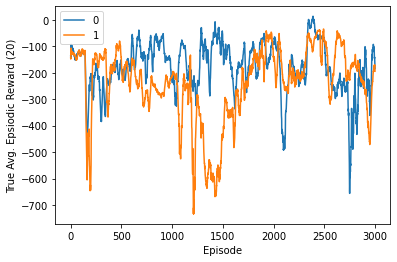

In [34]:
run(total_trials=2, total_episodes=3000, buffer_capacity=100000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=10000, continuous=False, std_dev_func=decreasing_std, actor_lr_func=decreasing_alr,
    critic_lr_func=decreasing_clr, epsilon_func=decreasing_eps)

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 1.90 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 1.24 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 1.20 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 1.18 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 1.31 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 1.00 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 1.39 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 1.15 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.98 * step 643
Ep 9 

Ep 73 * AvgReward -128.29 * true AvgReward -128.29 * Reward -138.39 * True Reward -138.39 * time 1.25 * step 5187
Ep 74 * AvgReward -127.56 * true AvgReward -127.56 * Reward -119.50 * True Reward -119.50 * time 1.68 * step 5271
Ep 75 * AvgReward -121.49 * true AvgReward -121.49 * Reward -31.14 * True Reward -31.14 * time 1.38 * step 5339
Ep 76 * AvgReward -122.94 * true AvgReward -122.94 * Reward -149.89 * True Reward -149.89 * time 1.36 * step 5406
Ep 77 * AvgReward -123.30 * true AvgReward -123.30 * Reward -140.74 * True Reward -140.74 * time 1.18 * step 5465
Ep 78 * AvgReward -123.87 * true AvgReward -123.87 * Reward -138.59 * True Reward -138.59 * time 1.28 * step 5528
Ep 79 * AvgReward -124.21 * true AvgReward -124.21 * Reward -135.67 * True Reward -135.67 * time 1.58 * step 5606
Ep 80 * AvgReward -117.66 * true AvgReward -117.66 * Reward -15.34 * True Reward -15.34 * time 1.14 * step 5663
Ep 81 * AvgReward -117.93 * true AvgReward -117.93 * Reward -124.36 * True Reward -124.36 * 

Ep 145 * AvgReward -183.58 * true AvgReward -183.58 * Reward -610.95 * True Reward -610.95 * time 1.50 * step 10220
Ep 146 * AvgReward -195.97 * true AvgReward -195.97 * Reward -357.81 * True Reward -357.81 * time 1.94 * step 10309
Ep 147 * AvgReward -214.66 * true AvgReward -214.66 * Reward -501.53 * True Reward -501.53 * time 1.70 * step 10387
Ep 148 * AvgReward -238.04 * true AvgReward -238.04 * Reward -596.53 * True Reward -596.53 * time 2.34 * step 10494
Ep 149 * AvgReward -249.01 * true AvgReward -249.01 * Reward -324.93 * True Reward -324.93 * time 1.12 * step 10546
Ep 150 * AvgReward -272.20 * true AvgReward -272.20 * Reward -617.45 * True Reward -617.45 * time 1.52 * step 10616
Ep 151 * AvgReward -284.27 * true AvgReward -284.27 * Reward -351.39 * True Reward -351.39 * time 1.28 * step 10674
Ep 152 * AvgReward -288.03 * true AvgReward -288.03 * Reward -235.79 * True Reward -235.79 * time 1.75 * step 10755
Ep 153 * AvgReward -288.88 * true AvgReward -288.88 * Reward -146.48 * T

Ep 216 * AvgReward -123.51 * true AvgReward -123.51 * Reward -198.81 * True Reward -198.81 * time 18.64 * step 26805
Ep 217 * AvgReward -123.41 * true AvgReward -123.41 * Reward -82.44 * True Reward -82.44 * time 23.58 * step 27805
Ep 218 * AvgReward -117.52 * true AvgReward -117.52 * Reward -99.00 * True Reward -99.00 * time 3.13 * step 27946
Ep 219 * AvgReward -125.71 * true AvgReward -125.71 * Reward -251.80 * True Reward -251.80 * time 17.83 * step 28728
Ep 220 * AvgReward -107.00 * true AvgReward -107.00 * Reward 13.16 * True Reward 13.16 * time 8.88 * step 29120
Ep 221 * AvgReward -108.41 * true AvgReward -108.41 * Reward -303.61 * True Reward -303.61 * time 23.67 * step 30120
Ep 222 * AvgReward -107.52 * true AvgReward -107.52 * Reward -226.90 * True Reward -226.90 * time 23.39 * step 31120
Ep 223 * AvgReward -112.85 * true AvgReward -112.85 * Reward -169.64 * True Reward -169.64 * time 17.72 * step 31903
Ep 224 * AvgReward -109.58 * true AvgReward -109.58 * Reward 81.28 * True 

Ep 288 * AvgReward -27.75 * true AvgReward -27.75 * Reward -141.30 * True Reward -141.30 * time 2.53 * step 73999
Ep 289 * AvgReward -24.40 * true AvgReward -24.40 * Reward -132.04 * True Reward -132.04 * time 8.22 * step 74369
Ep 290 * AvgReward -30.01 * true AvgReward -30.01 * Reward -162.51 * True Reward -162.51 * time 6.26 * step 74651
Ep 291 * AvgReward -31.72 * true AvgReward -31.72 * Reward -194.98 * True Reward -194.98 * time 10.71 * step 75122
Ep 292 * AvgReward -31.12 * true AvgReward -31.12 * Reward -31.72 * True Reward -31.72 * time 4.86 * step 75343
Ep 293 * AvgReward -31.71 * true AvgReward -31.71 * Reward -84.64 * True Reward -84.64 * time 2.81 * step 75471
Ep 294 * AvgReward -10.51 * true AvgReward -10.51 * Reward 269.87 * True Reward 269.87 * time 12.59 * step 76030
Ep 295 * AvgReward -10.52 * true AvgReward -10.52 * Reward 236.12 * True Reward 236.12 * time 6.88 * step 76339
Ep 296 * AvgReward -25.37 * true AvgReward -25.37 * Reward -107.18 * True Reward -107.18 * tim

Ep 362 * AvgReward 144.91 * true AvgReward 144.91 * Reward -18.02 * True Reward -18.02 * time 23.83 * step 119752
Ep 363 * AvgReward 134.98 * true AvgReward 134.98 * Reward -24.23 * True Reward -24.23 * time 24.11 * step 120752
Ep 364 * AvgReward 131.33 * true AvgReward 131.33 * Reward -15.11 * True Reward -15.11 * time 25.01 * step 121752
Ep 365 * AvgReward 122.83 * true AvgReward 122.83 * Reward -44.45 * True Reward -44.45 * time 24.38 * step 122752
Ep 366 * AvgReward 106.88 * true AvgReward 106.88 * Reward -67.10 * True Reward -67.10 * time 23.49 * step 123752
Ep 367 * AvgReward 104.70 * true AvgReward 104.70 * Reward 52.99 * True Reward 52.99 * time 23.33 * step 124752
Ep 368 * AvgReward 90.27 * true AvgReward 90.27 * Reward -30.61 * True Reward -30.61 * time 23.83 * step 125752
Ep 369 * AvgReward 85.17 * true AvgReward 85.17 * Reward -37.24 * True Reward -37.24 * time 23.30 * step 126752
Ep 370 * AvgReward 79.59 * true AvgReward 79.59 * Reward 3.12 * True Reward 3.12 * time 23.57 

Ep 436 * AvgReward 58.23 * true AvgReward 58.23 * Reward -188.67 * True Reward -188.67 * time 5.73 * step 182774
Ep 437 * AvgReward 68.02 * true AvgReward 68.02 * Reward 289.37 * True Reward 289.37 * time 19.29 * step 183581
Ep 438 * AvgReward 81.23 * true AvgReward 81.23 * Reward 228.06 * True Reward 228.06 * time 21.83 * step 184487
Ep 439 * AvgReward 95.09 * true AvgReward 95.09 * Reward 117.21 * True Reward 117.21 * time 24.27 * step 185487
Ep 440 * AvgReward 105.75 * true AvgReward 105.75 * Reward 210.04 * True Reward 210.04 * time 9.47 * step 185881
Ep 441 * AvgReward 99.92 * true AvgReward 99.92 * Reward -6.91 * True Reward -6.91 * time 24.04 * step 186881
Ep 442 * AvgReward 100.05 * true AvgReward 100.05 * Reward 149.48 * True Reward 149.48 * time 23.85 * step 187881
Ep 443 * AvgReward 96.18 * true AvgReward 96.18 * Reward 22.52 * True Reward 22.52 * time 24.40 * step 188881
Ep 444 * AvgReward 98.08 * true AvgReward 98.08 * Reward 255.96 * True Reward 255.96 * time 12.21 * step

Ep 510 * AvgReward 24.90 * true AvgReward 24.90 * Reward -22.70 * True Reward -22.70 * time 2.47 * step 219138
Ep 511 * AvgReward 25.86 * true AvgReward 25.86 * Reward 6.41 * True Reward 6.41 * time 2.04 * step 219225
Ep 512 * AvgReward 28.62 * true AvgReward 28.62 * Reward 11.23 * True Reward 11.23 * time 2.04 * step 219310
Ep 513 * AvgReward 29.60 * true AvgReward 29.60 * Reward -1.99 * True Reward -1.99 * time 1.97 * step 219394
Ep 514 * AvgReward 25.08 * true AvgReward 25.08 * Reward -45.32 * True Reward -45.32 * time 2.27 * step 219478
Ep 515 * AvgReward 9.65 * true AvgReward 9.65 * Reward -40.22 * True Reward -40.22 * time 2.08 * step 219566
Ep 516 * AvgReward 9.08 * true AvgReward 9.08 * Reward -20.38 * True Reward -20.38 * time 2.06 * step 219653
Ep 517 * AvgReward 9.44 * true AvgReward 9.44 * Reward 15.86 * True Reward 15.86 * time 2.86 * step 219775
Ep 518 * AvgReward 9.49 * true AvgReward 9.49 * Reward -21.50 * True Reward -21.50 * time 2.11 * step 219865
Ep 519 * AvgReward 

Ep 585 * AvgReward 14.94 * true AvgReward 14.94 * Reward -74.29 * True Reward -74.29 * time 5.34 * step 248201
Ep 586 * AvgReward 12.09 * true AvgReward 12.09 * Reward -91.59 * True Reward -91.59 * time 4.08 * step 248374
Ep 587 * AvgReward 7.72 * true AvgReward 7.72 * Reward -104.54 * True Reward -104.54 * time 3.86 * step 248538
Ep 588 * AvgReward 6.43 * true AvgReward 6.43 * Reward -37.62 * True Reward -37.62 * time 1.66 * step 248610
Ep 589 * AvgReward 9.41 * true AvgReward 9.41 * Reward 26.50 * True Reward 26.50 * time 2.99 * step 248728
Ep 590 * AvgReward 19.44 * true AvgReward 19.44 * Reward 36.57 * True Reward 36.57 * time 3.25 * step 248866
Ep 591 * AvgReward 4.31 * true AvgReward 4.31 * Reward -42.65 * True Reward -42.65 * time 1.75 * step 248940
Ep 592 * AvgReward 2.97 * true AvgReward 2.97 * Reward 3.95 * True Reward 3.95 * time 24.83 * step 249940
Ep 593 * AvgReward 5.92 * true AvgReward 5.92 * Reward 25.09 * True Reward 25.09 * time 3.04 * step 250066
Ep 594 * AvgReward -

Ep 659 * AvgReward -52.18 * true AvgReward -52.18 * Reward -39.95 * True Reward -39.95 * time 2.58 * step 279496
Ep 660 * AvgReward -65.17 * true AvgReward -65.17 * Reward -52.23 * True Reward -52.23 * time 1.63 * step 279564
Ep 661 * AvgReward -67.37 * true AvgReward -67.37 * Reward -75.20 * True Reward -75.20 * time 2.07 * step 279650
Ep 662 * AvgReward -66.36 * true AvgReward -66.36 * Reward -1.72 * True Reward -1.72 * time 2.68 * step 279761
Ep 663 * AvgReward -49.91 * true AvgReward -49.91 * Reward 256.14 * True Reward 256.14 * time 16.23 * step 280394
Ep 664 * AvgReward -56.34 * true AvgReward -56.34 * Reward -141.52 * True Reward -141.52 * time 12.74 * step 280911
Ep 665 * AvgReward -59.35 * true AvgReward -59.35 * Reward -23.14 * True Reward -23.14 * time 6.62 * step 281184
Ep 666 * AvgReward -63.79 * true AvgReward -63.79 * Reward -84.18 * True Reward -84.18 * time 1.46 * step 281245
Ep 667 * AvgReward -62.78 * true AvgReward -62.78 * Reward -62.02 * True Reward -62.02 * time 

Ep 733 * AvgReward 28.09 * true AvgReward 28.09 * Reward 184.48 * True Reward 184.48 * time 23.93 * step 301925
Ep 734 * AvgReward 38.68 * true AvgReward 38.68 * Reward 254.21 * True Reward 254.21 * time 11.37 * step 302396
Ep 735 * AvgReward 43.75 * true AvgReward 43.75 * Reward 109.93 * True Reward 109.93 * time 24.91 * step 303396
Ep 736 * AvgReward 55.91 * true AvgReward 55.91 * Reward 167.92 * True Reward 167.92 * time 25.71 * step 304387
Ep 737 * AvgReward 56.96 * true AvgReward 56.96 * Reward -45.22 * True Reward -45.22 * time 25.18 * step 305387
Ep 738 * AvgReward 59.30 * true AvgReward 59.30 * Reward 8.48 * True Reward 8.48 * time 26.06 * step 306387
Ep 739 * AvgReward 64.27 * true AvgReward 64.27 * Reward 38.18 * True Reward 38.18 * time 2.60 * step 306495
Ep 740 * AvgReward 53.17 * true AvgReward 53.17 * Reward -11.91 * True Reward -11.91 * time 5.75 * step 306733
Ep 741 * AvgReward 52.59 * true AvgReward 52.59 * Reward -10.06 * True Reward -10.06 * time 25.72 * step 307733


Ep 807 * AvgReward 13.46 * true AvgReward 13.46 * Reward -78.98 * True Reward -78.98 * time 1.77 * step 346979
Ep 808 * AvgReward 32.28 * true AvgReward 32.28 * Reward 301.99 * True Reward 301.99 * time 6.68 * step 347250
Ep 809 * AvgReward 35.62 * true AvgReward 35.62 * Reward 20.72 * True Reward 20.72 * time 2.41 * step 347344
Ep 810 * AvgReward 37.50 * true AvgReward 37.50 * Reward -11.83 * True Reward -11.83 * time 2.98 * step 347469
Ep 811 * AvgReward 33.80 * true AvgReward 33.80 * Reward 124.76 * True Reward 124.76 * time 24.87 * step 348469
Ep 812 * AvgReward 26.69 * true AvgReward 26.69 * Reward -9.85 * True Reward -9.85 * time 2.35 * step 348566
Ep 813 * AvgReward 12.52 * true AvgReward 12.52 * Reward -79.78 * True Reward -79.78 * time 1.54 * step 348629
Ep 814 * AvgReward 5.37 * true AvgReward 5.37 * Reward -61.24 * True Reward -61.24 * time 1.49 * step 348691
Ep 815 * AvgReward 9.72 * true AvgReward 9.72 * Reward 14.35 * True Reward 14.35 * time 3.12 * step 348819
Ep 816 * A

Ep 882 * AvgReward 32.92 * true AvgReward 32.92 * Reward 203.80 * True Reward 203.80 * time 24.33 * step 373874
Ep 883 * AvgReward 18.21 * true AvgReward 18.21 * Reward -10.82 * True Reward -10.82 * time 2.17 * step 373963
Ep 884 * AvgReward 5.70 * true AvgReward 5.70 * Reward -53.81 * True Reward -53.81 * time 2.51 * step 374067
Ep 885 * AvgReward 5.02 * true AvgReward 5.02 * Reward -32.36 * True Reward -32.36 * time 2.37 * step 374164
Ep 886 * AvgReward -2.95 * true AvgReward -2.95 * Reward -145.78 * True Reward -145.78 * time 19.71 * step 374929
Ep 887 * AvgReward 8.29 * true AvgReward 8.29 * Reward 182.78 * True Reward 182.78 * time 21.99 * step 375768
Ep 888 * AvgReward 7.71 * true AvgReward 7.71 * Reward 86.59 * True Reward 86.59 * time 25.58 * step 376768
Ep 889 * AvgReward 17.13 * true AvgReward 17.13 * Reward 193.46 * True Reward 193.46 * time 14.04 * step 377331
Ep 890 * AvgReward 25.32 * true AvgReward 25.32 * Reward 91.43 * True Reward 91.43 * time 25.63 * step 378331
Ep 89

Ep 956 * AvgReward 0.31 * true AvgReward 0.31 * Reward -134.78 * True Reward -134.78 * time 4.50 * step 430051
Ep 957 * AvgReward 3.37 * true AvgReward 3.37 * Reward 19.91 * True Reward 19.91 * time 25.59 * step 431051
Ep 958 * AvgReward 4.53 * true AvgReward 4.53 * Reward 67.70 * True Reward 67.70 * time 26.16 * step 432051
Ep 959 * AvgReward -5.88 * true AvgReward -5.88 * Reward -46.63 * True Reward -46.63 * time 1.95 * step 432131
Ep 960 * AvgReward 1.23 * true AvgReward 1.23 * Reward 172.54 * True Reward 172.54 * time 21.11 * step 432938
Ep 961 * AvgReward 4.89 * true AvgReward 4.89 * Reward 92.21 * True Reward 92.21 * time 25.86 * step 433938
Ep 962 * AvgReward -1.42 * true AvgReward -1.42 * Reward -111.99 * True Reward -111.99 * time 4.72 * step 434130
Ep 963 * AvgReward 5.18 * true AvgReward 5.18 * Reward 137.47 * True Reward 137.47 * time 25.43 * step 435129
Ep 964 * AvgReward 9.38 * true AvgReward 9.38 * Reward 98.43 * True Reward 98.43 * time 26.01 * step 436129
Ep 965 * AvgR

Ep 1029 * AvgReward 70.91 * true AvgReward 70.91 * Reward 121.08 * True Reward 121.08 * time 26.10 * step 486065
Ep 1030 * AvgReward 54.40 * true AvgReward 54.40 * Reward -90.28 * True Reward -90.28 * time 7.05 * step 486346
Ep 1031 * AvgReward 69.14 * true AvgReward 69.14 * Reward 269.13 * True Reward 269.13 * time 11.01 * step 486777
Ep 1032 * AvgReward 63.40 * true AvgReward 63.40 * Reward -159.75 * True Reward -159.75 * time 10.78 * step 487196
Ep 1033 * AvgReward 67.56 * true AvgReward 67.56 * Reward 101.14 * True Reward 101.14 * time 26.25 * step 488196
Ep 1034 * AvgReward 49.00 * true AvgReward 49.00 * Reward -165.26 * True Reward -165.26 * time 15.87 * step 488803
Ep 1035 * AvgReward 56.49 * true AvgReward 56.49 * Reward 11.84 * True Reward 11.84 * time 26.24 * step 489803
Ep 1036 * AvgReward 53.18 * true AvgReward 53.18 * Reward -11.39 * True Reward -11.39 * time 3.48 * step 489943
Ep 1037 * AvgReward 43.24 * true AvgReward 43.24 * Reward -164.15 * True Reward -164.15 * time 1

Ep 1102 * AvgReward 77.92 * true AvgReward 77.92 * Reward 70.36 * True Reward 70.36 * time 26.55 * step 541618
Ep 1103 * AvgReward 78.24 * true AvgReward 78.24 * Reward 50.50 * True Reward 50.50 * time 27.27 * step 542618
Ep 1104 * AvgReward 84.65 * true AvgReward 84.65 * Reward 105.83 * True Reward 105.83 * time 26.85 * step 543618
Ep 1105 * AvgReward 86.30 * true AvgReward 86.30 * Reward 94.82 * True Reward 94.82 * time 26.35 * step 544618
Ep 1106 * AvgReward 87.70 * true AvgReward 87.70 * Reward 32.29 * True Reward 32.29 * time 26.10 * step 545618
Ep 1107 * AvgReward 74.94 * true AvgReward 74.94 * Reward -147.82 * True Reward -147.82 * time 7.46 * step 545911
Ep 1108 * AvgReward 75.15 * true AvgReward 75.15 * Reward 103.46 * True Reward 103.46 * time 27.18 * step 546911
Ep 1109 * AvgReward 70.20 * true AvgReward 70.20 * Reward -13.64 * True Reward -13.64 * time 3.12 * step 547037
Ep 1110 * AvgReward 71.73 * true AvgReward 71.73 * Reward 113.48 * True Reward 113.48 * time 26.79 * ste

Ep 1176 * AvgReward -6.76 * true AvgReward -6.76 * Reward -68.42 * True Reward -68.42 * time 27.69 * step 598673
Ep 1177 * AvgReward -2.93 * true AvgReward -2.93 * Reward 124.73 * True Reward 124.73 * time 26.95 * step 599673
Ep 1178 * AvgReward -1.85 * true AvgReward -1.85 * Reward -59.50 * True Reward -59.50 * time 3.50 * step 599809
Ep 1179 * AvgReward 5.53 * true AvgReward 5.53 * Reward 122.36 * True Reward 122.36 * time 26.61 * step 600809
Ep 1180 * AvgReward 4.15 * true AvgReward 4.15 * Reward -46.64 * True Reward -46.64 * time 12.36 * step 601279
Ep 1181 * AvgReward 5.58 * true AvgReward 5.58 * Reward -7.80 * True Reward -7.80 * time 3.02 * step 601396
Ep 1182 * AvgReward 3.67 * true AvgReward 3.67 * Reward -15.78 * True Reward -15.78 * time 2.34 * step 601488
Ep 1183 * AvgReward 5.88 * true AvgReward 5.88 * Reward -13.09 * True Reward -13.09 * time 1.95 * step 601565
Ep 1184 * AvgReward 20.45 * true AvgReward 20.45 * Reward 200.43 * True Reward 200.43 * time 24.86 * step 602513

Ep 1250 * AvgReward 67.93 * true AvgReward 67.93 * Reward 202.75 * True Reward 202.75 * time 19.48 * step 650328
Ep 1251 * AvgReward 84.28 * true AvgReward 84.28 * Reward 194.37 * True Reward 194.37 * time 17.70 * step 650990
Ep 1252 * AvgReward 75.00 * true AvgReward 75.00 * Reward -31.48 * True Reward -31.48 * time 4.31 * step 651156
Ep 1253 * AvgReward 73.77 * true AvgReward 73.77 * Reward 168.58 * True Reward 168.58 * time 26.70 * step 652156
Ep 1254 * AvgReward 72.12 * true AvgReward 72.12 * Reward 67.66 * True Reward 67.66 * time 26.72 * step 653156
Ep 1255 * AvgReward 73.27 * true AvgReward 73.27 * Reward 202.86 * True Reward 202.86 * time 18.78 * step 653855
Ep 1256 * AvgReward 79.99 * true AvgReward 79.99 * Reward 39.98 * True Reward 39.98 * time 27.95 * step 654855
Ep 1257 * AvgReward 73.69 * true AvgReward 73.69 * Reward -325.03 * True Reward -325.03 * time 23.38 * step 655728
Ep 1258 * AvgReward 64.40 * true AvgReward 64.40 * Reward -3.05 * True Reward -3.05 * time 26.73 * 

Ep 1323 * AvgReward 120.14 * true AvgReward 120.14 * Reward -189.94 * True Reward -189.94 * time 2.17 * step 706583
Ep 1324 * AvgReward 119.64 * true AvgReward 119.64 * Reward 101.53 * True Reward 101.53 * time 27.17 * step 707583
Ep 1325 * AvgReward 105.74 * true AvgReward 105.74 * Reward -57.56 * True Reward -57.56 * time 5.15 * step 707775
Ep 1326 * AvgReward 97.59 * true AvgReward 97.59 * Reward 77.40 * True Reward 77.40 * time 27.26 * step 708775
Ep 1327 * AvgReward 100.32 * true AvgReward 100.32 * Reward 212.69 * True Reward 212.69 * time 19.80 * step 709507
Ep 1328 * AvgReward 97.40 * true AvgReward 97.40 * Reward 39.25 * True Reward 39.25 * time 4.19 * step 709667
Ep 1329 * AvgReward 84.81 * true AvgReward 84.81 * Reward -30.66 * True Reward -30.66 * time 9.60 * step 710028
Ep 1330 * AvgReward 86.31 * true AvgReward 86.31 * Reward 105.28 * True Reward 105.28 * time 27.29 * step 711028
Ep 1331 * AvgReward 81.74 * true AvgReward 81.74 * Reward 6.09 * True Reward 6.09 * time 26.87

Ep 1396 * AvgReward 134.78 * true AvgReward 134.78 * Reward 16.84 * True Reward 16.84 * time 28.06 * step 759141
Ep 1397 * AvgReward 135.91 * true AvgReward 135.91 * Reward 19.71 * True Reward 19.71 * time 3.38 * step 759267
Ep 1398 * AvgReward 143.67 * true AvgReward 143.67 * Reward 245.05 * True Reward 245.05 * time 12.16 * step 759719
Ep 1399 * AvgReward 141.96 * true AvgReward 141.96 * Reward 233.37 * True Reward 233.37 * time 17.60 * step 760365
Ep 1400 * AvgReward 132.02 * true AvgReward 132.02 * Reward 81.79 * True Reward 81.79 * time 27.66 * step 761365
Ep 1401 * AvgReward 128.73 * true AvgReward 128.73 * Reward 57.97 * True Reward 57.97 * time 27.67 * step 762365
Ep 1402 * AvgReward 131.08 * true AvgReward 131.08 * Reward 133.28 * True Reward 133.28 * time 26.45 * step 763293
Ep 1403 * AvgReward 135.33 * true AvgReward 135.33 * Reward 224.04 * True Reward 224.04 * time 21.22 * step 764068
Ep 1404 * AvgReward 120.78 * true AvgReward 120.78 * Reward -5.31 * True Reward -5.31 * t

Ep 1468 * AvgReward 65.46 * true AvgReward 65.46 * Reward 158.27 * True Reward 158.27 * time 27.73 * step 811863
Ep 1469 * AvgReward 50.06 * true AvgReward 50.06 * Reward -66.79 * True Reward -66.79 * time 9.12 * step 812199
Ep 1470 * AvgReward 47.26 * true AvgReward 47.26 * Reward 84.57 * True Reward 84.57 * time 27.60 * step 813199
Ep 1471 * AvgReward 36.45 * true AvgReward 36.45 * Reward -133.38 * True Reward -133.38 * time 25.64 * step 814094
Ep 1472 * AvgReward 35.41 * true AvgReward 35.41 * Reward -78.61 * True Reward -78.61 * time 3.75 * step 814235
Ep 1473 * AvgReward 26.86 * true AvgReward 26.86 * Reward 42.82 * True Reward 42.82 * time 28.58 * step 815235
Ep 1474 * AvgReward 29.99 * true AvgReward 29.99 * Reward 72.15 * True Reward 72.15 * time 27.58 * step 816235
Ep 1475 * AvgReward 16.11 * true AvgReward 16.11 * Reward -55.47 * True Reward -55.47 * time 27.67 * step 817235
Ep 1476 * AvgReward 14.36 * true AvgReward 14.36 * Reward 11.57 * True Reward 11.57 * time 28.56 * ste

Ep 1541 * AvgReward 50.52 * true AvgReward 50.52 * Reward 48.90 * True Reward 48.90 * time 2.67 * step 866132
Ep 1542 * AvgReward 41.83 * true AvgReward 41.83 * Reward -5.23 * True Reward -5.23 * time 3.95 * step 866274
Ep 1543 * AvgReward 31.92 * true AvgReward 31.92 * Reward 34.56 * True Reward 34.56 * time 4.20 * step 866415
Ep 1544 * AvgReward 53.04 * true AvgReward 53.04 * Reward 250.94 * True Reward 250.94 * time 22.42 * step 867201
Ep 1545 * AvgReward 54.09 * true AvgReward 54.09 * Reward 7.57 * True Reward 7.57 * time 11.30 * step 867610
Ep 1546 * AvgReward 52.83 * true AvgReward 52.83 * Reward 31.34 * True Reward 31.34 * time 28.78 * step 868610
Ep 1547 * AvgReward 54.06 * true AvgReward 54.06 * Reward 129.74 * True Reward 129.74 * time 27.90 * step 869610
Ep 1548 * AvgReward 62.69 * true AvgReward 62.69 * Reward 142.40 * True Reward 142.40 * time 27.97 * step 870591
Ep 1549 * AvgReward 71.85 * true AvgReward 71.85 * Reward 182.49 * True Reward 182.49 * time 20.90 * step 87132

Ep 1615 * AvgReward 19.12 * true AvgReward 19.12 * Reward -33.29 * True Reward -33.29 * time 6.24 * step 899738
Ep 1616 * AvgReward 15.81 * true AvgReward 15.81 * Reward -80.44 * True Reward -80.44 * time 1.51 * step 899794
Ep 1617 * AvgReward 14.74 * true AvgReward 14.74 * Reward -13.63 * True Reward -13.63 * time 2.60 * step 899890
Ep 1618 * AvgReward 4.52 * true AvgReward 4.52 * Reward 21.33 * True Reward 21.33 * time 2.24 * step 899973
Ep 1619 * AvgReward 8.67 * true AvgReward 8.67 * Reward 188.51 * True Reward 188.51 * time 16.86 * step 900588
Ep 1620 * AvgReward 13.92 * true AvgReward 13.92 * Reward 64.19 * True Reward 64.19 * time 27.94 * step 901588
Ep 1621 * AvgReward 21.54 * true AvgReward 21.54 * Reward 135.99 * True Reward 135.99 * time 27.65 * step 902588
Ep 1622 * AvgReward 21.58 * true AvgReward 21.58 * Reward -53.35 * True Reward -53.35 * time 2.65 * step 902682
Ep 1623 * AvgReward 28.62 * true AvgReward 28.62 * Reward 161.44 * True Reward 161.44 * time 26.57 * step 903

Ep 1688 * AvgReward 130.54 * true AvgReward 130.54 * Reward 73.98 * True Reward 73.98 * time 29.83 * step 951498
Ep 1689 * AvgReward 130.99 * true AvgReward 130.99 * Reward -15.18 * True Reward -15.18 * time 3.16 * step 951610
Ep 1690 * AvgReward 132.68 * true AvgReward 132.68 * Reward 237.89 * True Reward 237.89 * time 14.99 * step 952133
Ep 1691 * AvgReward 135.26 * true AvgReward 135.26 * Reward 89.33 * True Reward 89.33 * time 30.09 * step 953133
Ep 1692 * AvgReward 132.42 * true AvgReward 132.42 * Reward 19.51 * True Reward 19.51 * time 29.74 * step 954133
Ep 1693 * AvgReward 120.91 * true AvgReward 120.91 * Reward -17.02 * True Reward -17.02 * time 16.59 * step 954705
Ep 1694 * AvgReward 112.76 * true AvgReward 112.76 * Reward 39.18 * True Reward 39.18 * time 2.73 * step 954800
Ep 1695 * AvgReward 113.26 * true AvgReward 113.26 * Reward 218.08 * True Reward 218.08 * time 15.42 * step 955325
Ep 1696 * AvgReward 111.83 * true AvgReward 111.83 * Reward 58.28 * True Reward 58.28 * ti

Ep 1761 * AvgReward 41.54 * true AvgReward 41.54 * Reward -42.25 * True Reward -42.25 * time 3.31 * step 997385
Ep 1762 * AvgReward 36.24 * true AvgReward 36.24 * Reward -121.49 * True Reward -121.49 * time 15.76 * step 997925
Ep 1763 * AvgReward 40.16 * true AvgReward 40.16 * Reward 82.13 * True Reward 82.13 * time 29.81 * step 998925
Ep 1764 * AvgReward 45.65 * true AvgReward 45.65 * Reward 7.28 * True Reward 7.28 * time 30.26 * step 999925
Ep 1765 * AvgReward 42.67 * true AvgReward 42.67 * Reward -17.37 * True Reward -17.37 * time 4.42 * step 1000085
Ep 1766 * AvgReward 33.61 * true AvgReward 33.61 * Reward -42.44 * True Reward -42.44 * time 2.48 * step 1000175
Ep 1767 * AvgReward 40.92 * true AvgReward 40.92 * Reward 103.82 * True Reward 103.82 * time 29.32 * step 1001175
Ep 1768 * AvgReward 44.87 * true AvgReward 44.87 * Reward 246.24 * True Reward 246.24 * time 15.51 * step 1001701
Ep 1769 * AvgReward 51.19 * true AvgReward 51.19 * Reward 94.31 * True Reward 94.31 * time 30.01 * 

Ep 1834 * AvgReward 31.02 * true AvgReward 31.02 * Reward -61.88 * True Reward -61.88 * time 18.62 * step 1037810
Ep 1835 * AvgReward 40.86 * true AvgReward 40.86 * Reward 147.47 * True Reward 147.47 * time 30.19 * step 1038810
Ep 1836 * AvgReward 43.95 * true AvgReward 43.95 * Reward -12.33 * True Reward -12.33 * time 5.82 * step 1038999
Ep 1837 * AvgReward 43.87 * true AvgReward 43.87 * Reward 40.46 * True Reward 40.46 * time 7.06 * step 1039237
Ep 1838 * AvgReward 52.93 * true AvgReward 52.93 * Reward 193.83 * True Reward 193.83 * time 18.83 * step 1039851
Ep 1839 * AvgReward 47.85 * true AvgReward 47.85 * Reward 138.69 * True Reward 138.69 * time 30.83 * step 1040851
Ep 1840 * AvgReward 37.00 * true AvgReward 37.00 * Reward 9.92 * True Reward 9.92 * time 13.43 * step 1041286
Ep 1841 * AvgReward 27.56 * true AvgReward 27.56 * Reward 32.28 * True Reward 32.28 * time 31.48 * step 1042286
Ep 1842 * AvgReward 39.43 * true AvgReward 39.43 * Reward 209.21 * True Reward 209.21 * time 24.67

Ep 1907 * AvgReward 85.57 * true AvgReward 85.57 * Reward 112.35 * True Reward 112.35 * time 34.34 * step 1076340
Ep 1908 * AvgReward 85.83 * true AvgReward 85.83 * Reward 221.61 * True Reward 221.61 * time 26.26 * step 1077122
Ep 1909 * AvgReward 92.57 * true AvgReward 92.57 * Reward 188.48 * True Reward 188.48 * time 22.94 * step 1077812
Ep 1910 * AvgReward 90.02 * true AvgReward 90.02 * Reward 179.01 * True Reward 179.01 * time 31.05 * step 1078733
Ep 1911 * AvgReward 76.48 * true AvgReward 76.48 * Reward -7.78 * True Reward -7.78 * time 6.95 * step 1078925
Ep 1912 * AvgReward 86.95 * true AvgReward 86.95 * Reward 243.19 * True Reward 243.19 * time 13.75 * step 1079341
Ep 1913 * AvgReward 87.21 * true AvgReward 87.21 * Reward 18.69 * True Reward 18.69 * time 6.51 * step 1079545
Ep 1914 * AvgReward 95.20 * true AvgReward 95.20 * Reward 189.20 * True Reward 189.20 * time 24.62 * step 1080282
Ep 1915 * AvgReward 84.20 * true AvgReward 84.20 * Reward 3.11 * True Reward 3.11 * time 4.04 

Ep 1980 * AvgReward 161.92 * true AvgReward 161.92 * Reward 221.77 * True Reward 221.77 * time 30.79 * step 1112171
Ep 1981 * AvgReward 160.56 * true AvgReward 160.56 * Reward -1.95 * True Reward -1.95 * time 3.42 * step 1112277
Ep 1982 * AvgReward 161.51 * true AvgReward 161.51 * Reward 26.23 * True Reward 26.23 * time 5.49 * step 1112446
Ep 1983 * AvgReward 160.64 * true AvgReward 160.64 * Reward 276.33 * True Reward 276.33 * time 22.17 * step 1113099
Ep 1984 * AvgReward 161.22 * true AvgReward 161.22 * Reward 33.87 * True Reward 33.87 * time 3.02 * step 1113187
Ep 1985 * AvgReward 163.85 * true AvgReward 163.85 * Reward 233.98 * True Reward 233.98 * time 18.72 * step 1113721
Ep 1986 * AvgReward 172.23 * true AvgReward 172.23 * Reward 269.03 * True Reward 269.03 * time 12.30 * step 1114090
Ep 1987 * AvgReward 182.31 * true AvgReward 182.31 * Reward 267.00 * True Reward 267.00 * time 24.87 * step 1114835
Ep 1988 * AvgReward 170.18 * true AvgReward 170.18 * Reward -7.64 * True Reward -

Ep 2053 * AvgReward 36.26 * true AvgReward 36.26 * Reward 266.36 * True Reward 266.36 * time 20.50 * step 1143766
Ep 2054 * AvgReward 36.83 * true AvgReward 36.83 * Reward 38.82 * True Reward 38.82 * time 33.65 * step 1144766
Ep 2055 * AvgReward 39.79 * true AvgReward 39.79 * Reward 20.32 * True Reward 20.32 * time 5.28 * step 1144926
Ep 2056 * AvgReward 40.11 * true AvgReward 40.11 * Reward 5.41 * True Reward 5.41 * time 2.92 * step 1145015
Ep 2057 * AvgReward 53.32 * true AvgReward 53.32 * Reward 246.28 * True Reward 246.28 * time 23.18 * step 1145713
Ep 2058 * AvgReward 51.18 * true AvgReward 51.18 * Reward 13.26 * True Reward 13.26 * time 2.36 * step 1145785
Ep 2059 * AvgReward 63.99 * true AvgReward 63.99 * Reward 234.03 * True Reward 234.03 * time 16.87 * step 1146282
Ep 2060 * AvgReward 63.85 * true AvgReward 63.85 * Reward 38.31 * True Reward 38.31 * time 3.51 * step 1146389
Ep 2061 * AvgReward 61.78 * true AvgReward 61.78 * Reward 14.19 * True Reward 14.19 * time 3.27 * step 1

Ep 2126 * AvgReward -41.19 * true AvgReward -41.19 * Reward 16.56 * True Reward 16.56 * time 3.97 * step 1175315
Ep 2127 * AvgReward -51.06 * true AvgReward -51.06 * Reward -199.62 * True Reward -199.62 * time 22.06 * step 1175841
Ep 2128 * AvgReward -50.41 * true AvgReward -50.41 * Reward 70.39 * True Reward 70.39 * time 48.66 * step 1176841
Ep 2129 * AvgReward -47.09 * true AvgReward -47.09 * Reward 65.73 * True Reward 65.73 * time 6.15 * step 1176985
Ep 2130 * AvgReward -49.21 * true AvgReward -49.21 * Reward -34.06 * True Reward -34.06 * time 7.09 * step 1177164
Ep 2131 * AvgReward -30.74 * true AvgReward -30.74 * Reward 291.14 * True Reward 291.14 * time 17.78 * step 1177687
Ep 2132 * AvgReward -37.14 * true AvgReward -37.14 * Reward -4.65 * True Reward -4.65 * time 3.25 * step 1177784
Ep 2133 * AvgReward -39.05 * true AvgReward -39.05 * Reward -242.50 * True Reward -242.50 * time 4.60 * step 1177921
Ep 2134 * AvgReward -44.53 * true AvgReward -44.53 * Reward -86.33 * True Reward 

Ep 2199 * AvgReward 69.29 * true AvgReward 69.29 * Reward 33.18 * True Reward 33.18 * time 3.77 * step 1209615
Ep 2200 * AvgReward 72.37 * true AvgReward 72.37 * Reward 27.54 * True Reward 27.54 * time 3.64 * step 1209723
Ep 2201 * AvgReward 64.71 * true AvgReward 64.71 * Reward -109.16 * True Reward -109.16 * time 27.80 * step 1210430
Ep 2202 * AvgReward 68.03 * true AvgReward 68.03 * Reward 122.99 * True Reward 122.99 * time 33.59 * step 1211430
Ep 2203 * AvgReward 55.26 * true AvgReward 55.26 * Reward 7.88 * True Reward 7.88 * time 33.53 * step 1212430
Ep 2204 * AvgReward 50.25 * true AvgReward 50.25 * Reward -74.20 * True Reward -74.20 * time 32.80 * step 1213430
Ep 2205 * AvgReward 50.74 * true AvgReward 50.74 * Reward 0.46 * True Reward 0.46 * time 3.21 * step 1213531
Ep 2206 * AvgReward 62.09 * true AvgReward 62.09 * Reward 242.71 * True Reward 242.71 * time 10.37 * step 1213853
Ep 2207 * AvgReward 61.52 * true AvgReward 61.52 * Reward -9.24 * True Reward -9.24 * time 33.15 * st

Ep 2272 * AvgReward 69.81 * true AvgReward 69.81 * Reward -18.11 * True Reward -18.11 * time 33.17 * step 1252214
Ep 2273 * AvgReward 67.53 * true AvgReward 67.53 * Reward -53.58 * True Reward -53.58 * time 33.15 * step 1253214
Ep 2274 * AvgReward 62.98 * true AvgReward 62.98 * Reward -19.63 * True Reward -19.63 * time 6.63 * step 1253421
Ep 2275 * AvgReward 55.96 * true AvgReward 55.96 * Reward -118.58 * True Reward -118.58 * time 21.06 * step 1254068
Ep 2276 * AvgReward 56.26 * true AvgReward 56.26 * Reward -18.62 * True Reward -18.62 * time 33.14 * step 1255068
Ep 2277 * AvgReward 57.90 * true AvgReward 57.90 * Reward 16.36 * True Reward 16.36 * time 4.07 * step 1255195
Ep 2278 * AvgReward 57.10 * true AvgReward 57.10 * Reward -30.10 * True Reward -30.10 * time 33.26 * step 1256195
Ep 2279 * AvgReward 46.40 * true AvgReward 46.40 * Reward 33.32 * True Reward 33.32 * time 33.65 * step 1257195
Ep 2280 * AvgReward 38.84 * true AvgReward 38.84 * Reward 42.99 * True Reward 42.99 * time 4

Ep 2344 * AvgReward -25.08 * true AvgReward -25.08 * Reward -19.13 * True Reward -19.13 * time 33.83 * step 1298615
Ep 2345 * AvgReward -27.98 * true AvgReward -27.98 * Reward -96.07 * True Reward -96.07 * time 7.38 * step 1298838
Ep 2346 * AvgReward -20.59 * true AvgReward -20.59 * Reward 34.08 * True Reward 34.08 * time 34.60 * step 1299838
Ep 2347 * AvgReward -2.92 * true AvgReward -2.92 * Reward 219.48 * True Reward 219.48 * time 10.15 * step 1300145
Ep 2348 * AvgReward 3.08 * true AvgReward 3.08 * Reward -37.66 * True Reward -37.66 * time 5.86 * step 1300316
Ep 2349 * AvgReward -1.13 * true AvgReward -1.13 * Reward -61.73 * True Reward -61.73 * time 8.73 * step 1300568
Ep 2350 * AvgReward 0.86 * true AvgReward 0.86 * Reward 13.08 * True Reward 13.08 * time 3.54 * step 1300676
Ep 2351 * AvgReward 0.52 * true AvgReward 0.52 * Reward -21.39 * True Reward -21.39 * time 15.52 * step 1301134
Ep 2352 * AvgReward -6.36 * true AvgReward -6.36 * Reward -135.88 * True Reward -135.88 * time 1

Ep 2416 * AvgReward -33.05 * true AvgReward -33.05 * Reward -30.92 * True Reward -30.92 * time 2.84 * step 1332305
Ep 2417 * AvgReward -29.97 * true AvgReward -29.97 * Reward -17.94 * True Reward -17.94 * time 3.78 * step 1332418
Ep 2418 * AvgReward -26.82 * true AvgReward -26.82 * Reward 16.49 * True Reward 16.49 * time 21.17 * step 1333040
Ep 2419 * AvgReward -31.94 * true AvgReward -31.94 * Reward -115.92 * True Reward -115.92 * time 8.04 * step 1333280
Ep 2420 * AvgReward -25.07 * true AvgReward -25.07 * Reward -21.05 * True Reward -21.05 * time 5.38 * step 1333435
Ep 2421 * AvgReward -19.16 * true AvgReward -19.16 * Reward -18.10 * True Reward -18.10 * time 8.24 * step 1333681
Ep 2422 * AvgReward -22.28 * true AvgReward -22.28 * Reward -29.05 * True Reward -29.05 * time 8.83 * step 1333944
Ep 2423 * AvgReward -26.05 * true AvgReward -26.05 * Reward -64.44 * True Reward -64.44 * time 3.05 * step 1334036
Ep 2424 * AvgReward -26.01 * true AvgReward -26.01 * Reward -32.21 * True Rewar

Ep 2489 * AvgReward -11.99 * true AvgReward -11.99 * Reward 23.83 * True Reward 23.83 * time 3.40 * step 1369435
Ep 2490 * AvgReward -15.19 * true AvgReward -15.19 * Reward -63.98 * True Reward -63.98 * time 36.04 * step 1370435
Ep 2491 * AvgReward -10.43 * true AvgReward -10.43 * Reward 63.99 * True Reward 63.99 * time 35.47 * step 1371435
Ep 2492 * AvgReward -12.40 * true AvgReward -12.40 * Reward -46.57 * True Reward -46.57 * time 34.00 * step 1372435
Ep 2493 * AvgReward -18.80 * true AvgReward -18.80 * Reward 78.31 * True Reward 78.31 * time 35.25 * step 1373435
Ep 2494 * AvgReward -21.88 * true AvgReward -21.88 * Reward -42.52 * True Reward -42.52 * time 3.32 * step 1373533
Ep 2495 * AvgReward -20.55 * true AvgReward -20.55 * Reward 18.17 * True Reward 18.17 * time 3.60 * step 1373639
Ep 2496 * AvgReward -12.44 * true AvgReward -12.44 * Reward 7.16 * True Reward 7.16 * time 2.93 * step 1373725
Ep 2497 * AvgReward -13.62 * true AvgReward -13.62 * Reward -45.30 * True Reward -45.30 

Ep 2560 * AvgReward -48.51 * true AvgReward -48.51 * Reward -94.14 * True Reward -94.14 * time 5.07 * step 1399087
Ep 2561 * AvgReward -59.36 * true AvgReward -59.36 * Reward -41.84 * True Reward -41.84 * time 35.50 * step 1400087
Ep 2562 * AvgReward -59.66 * true AvgReward -59.66 * Reward -58.46 * True Reward -58.46 * time 3.17 * step 1400177
Ep 2563 * AvgReward -66.52 * true AvgReward -66.52 * Reward -151.90 * True Reward -151.90 * time 6.56 * step 1400367
Ep 2564 * AvgReward -66.26 * true AvgReward -66.26 * Reward -100.98 * True Reward -100.98 * time 11.97 * step 1400698
Ep 2565 * AvgReward -64.78 * true AvgReward -64.78 * Reward -99.73 * True Reward -99.73 * time 5.65 * step 1400865
Ep 2566 * AvgReward -66.34 * true AvgReward -66.34 * Reward -78.39 * True Reward -78.39 * time 8.68 * step 1401113
Ep 2567 * AvgReward -64.22 * true AvgReward -64.22 * Reward -20.07 * True Reward -20.07 * time 6.87 * step 1401312
Ep 2568 * AvgReward -71.18 * true AvgReward -71.18 * Reward -150.41 * True

Ep 2631 * AvgReward -87.22 * true AvgReward -87.22 * Reward -145.19 * True Reward -145.19 * time 4.04 * step 1418006
Ep 2632 * AvgReward -87.97 * true AvgReward -87.97 * Reward -116.01 * True Reward -116.01 * time 4.26 * step 1418130
Ep 2633 * AvgReward -85.37 * true AvgReward -85.37 * Reward -82.41 * True Reward -82.41 * time 4.57 * step 1418263
Ep 2634 * AvgReward -81.99 * true AvgReward -81.99 * Reward -59.87 * True Reward -59.87 * time 3.89 * step 1418375
Ep 2635 * AvgReward -86.51 * true AvgReward -86.51 * Reward -141.32 * True Reward -141.32 * time 3.31 * step 1418472
Ep 2636 * AvgReward -93.38 * true AvgReward -93.38 * Reward -119.50 * True Reward -119.50 * time 3.77 * step 1418582
Ep 2637 * AvgReward -95.85 * true AvgReward -95.85 * Reward -84.68 * True Reward -84.68 * time 3.03 * step 1418672
Ep 2638 * AvgReward -98.34 * true AvgReward -98.34 * Reward -100.36 * True Reward -100.36 * time 3.47 * step 1418773
Ep 2639 * AvgReward -97.87 * true AvgReward -97.87 * Reward -64.55 * T

Ep 2702 * AvgReward -19.68 * true AvgReward -19.68 * Reward -140.48 * True Reward -140.48 * time 8.89 * step 1449974
Ep 2703 * AvgReward -25.73 * true AvgReward -25.73 * Reward 34.24 * True Reward 34.24 * time 3.34 * step 1450071
Ep 2704 * AvgReward -39.21 * true AvgReward -39.21 * Reward -78.80 * True Reward -78.80 * time 35.99 * step 1451071
Ep 2705 * AvgReward -40.16 * true AvgReward -40.16 * Reward -44.23 * True Reward -44.23 * time 37.71 * step 1452071
Ep 2706 * AvgReward -41.30 * true AvgReward -41.30 * Reward -145.36 * True Reward -145.36 * time 36.15 * step 1453044
Ep 2707 * AvgReward -42.45 * true AvgReward -42.45 * Reward -15.83 * True Reward -15.83 * time 38.20 * step 1454044
Ep 2708 * AvgReward -40.89 * true AvgReward -40.89 * Reward 21.37 * True Reward 21.37 * time 4.04 * step 1454159
Ep 2709 * AvgReward -39.06 * true AvgReward -39.06 * Reward -50.95 * True Reward -50.95 * time 37.25 * step 1455159
Ep 2710 * AvgReward -40.12 * true AvgReward -40.12 * Reward -80.77 * True R

Ep 2774 * AvgReward 7.85 * true AvgReward 7.85 * Reward -71.43 * True Reward -71.43 * time 37.06 * step 1507110
Ep 2775 * AvgReward -6.98 * true AvgReward -6.98 * Reward -100.78 * True Reward -100.78 * time 37.68 * step 1508110
Ep 2776 * AvgReward -14.48 * true AvgReward -14.48 * Reward -104.15 * True Reward -104.15 * time 36.35 * step 1509110
Ep 2777 * AvgReward -17.74 * true AvgReward -17.74 * Reward -69.16 * True Reward -69.16 * time 19.56 * step 1509640
Ep 2778 * AvgReward -7.98 * true AvgReward -7.98 * Reward 25.07 * True Reward 25.07 * time 3.86 * step 1509746
Ep 2779 * AvgReward -10.89 * true AvgReward -10.89 * Reward -109.33 * True Reward -109.33 * time 37.32 * step 1510746
Ep 2780 * AvgReward -15.70 * true AvgReward -15.70 * Reward -68.40 * True Reward -68.40 * time 37.81 * step 1511746
Ep 2781 * AvgReward -11.29 * true AvgReward -11.29 * Reward -65.37 * True Reward -65.37 * time 37.78 * step 1512746
Ep 2782 * AvgReward -23.48 * true AvgReward -23.48 * Reward -103.11 * True Re

Ep 2844 * AvgReward -131.95 * true AvgReward -131.95 * Reward -127.18 * True Reward -127.18 * time 38.28 * step 1561481
Ep 2845 * AvgReward -133.14 * true AvgReward -133.14 * Reward -137.52 * True Reward -137.52 * time 38.37 * step 1562481
Ep 2846 * AvgReward -140.52 * true AvgReward -140.52 * Reward -148.05 * True Reward -148.05 * time 38.97 * step 1563481
Ep 2847 * AvgReward -159.70 * true AvgReward -159.70 * Reward -525.47 * True Reward -525.47 * time 37.63 * step 1564449
Ep 2848 * AvgReward -149.49 * true AvgReward -149.49 * Reward -129.59 * True Reward -129.59 * time 38.64 * step 1565449
Ep 2849 * AvgReward -161.95 * true AvgReward -161.95 * Reward -376.14 * True Reward -376.14 * time 26.24 * step 1566130
Ep 2850 * AvgReward -159.50 * true AvgReward -159.50 * Reward -112.91 * True Reward -112.91 * time 38.80 * step 1567130
Ep 2851 * AvgReward -164.24 * true AvgReward -164.24 * Reward -122.55 * True Reward -122.55 * time 38.36 * step 1568130
Ep 2852 * AvgReward -161.76 * true AvgRe

Ep 2914 * AvgReward -129.68 * true AvgReward -129.68 * Reward -705.39 * True Reward -705.39 * time 9.69 * step 1587731
Ep 2915 * AvgReward -124.99 * true AvgReward -124.99 * Reward -12.26 * True Reward -12.26 * time 2.49 * step 1587799
Ep 2916 * AvgReward -124.83 * true AvgReward -124.83 * Reward -52.48 * True Reward -52.48 * time 5.08 * step 1587934
Ep 2917 * AvgReward -127.91 * true AvgReward -127.91 * Reward -91.36 * True Reward -91.36 * time 2.10 * step 1587990
Ep 2918 * AvgReward -130.50 * true AvgReward -130.50 * Reward -35.74 * True Reward -35.74 * time 2.82 * step 1588066
Ep 2919 * AvgReward -128.05 * true AvgReward -128.05 * Reward -26.49 * True Reward -26.49 * time 4.85 * step 1588197
Ep 2920 * AvgReward -127.73 * true AvgReward -127.73 * Reward -23.32 * True Reward -23.32 * time 2.32 * step 1588260
Ep 2921 * AvgReward -126.96 * true AvgReward -126.96 * Reward -25.69 * True Reward -25.69 * time 3.75 * step 1588363
Ep 2922 * AvgReward -118.32 * true AvgReward -118.32 * Reward 

Ep 2984 * AvgReward -219.55 * true AvgReward -219.55 * Reward -246.59 * True Reward -246.59 * time 3.17 * step 1603529
Ep 2985 * AvgReward -229.50 * true AvgReward -229.50 * Reward -339.50 * True Reward -339.50 * time 22.92 * step 1604135
Ep 2986 * AvgReward -242.19 * true AvgReward -242.19 * Reward -307.40 * True Reward -307.40 * time 19.01 * step 1604640
Ep 2987 * AvgReward -244.62 * true AvgReward -244.62 * Reward -230.88 * True Reward -230.88 * time 3.01 * step 1604723
Ep 2988 * AvgReward -233.31 * true AvgReward -233.31 * Reward -84.42 * True Reward -84.42 * time 7.10 * step 1604913
Ep 2989 * AvgReward -239.16 * true AvgReward -239.16 * Reward -207.59 * True Reward -207.59 * time 12.73 * step 1605250
Ep 2990 * AvgReward -229.27 * true AvgReward -229.27 * Reward -242.91 * True Reward -242.91 * time 3.27 * step 1605336
Ep 2991 * AvgReward -217.58 * true AvgReward -217.58 * Reward -170.02 * True Reward -170.02 * time 3.34 * step 1605423
Ep 2992 * AvgReward -225.74 * true AvgReward -2

Ep 56 * AvgReward -120.15 * true AvgReward -120.15 * Reward -120.00 * True Reward -120.00 * time 2.52 * step 4036
Ep 57 * AvgReward -121.80 * true AvgReward -121.80 * Reward -162.31 * True Reward -162.31 * time 2.95 * step 4121
Ep 58 * AvgReward -122.93 * true AvgReward -122.93 * Reward -120.30 * True Reward -120.30 * time 2.01 * step 4180
Ep 59 * AvgReward -122.65 * true AvgReward -122.65 * Reward -146.25 * True Reward -146.25 * time 2.57 * step 4254
Ep 60 * AvgReward -122.99 * true AvgReward -122.99 * Reward -145.82 * True Reward -145.82 * time 2.42 * step 4324
Ep 61 * AvgReward -123.21 * true AvgReward -123.21 * Reward -143.73 * True Reward -143.73 * time 2.79 * step 4405
Ep 62 * AvgReward -122.59 * true AvgReward -122.59 * Reward -88.74 * True Reward -88.74 * time 3.13 * step 4496
Ep 63 * AvgReward -122.31 * true AvgReward -122.31 * Reward -109.38 * True Reward -109.38 * time 1.88 * step 4551
Ep 64 * AvgReward -125.84 * true AvgReward -125.84 * Reward -171.41 * True Reward -171.41 

Ep 128 * AvgReward -121.14 * true AvgReward -121.14 * Reward -147.39 * True Reward -147.39 * time 2.63 * step 8904
Ep 129 * AvgReward -120.15 * true AvgReward -120.15 * Reward -99.51 * True Reward -99.51 * time 1.91 * step 8956
Ep 130 * AvgReward -121.09 * true AvgReward -121.09 * Reward -142.45 * True Reward -142.45 * time 2.26 * step 9019
Ep 131 * AvgReward -122.68 * true AvgReward -122.68 * Reward -140.91 * True Reward -140.91 * time 2.50 * step 9090
Ep 132 * AvgReward -128.76 * true AvgReward -128.76 * Reward -153.81 * True Reward -153.81 * time 2.15 * step 9151
Ep 133 * AvgReward -129.40 * true AvgReward -129.40 * Reward -160.17 * True Reward -160.17 * time 2.26 * step 9215
Ep 134 * AvgReward -128.57 * true AvgReward -128.57 * Reward -95.83 * True Reward -95.83 * time 2.03 * step 9272
Ep 135 * AvgReward -133.60 * true AvgReward -133.60 * Reward -194.10 * True Reward -194.10 * time 3.08 * step 9356
Ep 136 * AvgReward -134.76 * true AvgReward -134.76 * Reward -158.26 * True Reward -

Ep 199 * AvgReward -132.85 * true AvgReward -132.85 * Reward -89.57 * True Reward -89.57 * time 3.48 * step 13963
Ep 200 * AvgReward -132.56 * true AvgReward -132.56 * Reward -163.34 * True Reward -163.34 * time 2.52 * step 14030
Ep 201 * AvgReward -130.79 * true AvgReward -130.79 * Reward -116.50 * True Reward -116.50 * time 2.21 * step 14086
Ep 202 * AvgReward -132.05 * true AvgReward -132.05 * Reward -222.20 * True Reward -222.20 * time 3.49 * step 14183
Ep 203 * AvgReward -130.43 * true AvgReward -130.43 * Reward -114.06 * True Reward -114.06 * time 3.03 * step 14263
Ep 204 * AvgReward -131.73 * true AvgReward -131.73 * Reward -124.84 * True Reward -124.84 * time 2.99 * step 14346
Ep 205 * AvgReward -133.03 * true AvgReward -133.03 * Reward -183.53 * True Reward -183.53 * time 2.41 * step 14412
Ep 206 * AvgReward -126.79 * true AvgReward -126.79 * Reward -11.12 * True Reward -11.12 * time 2.24 * step 14472
Ep 207 * AvgReward -128.02 * true AvgReward -128.02 * Reward -161.01 * True 

Ep 270 * AvgReward -145.02 * true AvgReward -145.02 * Reward -183.28 * True Reward -183.28 * time 3.40 * step 19264
Ep 271 * AvgReward -150.28 * true AvgReward -150.28 * Reward -159.64 * True Reward -159.64 * time 2.57 * step 19333
Ep 272 * AvgReward -145.90 * true AvgReward -145.90 * Reward -80.36 * True Reward -80.36 * time 2.17 * step 19391
Ep 273 * AvgReward -146.44 * true AvgReward -146.44 * Reward -151.46 * True Reward -151.46 * time 3.07 * step 19472
Ep 274 * AvgReward -153.19 * true AvgReward -153.19 * Reward -240.05 * True Reward -240.05 * time 3.31 * step 19561
Ep 275 * AvgReward -154.78 * true AvgReward -154.78 * Reward -146.57 * True Reward -146.57 * time 2.61 * step 19631
Ep 276 * AvgReward -152.97 * true AvgReward -152.97 * Reward -117.40 * True Reward -117.40 * time 3.33 * step 19720
Ep 277 * AvgReward -151.04 * true AvgReward -151.04 * Reward -100.47 * True Reward -100.47 * time 2.03 * step 19774
Ep 278 * AvgReward -143.00 * true AvgReward -143.00 * Reward -158.45 * Tru

Ep 341 * AvgReward -143.35 * true AvgReward -143.35 * Reward -133.55 * True Reward -133.55 * time 2.10 * step 24377
Ep 342 * AvgReward -139.65 * true AvgReward -139.65 * Reward -138.59 * True Reward -138.59 * time 2.09 * step 24434
Ep 343 * AvgReward -139.97 * true AvgReward -139.97 * Reward -164.67 * True Reward -164.67 * time 3.76 * step 24531
Ep 344 * AvgReward -139.25 * true AvgReward -139.25 * Reward -144.28 * True Reward -144.28 * time 2.83 * step 24605
Ep 345 * AvgReward -146.31 * true AvgReward -146.31 * Reward -278.70 * True Reward -278.70 * time 3.32 * step 24689
Ep 346 * AvgReward -145.87 * true AvgReward -145.87 * Reward -133.24 * True Reward -133.24 * time 2.94 * step 24767
Ep 347 * AvgReward -149.49 * true AvgReward -149.49 * Reward -147.26 * True Reward -147.26 * time 2.59 * step 24836
Ep 348 * AvgReward -150.97 * true AvgReward -150.97 * Reward -139.43 * True Reward -139.43 * time 2.34 * step 24899
Ep 349 * AvgReward -152.73 * true AvgReward -152.73 * Reward -237.17 * T

Ep 412 * AvgReward -473.39 * true AvgReward -473.39 * Reward -509.89 * True Reward -509.89 * time 2.38 * step 29319
Ep 413 * AvgReward -486.41 * true AvgReward -486.41 * Reward -698.51 * True Reward -698.51 * time 2.78 * step 29391
Ep 414 * AvgReward -482.78 * true AvgReward -482.78 * Reward -469.76 * True Reward -469.76 * time 3.09 * step 29467
Ep 415 * AvgReward -488.36 * true AvgReward -488.36 * Reward -629.15 * True Reward -629.15 * time 2.87 * step 29542
Ep 416 * AvgReward -504.06 * true AvgReward -504.06 * Reward -716.34 * True Reward -716.34 * time 4.20 * step 29634
Ep 417 * AvgReward -516.70 * true AvgReward -516.70 * Reward -577.94 * True Reward -577.94 * time 3.14 * step 29700
Ep 418 * AvgReward -529.17 * true AvgReward -529.17 * Reward -776.94 * True Reward -776.94 * time 3.37 * step 29785
Ep 419 * AvgReward -520.55 * true AvgReward -520.55 * Reward -465.52 * True Reward -465.52 * time 2.79 * step 29857
Ep 420 * AvgReward -537.66 * true AvgReward -537.66 * Reward -815.23 * T

Ep 483 * AvgReward -495.80 * true AvgReward -495.80 * Reward -217.11 * True Reward -217.11 * time 4.03 * step 36776
Ep 484 * AvgReward -481.27 * true AvgReward -481.27 * Reward -299.04 * True Reward -299.04 * time 3.23 * step 36863
Ep 485 * AvgReward -411.54 * true AvgReward -411.54 * Reward -312.20 * True Reward -312.20 * time 5.10 * step 37003
Ep 486 * AvgReward -412.26 * true AvgReward -412.26 * Reward -280.51 * True Reward -280.51 * time 7.31 * step 37200
Ep 487 * AvgReward -414.10 * true AvgReward -414.10 * Reward -670.69 * True Reward -670.69 * time 10.80 * step 37496
Ep 488 * AvgReward -410.01 * true AvgReward -410.01 * Reward -623.07 * True Reward -623.07 * time 13.00 * step 37840
Ep 489 * AvgReward -400.28 * true AvgReward -400.28 * Reward -271.91 * True Reward -271.91 * time 3.73 * step 37939
Ep 490 * AvgReward -376.47 * true AvgReward -376.47 * Reward -245.83 * True Reward -245.83 * time 6.25 * step 38102
Ep 491 * AvgReward -374.07 * true AvgReward -374.07 * Reward -476.57 *

Ep 554 * AvgReward -125.21 * true AvgReward -125.21 * Reward -114.26 * True Reward -114.26 * time 8.50 * step 65841
Ep 555 * AvgReward -127.49 * true AvgReward -127.49 * Reward -106.06 * True Reward -106.06 * time 9.75 * step 66096
Ep 556 * AvgReward -129.61 * true AvgReward -129.61 * Reward -138.90 * True Reward -138.90 * time 7.75 * step 66304
Ep 557 * AvgReward -125.71 * true AvgReward -125.71 * Reward -92.87 * True Reward -92.87 * time 12.11 * step 66629
Ep 558 * AvgReward -123.74 * true AvgReward -123.74 * Reward -123.79 * True Reward -123.79 * time 10.37 * step 66898
Ep 559 * AvgReward -119.26 * true AvgReward -119.26 * Reward -111.77 * True Reward -111.77 * time 2.66 * step 66969
Ep 560 * AvgReward -116.05 * true AvgReward -116.05 * Reward -103.20 * True Reward -103.20 * time 7.45 * step 67169
Ep 561 * AvgReward -114.60 * true AvgReward -114.60 * Reward -116.22 * True Reward -116.22 * time 2.98 * step 67250
Ep 562 * AvgReward -117.64 * true AvgReward -117.64 * Reward -176.89 * T

Ep 625 * AvgReward -180.70 * true AvgReward -180.70 * Reward -96.35 * True Reward -96.35 * time 15.65 * step 109970
Ep 626 * AvgReward -157.19 * true AvgReward -157.19 * Reward -161.45 * True Reward -161.45 * time 14.37 * step 110334
Ep 627 * AvgReward -150.41 * true AvgReward -150.41 * Reward -160.72 * True Reward -160.72 * time 12.98 * step 110659
Ep 628 * AvgReward -146.68 * true AvgReward -146.68 * Reward -110.93 * True Reward -110.93 * time 15.74 * step 111044
Ep 629 * AvgReward -144.68 * true AvgReward -144.68 * Reward -187.83 * True Reward -187.83 * time 13.09 * step 111386
Ep 630 * AvgReward -146.19 * true AvgReward -146.19 * Reward -173.73 * True Reward -173.73 * time 15.46 * step 111775
Ep 631 * AvgReward -144.30 * true AvgReward -144.30 * Reward -139.68 * True Reward -139.68 * time 11.53 * step 112070
Ep 632 * AvgReward -145.30 * true AvgReward -145.30 * Reward -140.87 * True Reward -140.87 * time 12.71 * step 112397
Ep 633 * AvgReward -137.32 * true AvgReward -137.32 * Rewa

Ep 695 * AvgReward -90.84 * true AvgReward -90.84 * Reward -64.90 * True Reward -64.90 * time 7.78 * step 138369
Ep 696 * AvgReward -82.64 * true AvgReward -82.64 * Reward -41.95 * True Reward -41.95 * time 3.84 * step 138466
Ep 697 * AvgReward -81.72 * true AvgReward -81.72 * Reward -111.69 * True Reward -111.69 * time 19.81 * step 138962
Ep 698 * AvgReward -85.57 * true AvgReward -85.57 * Reward -172.99 * True Reward -172.99 * time 22.14 * step 139524
Ep 699 * AvgReward -94.87 * true AvgReward -94.87 * Reward -178.94 * True Reward -178.94 * time 6.80 * step 139700
Ep 700 * AvgReward -105.48 * true AvgReward -105.48 * Reward -199.62 * True Reward -199.62 * time 8.30 * step 139899
Ep 701 * AvgReward -109.91 * true AvgReward -109.91 * Reward -146.79 * True Reward -146.79 * time 15.12 * step 140288
Ep 702 * AvgReward -109.02 * true AvgReward -109.02 * Reward -96.23 * True Reward -96.23 * time 3.53 * step 140382
Ep 703 * AvgReward -115.89 * true AvgReward -115.89 * Reward -200.31 * True R

Ep 766 * AvgReward -150.67 * true AvgReward -150.67 * Reward -105.23 * True Reward -105.23 * time 4.39 * step 163447
Ep 767 * AvgReward -143.16 * true AvgReward -143.16 * Reward -82.26 * True Reward -82.26 * time 4.79 * step 163572
Ep 768 * AvgReward -142.25 * true AvgReward -142.25 * Reward -117.22 * True Reward -117.22 * time 8.43 * step 163791
Ep 769 * AvgReward -138.49 * true AvgReward -138.49 * Reward -127.04 * True Reward -127.04 * time 8.64 * step 164016
Ep 770 * AvgReward -134.70 * true AvgReward -134.70 * Reward -94.60 * True Reward -94.60 * time 5.01 * step 164148
Ep 771 * AvgReward -146.78 * true AvgReward -146.78 * Reward -283.05 * True Reward -283.05 * time 7.30 * step 164339
Ep 772 * AvgReward -149.00 * true AvgReward -149.00 * Reward -143.56 * True Reward -143.56 * time 3.68 * step 164436
Ep 773 * AvgReward -153.62 * true AvgReward -153.62 * Reward -255.86 * True Reward -255.86 * time 9.93 * step 164679
Ep 774 * AvgReward -146.89 * true AvgReward -146.89 * Reward -66.91 

Ep 837 * AvgReward -339.09 * true AvgReward -339.09 * Reward -246.88 * True Reward -246.88 * time 6.32 * step 173208
Ep 838 * AvgReward -324.06 * true AvgReward -324.06 * Reward -88.83 * True Reward -88.83 * time 3.90 * step 173309
Ep 839 * AvgReward -313.45 * true AvgReward -313.45 * Reward -187.62 * True Reward -187.62 * time 4.59 * step 173426
Ep 840 * AvgReward -304.92 * true AvgReward -304.92 * Reward -231.33 * True Reward -231.33 * time 6.76 * step 173599
Ep 841 * AvgReward -289.56 * true AvgReward -289.56 * Reward -93.73 * True Reward -93.73 * time 5.45 * step 173740
Ep 842 * AvgReward -271.39 * true AvgReward -271.39 * Reward -59.47 * True Reward -59.47 * time 6.13 * step 173896
Ep 843 * AvgReward -263.20 * true AvgReward -263.20 * Reward -90.05 * True Reward -90.05 * time 4.54 * step 174014
Ep 844 * AvgReward -247.69 * true AvgReward -247.69 * Reward -108.23 * True Reward -108.23 * time 5.52 * step 174156
Ep 845 * AvgReward -235.73 * true AvgReward -235.73 * Reward -63.23 * Tr

Ep 908 * AvgReward -153.97 * true AvgReward -153.97 * Reward -157.42 * True Reward -157.42 * time 16.89 * step 193183
Ep 909 * AvgReward -155.90 * true AvgReward -155.90 * Reward -172.56 * True Reward -172.56 * time 40.66 * step 194183
Ep 910 * AvgReward -149.51 * true AvgReward -149.51 * Reward -222.21 * True Reward -222.21 * time 28.95 * step 194915
Ep 911 * AvgReward -137.97 * true AvgReward -137.97 * Reward -16.31 * True Reward -16.31 * time 40.36 * step 195915
Ep 912 * AvgReward -138.57 * true AvgReward -138.57 * Reward -108.06 * True Reward -108.06 * time 40.68 * step 196915
Ep 913 * AvgReward -145.62 * true AvgReward -145.62 * Reward -133.70 * True Reward -133.70 * time 8.34 * step 197126
Ep 914 * AvgReward -150.99 * true AvgReward -150.99 * Reward -178.40 * True Reward -178.40 * time 20.37 * step 197643
Ep 915 * AvgReward -148.05 * true AvgReward -148.05 * Reward -47.02 * True Reward -47.02 * time 7.51 * step 197839
Ep 916 * AvgReward -153.69 * true AvgReward -153.69 * Reward -

Ep 979 * AvgReward -96.56 * true AvgReward -96.56 * Reward -121.35 * True Reward -121.35 * time 28.42 * step 232245
Ep 980 * AvgReward -95.57 * true AvgReward -95.57 * Reward -67.90 * True Reward -67.90 * time 41.82 * step 233245
Ep 981 * AvgReward -92.87 * true AvgReward -92.87 * Reward -21.33 * True Reward -21.33 * time 40.89 * step 234245
Ep 982 * AvgReward -90.66 * true AvgReward -90.66 * Reward -108.83 * True Reward -108.83 * time 18.59 * step 234708
Ep 983 * AvgReward -92.68 * true AvgReward -92.68 * Reward -190.20 * True Reward -190.20 * time 22.30 * step 235265
Ep 984 * AvgReward -93.46 * true AvgReward -93.46 * Reward -170.35 * True Reward -170.35 * time 29.17 * step 236001
Ep 985 * AvgReward -78.51 * true AvgReward -78.51 * Reward 104.00 * True Reward 104.00 * time 40.91 * step 237001
Ep 986 * AvgReward -63.46 * true AvgReward -63.46 * Reward 207.81 * True Reward 207.81 * time 21.05 * step 237516
Ep 987 * AvgReward -59.21 * true AvgReward -59.21 * Reward -38.11 * True Reward 

Ep 1051 * AvgReward -27.59 * true AvgReward -27.59 * Reward -34.97 * True Reward -34.97 * time 39.30 * step 258180
Ep 1052 * AvgReward -22.04 * true AvgReward -22.04 * Reward -50.76 * True Reward -50.76 * time 2.61 * step 258246
Ep 1053 * AvgReward -22.63 * true AvgReward -22.63 * Reward -79.82 * True Reward -79.82 * time 41.15 * step 259246
Ep 1054 * AvgReward -21.66 * true AvgReward -21.66 * Reward -58.74 * True Reward -58.74 * time 41.93 * step 260246
Ep 1055 * AvgReward -20.97 * true AvgReward -20.97 * Reward -74.68 * True Reward -74.68 * time 40.19 * step 261246
Ep 1056 * AvgReward -28.32 * true AvgReward -28.32 * Reward -137.08 * True Reward -137.08 * time 6.68 * step 261415
Ep 1057 * AvgReward -31.39 * true AvgReward -31.39 * Reward -48.70 * True Reward -48.70 * time 40.61 * step 262415
Ep 1058 * AvgReward -40.19 * true AvgReward -40.19 * Reward -182.35 * True Reward -182.35 * time 23.52 * step 262987
Ep 1059 * AvgReward -41.62 * true AvgReward -41.62 * Reward -34.95 * True Rewa

Ep 1122 * AvgReward 26.78 * true AvgReward 26.78 * Reward 123.43 * True Reward 123.43 * time 40.74 * step 285893
Ep 1123 * AvgReward 38.51 * true AvgReward 38.51 * Reward 85.22 * True Reward 85.22 * time 39.88 * step 286893
Ep 1124 * AvgReward 16.80 * true AvgReward 16.80 * Reward -272.88 * True Reward -272.88 * time 4.93 * step 287020
Ep 1125 * AvgReward 22.10 * true AvgReward 22.10 * Reward -71.19 * True Reward -71.19 * time 41.55 * step 288020
Ep 1126 * AvgReward 22.21 * true AvgReward 22.21 * Reward -115.69 * True Reward -115.69 * time 40.85 * step 289020
Ep 1127 * AvgReward 16.35 * true AvgReward 16.35 * Reward -125.24 * True Reward -125.24 * time 7.48 * step 289211
Ep 1128 * AvgReward 23.86 * true AvgReward 23.86 * Reward 85.04 * True Reward 85.04 * time 40.55 * step 290211
Ep 1129 * AvgReward 24.94 * true AvgReward 24.94 * Reward -173.24 * True Reward -173.24 * time 30.68 * step 290955
Ep 1130 * AvgReward 28.32 * true AvgReward 28.32 * Reward 136.58 * True Reward 136.58 * time 2

Ep 1195 * AvgReward -73.33 * true AvgReward -73.33 * Reward -87.88 * True Reward -87.88 * time 3.19 * step 323203
Ep 1196 * AvgReward -74.46 * true AvgReward -74.46 * Reward -88.81 * True Reward -88.81 * time 20.56 * step 323714
Ep 1197 * AvgReward -86.08 * true AvgReward -86.08 * Reward -41.35 * True Reward -41.35 * time 41.73 * step 324714
Ep 1198 * AvgReward -73.13 * true AvgReward -73.13 * Reward 40.27 * True Reward 40.27 * time 6.40 * step 324864
Ep 1199 * AvgReward -76.23 * true AvgReward -76.23 * Reward -138.74 * True Reward -138.74 * time 26.19 * step 325473
Ep 1200 * AvgReward -78.81 * true AvgReward -78.81 * Reward -92.11 * True Reward -92.11 * time 8.90 * step 325687
Ep 1201 * AvgReward -83.60 * true AvgReward -83.60 * Reward -112.34 * True Reward -112.34 * time 23.45 * step 326251
Ep 1202 * AvgReward -90.73 * true AvgReward -90.73 * Reward -258.04 * True Reward -258.04 * time 12.47 * step 326557
Ep 1203 * AvgReward -94.22 * true AvgReward -94.22 * Reward -107.23 * True Rewa

Ep 1265 * AvgReward -150.87 * true AvgReward -150.87 * Reward -34.38 * True Reward -34.38 * time 4.99 * step 355949
Ep 1266 * AvgReward -155.98 * true AvgReward -155.98 * Reward -210.28 * True Reward -210.28 * time 7.81 * step 356137
Ep 1267 * AvgReward -155.04 * true AvgReward -155.04 * Reward -153.73 * True Reward -153.73 * time 17.55 * step 356562
Ep 1268 * AvgReward -157.78 * true AvgReward -157.78 * Reward -170.51 * True Reward -170.51 * time 16.09 * step 356934
Ep 1269 * AvgReward -161.78 * true AvgReward -161.78 * Reward -200.91 * True Reward -200.91 * time 13.95 * step 357275
Ep 1270 * AvgReward -158.05 * true AvgReward -158.05 * Reward -126.64 * True Reward -126.64 * time 13.75 * step 357610
Ep 1271 * AvgReward -159.23 * true AvgReward -159.23 * Reward -173.22 * True Reward -173.22 * time 17.27 * step 358038
Ep 1272 * AvgReward -159.64 * true AvgReward -159.64 * Reward -168.46 * True Reward -168.46 * time 11.25 * step 358316
Ep 1273 * AvgReward -158.24 * true AvgReward -158.24

Ep 1336 * AvgReward -72.68 * true AvgReward -72.68 * Reward 48.77 * True Reward 48.77 * time 42.77 * step 392373
Ep 1337 * AvgReward -72.97 * true AvgReward -72.97 * Reward -9.29 * True Reward -9.29 * time 16.14 * step 392769
Ep 1338 * AvgReward -86.51 * true AvgReward -86.51 * Reward -196.94 * True Reward -196.94 * time 7.03 * step 392945
Ep 1339 * AvgReward -89.54 * true AvgReward -89.54 * Reward -7.67 * True Reward -7.67 * time 10.78 * step 393214
Ep 1340 * AvgReward -78.68 * true AvgReward -78.68 * Reward 35.25 * True Reward 35.25 * time 3.84 * step 393306
Ep 1341 * AvgReward -77.71 * true AvgReward -77.71 * Reward 110.81 * True Reward 110.81 * time 42.95 * step 394306
Ep 1342 * AvgReward -73.90 * true AvgReward -73.90 * Reward -77.81 * True Reward -77.81 * time 6.24 * step 394461
Ep 1343 * AvgReward -71.26 * true AvgReward -71.26 * Reward -138.88 * True Reward -138.88 * time 8.33 * step 394668
Ep 1344 * AvgReward -67.80 * true AvgReward -67.80 * Reward -21.47 * True Reward -21.47 

Ep 1408 * AvgReward -65.58 * true AvgReward -65.58 * Reward -146.48 * True Reward -146.48 * time 17.16 * step 415069
Ep 1409 * AvgReward -70.62 * true AvgReward -70.62 * Reward -156.17 * True Reward -156.17 * time 5.09 * step 415193
Ep 1410 * AvgReward -79.07 * true AvgReward -79.07 * Reward -139.95 * True Reward -139.95 * time 15.48 * step 415566
Ep 1411 * AvgReward -97.15 * true AvgReward -97.15 * Reward -178.39 * True Reward -178.39 * time 4.26 * step 415671
Ep 1412 * AvgReward -95.65 * true AvgReward -95.65 * Reward -112.56 * True Reward -112.56 * time 10.43 * step 415913
Ep 1413 * AvgReward -96.13 * true AvgReward -96.13 * Reward -118.78 * True Reward -118.78 * time 12.89 * step 416220
Ep 1414 * AvgReward -96.87 * true AvgReward -96.87 * Reward -103.20 * True Reward -103.20 * time 7.29 * step 416392
Ep 1415 * AvgReward -92.61 * true AvgReward -92.61 * Reward -45.13 * True Reward -45.13 * time 3.88 * step 416485
Ep 1416 * AvgReward -97.47 * true AvgReward -97.47 * Reward -162.27 * 

Ep 1479 * AvgReward -120.38 * true AvgReward -120.38 * Reward -112.07 * True Reward -112.07 * time 2.40 * step 441989
Ep 1480 * AvgReward -118.93 * true AvgReward -118.93 * Reward -110.53 * True Reward -110.53 * time 4.09 * step 442088
Ep 1481 * AvgReward -119.84 * true AvgReward -119.84 * Reward -116.31 * True Reward -116.31 * time 2.50 * step 442149
Ep 1482 * AvgReward -121.63 * true AvgReward -121.63 * Reward -100.62 * True Reward -100.62 * time 2.24 * step 442204
Ep 1483 * AvgReward -119.21 * true AvgReward -119.21 * Reward -90.00 * True Reward -90.00 * time 2.13 * step 442256
Ep 1484 * AvgReward -120.24 * true AvgReward -120.24 * Reward -146.95 * True Reward -146.95 * time 3.53 * step 442343
Ep 1485 * AvgReward -124.06 * true AvgReward -124.06 * Reward -139.81 * True Reward -139.81 * time 3.42 * step 442427
Ep 1486 * AvgReward -120.80 * true AvgReward -120.80 * Reward -99.27 * True Reward -99.27 * time 2.45 * step 442488
Ep 1487 * AvgReward -120.46 * true AvgReward -120.46 * Rewar

Ep 1549 * AvgReward -115.32 * true AvgReward -115.32 * Reward -138.40 * True Reward -138.40 * time 5.28 * step 450047
Ep 1550 * AvgReward -116.28 * true AvgReward -116.28 * Reward -143.86 * True Reward -143.86 * time 2.19 * step 450098
Ep 1551 * AvgReward -115.84 * true AvgReward -115.84 * Reward -128.65 * True Reward -128.65 * time 4.23 * step 450197
Ep 1552 * AvgReward -116.04 * true AvgReward -116.04 * Reward -142.95 * True Reward -142.95 * time 2.71 * step 450260
Ep 1553 * AvgReward -113.71 * true AvgReward -113.71 * Reward -67.59 * True Reward -67.59 * time 8.47 * step 450454
Ep 1554 * AvgReward -122.60 * true AvgReward -122.60 * Reward -221.42 * True Reward -221.42 * time 11.54 * step 450722
Ep 1555 * AvgReward -121.37 * true AvgReward -121.37 * Reward -111.47 * True Reward -111.47 * time 6.77 * step 450876
Ep 1556 * AvgReward -121.47 * true AvgReward -121.47 * Reward -110.87 * True Reward -110.87 * time 5.38 * step 451001
Ep 1557 * AvgReward -119.35 * true AvgReward -119.35 * Re

Ep 1619 * AvgReward -313.04 * true AvgReward -313.04 * Reward -421.76 * True Reward -421.76 * time 3.98 * step 462909
Ep 1620 * AvgReward -321.22 * true AvgReward -321.22 * Reward -218.98 * True Reward -218.98 * time 3.61 * step 462997
Ep 1621 * AvgReward -334.42 * true AvgReward -334.42 * Reward -374.71 * True Reward -374.71 * time 6.75 * step 463161
Ep 1622 * AvgReward -341.26 * true AvgReward -341.26 * Reward -354.50 * True Reward -354.50 * time 4.19 * step 463263
Ep 1623 * AvgReward -342.14 * true AvgReward -342.14 * Reward -280.04 * True Reward -280.04 * time 3.64 * step 463353
Ep 1624 * AvgReward -367.54 * true AvgReward -367.54 * Reward -714.52 * True Reward -714.52 * time 10.94 * step 463618
Ep 1625 * AvgReward -370.54 * true AvgReward -370.54 * Reward -295.99 * True Reward -295.99 * time 4.65 * step 463729
Ep 1626 * AvgReward -381.74 * true AvgReward -381.74 * Reward -416.56 * True Reward -416.56 * time 4.28 * step 463833
Ep 1627 * AvgReward -393.22 * true AvgReward -393.22 * 

Ep 1689 * AvgReward -232.36 * true AvgReward -232.36 * Reward -364.01 * True Reward -364.01 * time 38.66 * step 489327
Ep 1690 * AvgReward -237.71 * true AvgReward -237.71 * Reward -395.95 * True Reward -395.95 * time 9.90 * step 489556
Ep 1691 * AvgReward -238.10 * true AvgReward -238.10 * Reward -150.00 * True Reward -150.00 * time 37.63 * step 490419
Ep 1692 * AvgReward -240.65 * true AvgReward -240.65 * Reward -254.80 * True Reward -254.80 * time 42.37 * step 491419
Ep 1693 * AvgReward -230.32 * true AvgReward -230.32 * Reward -115.56 * True Reward -115.56 * time 44.70 * step 492419
Ep 1694 * AvgReward -234.86 * true AvgReward -234.86 * Reward -355.51 * True Reward -355.51 * time 30.72 * step 493128
Ep 1695 * AvgReward -229.91 * true AvgReward -229.91 * Reward -173.32 * True Reward -173.32 * time 43.15 * step 494128
Ep 1696 * AvgReward -225.00 * true AvgReward -225.00 * Reward -152.53 * True Reward -152.53 * time 43.51 * step 495128
Ep 1697 * AvgReward -225.05 * true AvgReward -225

Ep 1759 * AvgReward -206.20 * true AvgReward -206.20 * Reward -182.44 * True Reward -182.44 * time 5.33 * step 522612
Ep 1760 * AvgReward -202.08 * true AvgReward -202.08 * Reward -224.24 * True Reward -224.24 * time 25.16 * step 523194
Ep 1761 * AvgReward -202.74 * true AvgReward -202.74 * Reward -190.63 * True Reward -190.63 * time 5.87 * step 523331
Ep 1762 * AvgReward -200.90 * true AvgReward -200.90 * Reward -166.40 * True Reward -166.40 * time 5.00 * step 523448
Ep 1763 * AvgReward -201.90 * true AvgReward -201.90 * Reward -209.72 * True Reward -209.72 * time 5.31 * step 523574
Ep 1764 * AvgReward -195.48 * true AvgReward -195.48 * Reward -182.02 * True Reward -182.02 * time 5.29 * step 523700
Ep 1765 * AvgReward -193.65 * true AvgReward -193.65 * Reward -200.99 * True Reward -200.99 * time 6.88 * step 523861
Ep 1766 * AvgReward -193.71 * true AvgReward -193.71 * Reward -188.38 * True Reward -188.38 * time 6.77 * step 524022
Ep 1767 * AvgReward -192.15 * true AvgReward -192.15 * 

Ep 1829 * AvgReward -163.33 * true AvgReward -163.33 * Reward -164.25 * True Reward -164.25 * time 24.62 * step 542593
Ep 1830 * AvgReward -161.79 * true AvgReward -161.79 * Reward -140.05 * True Reward -140.05 * time 5.02 * step 542710
Ep 1831 * AvgReward -158.07 * true AvgReward -158.07 * Reward -134.72 * True Reward -134.72 * time 45.88 * step 543710
Ep 1832 * AvgReward -158.35 * true AvgReward -158.35 * Reward -130.06 * True Reward -130.06 * time 8.49 * step 543903
Ep 1833 * AvgReward -154.88 * true AvgReward -154.88 * Reward -116.91 * True Reward -116.91 * time 14.53 * step 544234
Ep 1834 * AvgReward -156.02 * true AvgReward -156.02 * Reward -152.40 * True Reward -152.40 * time 45.10 * step 545234
Ep 1835 * AvgReward -160.16 * true AvgReward -160.16 * Reward -243.26 * True Reward -243.26 * time 31.39 * step 545962
Ep 1836 * AvgReward -159.07 * true AvgReward -159.07 * Reward -141.25 * True Reward -141.25 * time 44.02 * step 546962
Ep 1837 * AvgReward -161.46 * true AvgReward -161.

Ep 1899 * AvgReward -186.40 * true AvgReward -186.40 * Reward -173.63 * True Reward -173.63 * time 29.22 * step 575335
Ep 1900 * AvgReward -191.55 * true AvgReward -191.55 * Reward -194.32 * True Reward -194.32 * time 8.61 * step 575544
Ep 1901 * AvgReward -194.86 * true AvgReward -194.86 * Reward -172.21 * True Reward -172.21 * time 9.82 * step 575776
Ep 1902 * AvgReward -196.87 * true AvgReward -196.87 * Reward -126.25 * True Reward -126.25 * time 14.57 * step 576107
Ep 1903 * AvgReward -202.41 * true AvgReward -202.41 * Reward -159.09 * True Reward -159.09 * time 20.79 * step 576557
Ep 1904 * AvgReward -207.19 * true AvgReward -207.19 * Reward -114.48 * True Reward -114.48 * time 44.42 * step 577557
Ep 1905 * AvgReward -214.43 * true AvgReward -214.43 * Reward -258.16 * True Reward -258.16 * time 40.61 * step 578482
Ep 1906 * AvgReward -212.87 * true AvgReward -212.87 * Reward -71.29 * True Reward -71.29 * time 44.68 * step 579482
Ep 1907 * AvgReward -209.44 * true AvgReward -209.44

Ep 1969 * AvgReward -267.14 * true AvgReward -267.14 * Reward -193.00 * True Reward -193.00 * time 7.28 * step 608308
Ep 1970 * AvgReward -276.81 * true AvgReward -276.81 * Reward -193.89 * True Reward -193.89 * time 17.44 * step 608713
Ep 1971 * AvgReward -274.61 * true AvgReward -274.61 * Reward -215.79 * True Reward -215.79 * time 12.29 * step 608992
Ep 1972 * AvgReward -288.93 * true AvgReward -288.93 * Reward -504.16 * True Reward -504.16 * time 16.03 * step 609353
Ep 1973 * AvgReward -287.96 * true AvgReward -287.96 * Reward -215.87 * True Reward -215.87 * time 6.16 * step 609487
Ep 1974 * AvgReward -293.65 * true AvgReward -293.65 * Reward -297.10 * True Reward -297.10 * time 5.41 * step 609609
Ep 1975 * AvgReward -298.42 * true AvgReward -298.42 * Reward -297.81 * True Reward -297.81 * time 3.62 * step 609691
Ep 1976 * AvgReward -301.07 * true AvgReward -301.07 * Reward -292.18 * True Reward -292.18 * time 4.43 * step 609789
Ep 1977 * AvgReward -300.97 * true AvgReward -300.97 

Ep 2039 * AvgReward -291.05 * true AvgReward -291.05 * Reward -446.96 * True Reward -446.96 * time 3.87 * step 620714
Ep 2040 * AvgReward -275.51 * true AvgReward -275.51 * Reward -212.35 * True Reward -212.35 * time 5.06 * step 620826
Ep 2041 * AvgReward -273.34 * true AvgReward -273.34 * Reward -447.00 * True Reward -447.00 * time 5.41 * step 620946
Ep 2042 * AvgReward -266.09 * true AvgReward -266.09 * Reward -252.74 * True Reward -252.74 * time 7.08 * step 621106
Ep 2043 * AvgReward -258.62 * true AvgReward -258.62 * Reward -284.92 * True Reward -284.92 * time 5.20 * step 621223
Ep 2044 * AvgReward -260.60 * true AvgReward -260.60 * Reward -262.07 * True Reward -262.07 * time 6.43 * step 621371
Ep 2045 * AvgReward -263.75 * true AvgReward -263.75 * Reward -266.44 * True Reward -266.44 * time 5.19 * step 621490
Ep 2046 * AvgReward -275.59 * true AvgReward -275.59 * Reward -316.44 * True Reward -316.44 * time 5.71 * step 621619
Ep 2047 * AvgReward -279.46 * true AvgReward -279.46 * R

Ep 2111 * AvgReward -21.85 * true AvgReward -21.85 * Reward -54.90 * True Reward -54.90 * time 8.79 * step 641227
Ep 2112 * AvgReward -24.22 * true AvgReward -24.22 * Reward -12.64 * True Reward -12.64 * time 10.64 * step 641466
Ep 2113 * AvgReward -13.65 * true AvgReward -13.65 * Reward 204.12 * True Reward 204.12 * time 38.12 * step 642316
Ep 2114 * AvgReward -18.62 * true AvgReward -18.62 * Reward -14.34 * True Reward -14.34 * time 10.68 * step 642556
Ep 2115 * AvgReward -14.03 * true AvgReward -14.03 * Reward 15.10 * True Reward 15.10 * time 11.21 * step 642804
Ep 2116 * AvgReward -17.45 * true AvgReward -17.45 * Reward -24.50 * True Reward -24.50 * time 8.10 * step 642990
Ep 2117 * AvgReward -6.95 * true AvgReward -6.95 * Reward 189.71 * True Reward 189.71 * time 23.62 * step 643524
Ep 2118 * AvgReward -20.26 * true AvgReward -20.26 * Reward -225.97 * True Reward -225.97 * time 9.91 * step 643745
Ep 2119 * AvgReward -10.58 * true AvgReward -10.58 * Reward 105.07 * True Reward 105.

Ep 2184 * AvgReward -96.92 * true AvgReward -96.92 * Reward -111.13 * True Reward -111.13 * time 5.01 * step 661997
Ep 2185 * AvgReward -100.66 * true AvgReward -100.66 * Reward -161.27 * True Reward -161.27 * time 5.29 * step 662118
Ep 2186 * AvgReward -100.34 * true AvgReward -100.34 * Reward -161.90 * True Reward -161.90 * time 6.29 * step 662254
Ep 2187 * AvgReward -113.63 * true AvgReward -113.63 * Reward -290.24 * True Reward -290.24 * time 4.83 * step 662359
Ep 2188 * AvgReward -117.74 * true AvgReward -117.74 * Reward -124.78 * True Reward -124.78 * time 4.93 * step 662469
Ep 2189 * AvgReward -123.59 * true AvgReward -123.59 * Reward -164.52 * True Reward -164.52 * time 4.76 * step 662576
Ep 2190 * AvgReward -136.23 * true AvgReward -136.23 * Reward -324.82 * True Reward -324.82 * time 6.24 * step 662716
Ep 2191 * AvgReward -139.03 * true AvgReward -139.03 * Reward -120.19 * True Reward -120.19 * time 6.75 * step 662869
Ep 2192 * AvgReward -142.73 * true AvgReward -142.73 * Rew

Ep 2256 * AvgReward -41.17 * true AvgReward -41.17 * Reward -43.15 * True Reward -43.15 * time 7.50 * step 671987
Ep 2257 * AvgReward -31.63 * true AvgReward -31.63 * Reward 29.26 * True Reward 29.26 * time 6.90 * step 672146
Ep 2258 * AvgReward -28.48 * true AvgReward -28.48 * Reward -36.55 * True Reward -36.55 * time 6.91 * step 672303
Ep 2259 * AvgReward -20.47 * true AvgReward -20.47 * Reward 19.12 * True Reward 19.12 * time 6.85 * step 672463
Ep 2260 * AvgReward -11.55 * true AvgReward -11.55 * Reward 18.82 * True Reward 18.82 * time 5.72 * step 672597
Ep 2261 * AvgReward -11.92 * true AvgReward -11.92 * Reward 44.05 * True Reward 44.05 * time 5.36 * step 672720
Ep 2262 * AvgReward -8.59 * true AvgReward -8.59 * Reward 7.33 * True Reward 7.33 * time 6.40 * step 672868
Ep 2263 * AvgReward -12.28 * true AvgReward -12.28 * Reward -42.70 * True Reward -42.70 * time 5.38 * step 672994
Ep 2264 * AvgReward -15.01 * true AvgReward -15.01 * Reward -62.74 * True Reward -62.74 * time 6.66 * 

Ep 2331 * AvgReward -0.19 * true AvgReward -0.19 * Reward -53.46 * True Reward -53.46 * time 8.50 * step 689513
Ep 2332 * AvgReward -1.35 * true AvgReward -1.35 * Reward -19.07 * True Reward -19.07 * time 7.37 * step 689679
Ep 2333 * AvgReward -5.59 * true AvgReward -5.59 * Reward -87.25 * True Reward -87.25 * time 7.17 * step 689838
Ep 2334 * AvgReward -5.71 * true AvgReward -5.71 * Reward -31.47 * True Reward -31.47 * time 8.05 * step 690019
Ep 2335 * AvgReward -12.37 * true AvgReward -12.37 * Reward -113.90 * True Reward -113.90 * time 9.13 * step 690228
Ep 2336 * AvgReward -14.39 * true AvgReward -14.39 * Reward -3.45 * True Reward -3.45 * time 7.42 * step 690394
Ep 2337 * AvgReward -16.27 * true AvgReward -16.27 * Reward -38.00 * True Reward -38.00 * time 10.56 * step 690629
Ep 2338 * AvgReward -19.35 * true AvgReward -19.35 * Reward -21.73 * True Reward -21.73 * time 8.99 * step 690823
Ep 2339 * AvgReward -27.40 * true AvgReward -27.40 * Reward -139.12 * True Reward -139.12 * tim

Ep 2402 * AvgReward -351.31 * true AvgReward -351.31 * Reward -655.84 * True Reward -655.84 * time 11.16 * step 701695
Ep 2403 * AvgReward -353.36 * true AvgReward -353.36 * Reward -337.18 * True Reward -337.18 * time 4.71 * step 701796
Ep 2404 * AvgReward -337.92 * true AvgReward -337.92 * Reward -235.16 * True Reward -235.16 * time 7.37 * step 701961
Ep 2405 * AvgReward -335.42 * true AvgReward -335.42 * Reward -364.37 * True Reward -364.37 * time 13.22 * step 702255
Ep 2406 * AvgReward -332.01 * true AvgReward -332.01 * Reward -274.37 * True Reward -274.37 * time 9.94 * step 702474
Ep 2407 * AvgReward -328.06 * true AvgReward -328.06 * Reward -202.08 * True Reward -202.08 * time 6.02 * step 702611
Ep 2408 * AvgReward -329.89 * true AvgReward -329.89 * Reward -316.38 * True Reward -316.38 * time 7.41 * step 702779
Ep 2409 * AvgReward -329.89 * true AvgReward -329.89 * Reward -310.00 * True Reward -310.00 * time 16.06 * step 703138
Ep 2410 * AvgReward -327.98 * true AvgReward -327.98 

Ep 2472 * AvgReward -309.40 * true AvgReward -309.40 * Reward -236.75 * True Reward -236.75 * time 19.62 * step 717415
Ep 2473 * AvgReward -318.06 * true AvgReward -318.06 * Reward -500.14 * True Reward -500.14 * time 11.52 * step 717678
Ep 2474 * AvgReward -304.71 * true AvgReward -304.71 * Reward -66.95 * True Reward -66.95 * time 18.32 * step 718088
Ep 2475 * AvgReward -313.46 * true AvgReward -313.46 * Reward -260.08 * True Reward -260.08 * time 3.52 * step 718168
Ep 2476 * AvgReward -315.88 * true AvgReward -315.88 * Reward -408.32 * True Reward -408.32 * time 23.50 * step 718682
Ep 2477 * AvgReward -309.28 * true AvgReward -309.28 * Reward -250.23 * True Reward -250.23 * time 5.78 * step 718809
Ep 2478 * AvgReward -307.36 * true AvgReward -307.36 * Reward -306.30 * True Reward -306.30 * time 5.49 * step 718934
Ep 2479 * AvgReward -312.22 * true AvgReward -312.22 * Reward -441.58 * True Reward -441.58 * time 7.34 * step 719099
Ep 2480 * AvgReward -313.05 * true AvgReward -313.05 *

Ep 2542 * AvgReward -171.21 * true AvgReward -171.21 * Reward -183.71 * True Reward -183.71 * time 10.19 * step 730372
Ep 2543 * AvgReward -170.91 * true AvgReward -170.91 * Reward -241.82 * True Reward -241.82 * time 8.78 * step 730565
Ep 2544 * AvgReward -181.44 * true AvgReward -181.44 * Reward -262.01 * True Reward -262.01 * time 10.60 * step 730798
Ep 2545 * AvgReward -186.56 * true AvgReward -186.56 * Reward -171.35 * True Reward -171.35 * time 14.63 * step 731103
Ep 2546 * AvgReward -191.36 * true AvgReward -191.36 * Reward -200.53 * True Reward -200.53 * time 8.09 * step 731277
Ep 2547 * AvgReward -190.88 * true AvgReward -190.88 * Reward -212.72 * True Reward -212.72 * time 9.22 * step 731480
Ep 2548 * AvgReward -193.73 * true AvgReward -193.73 * Reward -217.17 * True Reward -217.17 * time 8.72 * step 731676
Ep 2549 * AvgReward -200.19 * true AvgReward -200.19 * Reward -177.27 * True Reward -177.27 * time 12.38 * step 731957
Ep 2550 * AvgReward -194.73 * true AvgReward -194.73

Ep 2612 * AvgReward -376.13 * true AvgReward -376.13 * Reward -80.69 * True Reward -80.69 * time 7.14 * step 746517
Ep 2613 * AvgReward -378.47 * true AvgReward -378.47 * Reward -148.42 * True Reward -148.42 * time 6.79 * step 746666
Ep 2614 * AvgReward -395.49 * true AvgReward -395.49 * Reward -595.21 * True Reward -595.21 * time 8.96 * step 746856
Ep 2615 * AvgReward -386.37 * true AvgReward -386.37 * Reward -144.72 * True Reward -144.72 * time 5.65 * step 746982
Ep 2616 * AvgReward -400.09 * true AvgReward -400.09 * Reward -506.98 * True Reward -506.98 * time 9.94 * step 747200
Ep 2617 * AvgReward -400.57 * true AvgReward -400.57 * Reward -215.26 * True Reward -215.26 * time 6.64 * step 747349
Ep 2618 * AvgReward -399.45 * true AvgReward -399.45 * Reward -112.37 * True Reward -112.37 * time 6.49 * step 747494
Ep 2619 * AvgReward -413.09 * true AvgReward -413.09 * Reward -471.01 * True Reward -471.01 * time 8.49 * step 747688
Ep 2620 * AvgReward -411.22 * true AvgReward -411.22 * Rew

Ep 2682 * AvgReward -295.13 * true AvgReward -295.13 * Reward -246.09 * True Reward -246.09 * time 8.15 * step 761199
Ep 2683 * AvgReward -291.67 * true AvgReward -291.67 * Reward -254.41 * True Reward -254.41 * time 4.18 * step 761295
Ep 2684 * AvgReward -288.90 * true AvgReward -288.90 * Reward -252.38 * True Reward -252.38 * time 9.21 * step 761488
Ep 2685 * AvgReward -286.22 * true AvgReward -286.22 * Reward -267.06 * True Reward -267.06 * time 12.52 * step 761767
Ep 2686 * AvgReward -288.73 * true AvgReward -288.73 * Reward -344.01 * True Reward -344.01 * time 6.90 * step 761918
Ep 2687 * AvgReward -289.60 * true AvgReward -289.60 * Reward -305.23 * True Reward -305.23 * time 5.39 * step 762037
Ep 2688 * AvgReward -286.97 * true AvgReward -286.97 * Reward -252.67 * True Reward -252.67 * time 4.56 * step 762134
Ep 2689 * AvgReward -286.06 * true AvgReward -286.06 * Reward -330.54 * True Reward -330.54 * time 5.89 * step 762261
Ep 2690 * AvgReward -290.28 * true AvgReward -290.28 * 

Ep 2752 * AvgReward -303.19 * true AvgReward -303.19 * Reward -305.25 * True Reward -305.25 * time 3.63 * step 774380
Ep 2753 * AvgReward -300.67 * true AvgReward -300.67 * Reward -238.19 * True Reward -238.19 * time 15.21 * step 774708
Ep 2754 * AvgReward -305.90 * true AvgReward -305.90 * Reward -363.20 * True Reward -363.20 * time 4.37 * step 774804
Ep 2755 * AvgReward -306.30 * true AvgReward -306.30 * Reward -313.17 * True Reward -313.17 * time 5.19 * step 774919
Ep 2756 * AvgReward -304.48 * true AvgReward -304.48 * Reward -283.16 * True Reward -283.16 * time 6.28 * step 775057
Ep 2757 * AvgReward -297.93 * true AvgReward -297.93 * Reward -189.45 * True Reward -189.45 * time 13.12 * step 775348
Ep 2758 * AvgReward -300.23 * true AvgReward -300.23 * Reward -357.75 * True Reward -357.75 * time 4.95 * step 775458
Ep 2759 * AvgReward -308.97 * true AvgReward -308.97 * Reward -354.32 * True Reward -354.32 * time 5.66 * step 775580
Ep 2760 * AvgReward -307.24 * true AvgReward -307.24 *

Ep 2822 * AvgReward -165.61 * true AvgReward -165.61 * Reward -132.29 * True Reward -132.29 * time 15.42 * step 790223
Ep 2823 * AvgReward -153.94 * true AvgReward -153.94 * Reward 56.19 * True Reward 56.19 * time 47.43 * step 791223
Ep 2824 * AvgReward -154.09 * true AvgReward -154.09 * Reward -184.01 * True Reward -184.01 * time 5.66 * step 791350
Ep 2825 * AvgReward -149.22 * true AvgReward -149.22 * Reward -136.20 * True Reward -136.20 * time 18.95 * step 791760
Ep 2826 * AvgReward -143.85 * true AvgReward -143.85 * Reward -70.09 * True Reward -70.09 * time 10.04 * step 791977
Ep 2827 * AvgReward -144.53 * true AvgReward -144.53 * Reward -187.21 * True Reward -187.21 * time 11.16 * step 792216
Ep 2828 * AvgReward -141.13 * true AvgReward -141.13 * Reward -128.99 * True Reward -128.99 * time 11.65 * step 792469
Ep 2829 * AvgReward -139.29 * true AvgReward -139.29 * Reward -94.55 * True Reward -94.55 * time 9.11 * step 792664
Ep 2830 * AvgReward -139.40 * true AvgReward -139.40 * Rew

Ep 2893 * AvgReward -142.90 * true AvgReward -142.90 * Reward -155.73 * True Reward -155.73 * time 10.16 * step 805539
Ep 2894 * AvgReward -140.16 * true AvgReward -140.16 * Reward -103.44 * True Reward -103.44 * time 3.80 * step 805620
Ep 2895 * AvgReward -139.55 * true AvgReward -139.55 * Reward -171.80 * True Reward -171.80 * time 6.54 * step 805759
Ep 2896 * AvgReward -129.65 * true AvgReward -129.65 * Reward 16.27 * True Reward 16.27 * time 10.05 * step 805976
Ep 2897 * AvgReward -126.24 * true AvgReward -126.24 * Reward -105.23 * True Reward -105.23 * time 5.13 * step 806086
Ep 2898 * AvgReward -119.38 * true AvgReward -119.38 * Reward -32.90 * True Reward -32.90 * time 7.30 * step 806242
Ep 2899 * AvgReward -120.83 * true AvgReward -120.83 * Reward -124.88 * True Reward -124.88 * time 6.13 * step 806373
Ep 2900 * AvgReward -122.30 * true AvgReward -122.30 * Reward -186.34 * True Reward -186.34 * time 7.54 * step 806520
Ep 2901 * AvgReward -126.34 * true AvgReward -126.34 * Rewar

Ep 2963 * AvgReward -128.12 * true AvgReward -128.12 * Reward -78.77 * True Reward -78.77 * time 6.44 * step 815360
Ep 2964 * AvgReward -124.50 * true AvgReward -124.50 * Reward -98.84 * True Reward -98.84 * time 5.88 * step 815485
Ep 2965 * AvgReward -125.32 * true AvgReward -125.32 * Reward -125.69 * True Reward -125.69 * time 6.02 * step 815610
Ep 2966 * AvgReward -129.10 * true AvgReward -129.10 * Reward -159.95 * True Reward -159.95 * time 5.77 * step 815732
Ep 2967 * AvgReward -130.32 * true AvgReward -130.32 * Reward -181.77 * True Reward -181.77 * time 6.65 * step 815875
Ep 2968 * AvgReward -126.21 * true AvgReward -126.21 * Reward -61.59 * True Reward -61.59 * time 6.08 * step 816005
Ep 2969 * AvgReward -125.70 * true AvgReward -125.70 * Reward -106.44 * True Reward -106.44 * time 4.70 * step 816106
Ep 2970 * AvgReward -122.60 * true AvgReward -122.60 * Reward -157.44 * True Reward -157.44 * time 5.22 * step 816218
Ep 2971 * AvgReward -131.07 * true AvgReward -131.07 * Reward 

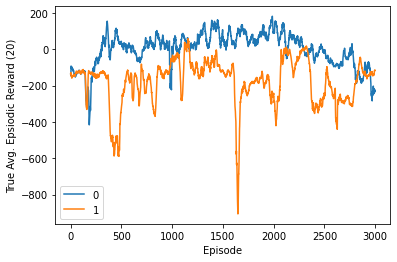

total time: 81658.25318908691 s


In [35]:
run(total_trials=2, total_episodes=3000, buffer_capacity=200000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=10000, continuous=False)

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 4.00 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 3.06 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 2.89 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 2.80 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 3.18 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 2.26 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 3.37 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 2.79 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 2.33 * step 643
Ep 9 

Ep 73 * AvgReward -128.29 * true AvgReward -128.29 * Reward -138.39 * True Reward -138.39 * time 3.45 * step 5187
Ep 74 * AvgReward -127.56 * true AvgReward -127.56 * Reward -119.50 * True Reward -119.50 * time 4.67 * step 5271
Ep 75 * AvgReward -121.49 * true AvgReward -121.49 * Reward -31.14 * True Reward -31.14 * time 4.23 * step 5339
Ep 76 * AvgReward -122.94 * true AvgReward -122.94 * Reward -149.89 * True Reward -149.89 * time 4.16 * step 5406
Ep 77 * AvgReward -123.30 * true AvgReward -123.30 * Reward -140.74 * True Reward -140.74 * time 3.33 * step 5465
Ep 78 * AvgReward -123.87 * true AvgReward -123.87 * Reward -138.59 * True Reward -138.59 * time 2.91 * step 5528
Ep 79 * AvgReward -124.21 * true AvgReward -124.21 * Reward -135.67 * True Reward -135.67 * time 3.42 * step 5606
Ep 80 * AvgReward -117.66 * true AvgReward -117.66 * Reward -15.34 * True Reward -15.34 * time 2.39 * step 5663
Ep 81 * AvgReward -117.93 * true AvgReward -117.93 * Reward -124.36 * True Reward -124.36 * 

Ep 145 * AvgReward -165.26 * true AvgReward -165.26 * Reward -466.76 * True Reward -466.76 * time 2.49 * step 10180
Ep 146 * AvgReward -182.88 * true AvgReward -182.88 * Reward -462.64 * True Reward -462.64 * time 2.46 * step 10237
Ep 147 * AvgReward -196.86 * true AvgReward -196.86 * Reward -407.11 * True Reward -407.11 * time 2.36 * step 10293
Ep 148 * AvgReward -205.64 * true AvgReward -205.64 * Reward -304.73 * True Reward -304.73 * time 2.30 * step 10348
Ep 149 * AvgReward -225.88 * true AvgReward -225.88 * Reward -510.34 * True Reward -510.34 * time 3.60 * step 10419
Ep 150 * AvgReward -238.86 * true AvgReward -238.86 * Reward -413.11 * True Reward -413.11 * time 3.51 * step 10481
Ep 151 * AvgReward -254.94 * true AvgReward -254.94 * Reward -431.55 * True Reward -431.55 * time 3.71 * step 10546
Ep 152 * AvgReward -274.84 * true AvgReward -274.84 * Reward -558.85 * True Reward -558.85 * time 4.28 * step 10621
Ep 153 * AvgReward -299.37 * true AvgReward -299.37 * Reward -620.08 * T

Ep 216 * AvgReward -339.34 * true AvgReward -339.34 * Reward -130.27 * True Reward -130.27 * time 4.86 * step 15393
Ep 217 * AvgReward -305.18 * true AvgReward -305.18 * Reward -108.91 * True Reward -108.91 * time 3.53 * step 15454
Ep 218 * AvgReward -291.34 * true AvgReward -291.34 * Reward -259.61 * True Reward -259.61 * time 3.49 * step 15531
Ep 219 * AvgReward -274.62 * true AvgReward -274.62 * Reward -184.24 * True Reward -184.24 * time 4.64 * step 15633
Ep 220 * AvgReward -247.10 * true AvgReward -247.10 * Reward -157.80 * True Reward -157.80 * time 3.28 * step 15705
Ep 221 * AvgReward -220.53 * true AvgReward -220.53 * Reward -25.24 * True Reward -25.24 * time 5.46 * step 15823
Ep 222 * AvgReward -191.62 * true AvgReward -191.62 * Reward -47.30 * True Reward -47.30 * time 3.86 * step 15898
Ep 223 * AvgReward -199.59 * true AvgReward -199.59 * Reward -435.29 * True Reward -435.29 * time 14.36 * step 16135
Ep 224 * AvgReward -196.87 * true AvgReward -196.87 * Reward -337.01 * True

Ep 287 * AvgReward -280.78 * true AvgReward -280.78 * Reward -317.85 * True Reward -317.85 * time 4.31 * step 24133
Ep 288 * AvgReward -277.56 * true AvgReward -277.56 * Reward -296.26 * True Reward -296.26 * time 4.72 * step 24237
Ep 289 * AvgReward -275.91 * true AvgReward -275.91 * Reward -146.18 * True Reward -146.18 * time 2.93 * step 24304
Ep 290 * AvgReward -280.37 * true AvgReward -280.37 * Reward -284.77 * True Reward -284.77 * time 15.90 * step 24666
Ep 291 * AvgReward -281.72 * true AvgReward -281.72 * Reward -403.01 * True Reward -403.01 * time 14.24 * step 24989
Ep 292 * AvgReward -278.41 * true AvgReward -278.41 * Reward -252.42 * True Reward -252.42 * time 4.38 * step 25088
Ep 293 * AvgReward -281.84 * true AvgReward -281.84 * Reward -293.50 * True Reward -293.50 * time 9.86 * step 25307
Ep 294 * AvgReward -279.94 * true AvgReward -279.94 * Reward -351.88 * True Reward -351.88 * time 5.69 * step 25435
Ep 295 * AvgReward -279.85 * true AvgReward -279.85 * Reward -226.75 *

Ep 358 * AvgReward -203.09 * true AvgReward -203.09 * Reward -254.84 * True Reward -254.84 * time 17.41 * step 34250
Ep 359 * AvgReward -198.49 * true AvgReward -198.49 * Reward -266.11 * True Reward -266.11 * time 7.22 * step 34411
Ep 360 * AvgReward -203.28 * true AvgReward -203.28 * Reward -261.66 * True Reward -261.66 * time 4.82 * step 34520
Ep 361 * AvgReward -202.17 * true AvgReward -202.17 * Reward -166.33 * True Reward -166.33 * time 5.38 * step 34641
Ep 362 * AvgReward -212.30 * true AvgReward -212.30 * Reward -283.52 * True Reward -283.52 * time 6.64 * step 34788
Ep 363 * AvgReward -212.11 * true AvgReward -212.11 * Reward -184.41 * True Reward -184.41 * time 9.03 * step 34989
Ep 364 * AvgReward -213.61 * true AvgReward -213.61 * Reward -349.18 * True Reward -349.18 * time 6.89 * step 35143
Ep 365 * AvgReward -202.31 * true AvgReward -202.31 * Reward -127.55 * True Reward -127.55 * time 4.64 * step 35247
Ep 366 * AvgReward -204.81 * true AvgReward -204.81 * Reward -215.97 * 

Ep 429 * AvgReward -177.73 * true AvgReward -177.73 * Reward -244.45 * True Reward -244.45 * time 6.30 * step 45332
Ep 430 * AvgReward -176.03 * true AvgReward -176.03 * Reward -143.31 * True Reward -143.31 * time 4.29 * step 45424
Ep 431 * AvgReward -176.18 * true AvgReward -176.18 * Reward -149.88 * True Reward -149.88 * time 7.54 * step 45587
Ep 432 * AvgReward -166.84 * true AvgReward -166.84 * Reward 10.43 * True Reward 10.43 * time 8.16 * step 45762
Ep 433 * AvgReward -167.52 * true AvgReward -167.52 * Reward -245.77 * True Reward -245.77 * time 7.78 * step 45928
Ep 434 * AvgReward -168.52 * true AvgReward -168.52 * Reward -160.95 * True Reward -160.95 * time 3.39 * step 46002
Ep 435 * AvgReward -172.35 * true AvgReward -172.35 * Reward -237.11 * True Reward -237.11 * time 6.24 * step 46136
Ep 436 * AvgReward -180.54 * true AvgReward -180.54 * Reward -233.26 * True Reward -233.26 * time 3.23 * step 46209
Ep 437 * AvgReward -177.85 * true AvgReward -177.85 * Reward -183.65 * True 

Ep 500 * AvgReward -238.81 * true AvgReward -238.81 * Reward -250.35 * True Reward -250.35 * time 4.87 * step 56328
Ep 501 * AvgReward -238.32 * true AvgReward -238.32 * Reward -144.40 * True Reward -144.40 * time 3.25 * step 56392
Ep 502 * AvgReward -251.06 * true AvgReward -251.06 * Reward -286.20 * True Reward -286.20 * time 14.21 * step 56688
Ep 503 * AvgReward -252.37 * true AvgReward -252.37 * Reward -210.12 * True Reward -210.12 * time 5.47 * step 56799
Ep 504 * AvgReward -246.05 * true AvgReward -246.05 * Reward -189.70 * True Reward -189.70 * time 6.91 * step 56945
Ep 505 * AvgReward -241.20 * true AvgReward -241.20 * Reward -151.05 * True Reward -151.05 * time 12.71 * step 57218
Ep 506 * AvgReward -239.60 * true AvgReward -239.60 * Reward -227.26 * True Reward -227.26 * time 6.30 * step 57357
Ep 507 * AvgReward -236.63 * true AvgReward -236.63 * Reward -318.98 * True Reward -318.98 * time 17.80 * step 57747
Ep 508 * AvgReward -229.14 * true AvgReward -229.14 * Reward -94.86 *

Ep 571 * AvgReward -257.12 * true AvgReward -257.12 * Reward -367.36 * True Reward -367.36 * time 11.33 * step 68357
Ep 572 * AvgReward -255.79 * true AvgReward -255.79 * Reward -262.66 * True Reward -262.66 * time 9.04 * step 68547
Ep 573 * AvgReward -252.29 * true AvgReward -252.29 * Reward -196.92 * True Reward -196.92 * time 5.75 * step 68667
Ep 574 * AvgReward -243.56 * true AvgReward -243.56 * Reward -222.58 * True Reward -222.58 * time 5.05 * step 68773
Ep 575 * AvgReward -241.91 * true AvgReward -241.91 * Reward -118.76 * True Reward -118.76 * time 7.58 * step 68933
Ep 576 * AvgReward -240.54 * true AvgReward -240.54 * Reward -233.70 * True Reward -233.70 * time 5.08 * step 69035
Ep 577 * AvgReward -239.94 * true AvgReward -239.94 * Reward -264.97 * True Reward -264.97 * time 6.97 * step 69182
Ep 578 * AvgReward -240.31 * true AvgReward -240.31 * Reward -234.61 * True Reward -234.61 * time 9.02 * step 69372
Ep 579 * AvgReward -227.71 * true AvgReward -227.71 * Reward -10.97 * T

Ep 642 * AvgReward -175.13 * true AvgReward -175.13 * Reward -113.30 * True Reward -113.30 * time 7.57 * step 80805
Ep 643 * AvgReward -177.18 * true AvgReward -177.18 * Reward -192.40 * True Reward -192.40 * time 14.67 * step 81120
Ep 644 * AvgReward -181.88 * true AvgReward -181.88 * Reward -200.61 * True Reward -200.61 * time 7.58 * step 81280
Ep 645 * AvgReward -177.12 * true AvgReward -177.12 * Reward -159.66 * True Reward -159.66 * time 4.43 * step 81374
Ep 646 * AvgReward -181.64 * true AvgReward -181.64 * Reward -219.49 * True Reward -219.49 * time 12.03 * step 81627
Ep 647 * AvgReward -178.60 * true AvgReward -178.60 * Reward -165.35 * True Reward -165.35 * time 8.02 * step 81785
Ep 648 * AvgReward -174.64 * true AvgReward -174.64 * Reward -194.61 * True Reward -194.61 * time 8.03 * step 81951
Ep 649 * AvgReward -185.22 * true AvgReward -185.22 * Reward -210.21 * True Reward -210.21 * time 9.16 * step 82142
Ep 650 * AvgReward -192.96 * true AvgReward -192.96 * Reward -266.93 *

Ep 713 * AvgReward -233.45 * true AvgReward -233.45 * Reward -314.83 * True Reward -314.83 * time 5.39 * step 92379
Ep 714 * AvgReward -231.87 * true AvgReward -231.87 * Reward -193.00 * True Reward -193.00 * time 7.78 * step 92537
Ep 715 * AvgReward -235.55 * true AvgReward -235.55 * Reward -234.27 * True Reward -234.27 * time 4.96 * step 92632
Ep 716 * AvgReward -239.04 * true AvgReward -239.04 * Reward -230.89 * True Reward -230.89 * time 3.99 * step 92712
Ep 717 * AvgReward -238.71 * true AvgReward -238.71 * Reward -162.09 * True Reward -162.09 * time 8.86 * step 92888
Ep 718 * AvgReward -240.59 * true AvgReward -240.59 * Reward -172.04 * True Reward -172.04 * time 9.95 * step 93090
Ep 719 * AvgReward -242.53 * true AvgReward -242.53 * Reward -236.51 * True Reward -236.51 * time 4.70 * step 93187
Ep 720 * AvgReward -232.68 * true AvgReward -232.68 * Reward -50.14 * True Reward -50.14 * time 3.46 * step 93259
Ep 721 * AvgReward -233.68 * true AvgReward -233.68 * Reward -269.59 * Tru

Ep 784 * AvgReward -245.49 * true AvgReward -245.49 * Reward -209.31 * True Reward -209.31 * time 6.06 * step 104447
Ep 785 * AvgReward -249.63 * true AvgReward -249.63 * Reward -287.36 * True Reward -287.36 * time 4.67 * step 104545
Ep 786 * AvgReward -245.08 * true AvgReward -245.08 * Reward -221.74 * True Reward -221.74 * time 7.28 * step 104699
Ep 787 * AvgReward -247.66 * true AvgReward -247.66 * Reward -254.29 * True Reward -254.29 * time 8.65 * step 104876
Ep 788 * AvgReward -251.03 * true AvgReward -251.03 * Reward -254.26 * True Reward -254.26 * time 14.13 * step 105164
Ep 789 * AvgReward -251.17 * true AvgReward -251.17 * Reward -197.36 * True Reward -197.36 * time 7.44 * step 105310
Ep 790 * AvgReward -253.17 * true AvgReward -253.17 * Reward -300.92 * True Reward -300.92 * time 7.77 * step 105462
Ep 791 * AvgReward -246.89 * true AvgReward -246.89 * Reward -128.05 * True Reward -128.05 * time 8.66 * step 105633
Ep 792 * AvgReward -255.71 * true AvgReward -255.71 * Reward -3

Ep 855 * AvgReward -204.97 * true AvgReward -204.97 * Reward -189.34 * True Reward -189.34 * time 5.54 * step 114985
Ep 856 * AvgReward -211.68 * true AvgReward -211.68 * Reward -282.71 * True Reward -282.71 * time 5.67 * step 115099
Ep 857 * AvgReward -225.39 * true AvgReward -225.39 * Reward -344.12 * True Reward -344.12 * time 10.99 * step 115318
Ep 858 * AvgReward -223.61 * true AvgReward -223.61 * Reward -236.71 * True Reward -236.71 * time 6.92 * step 115459
Ep 859 * AvgReward -222.82 * true AvgReward -222.82 * Reward -244.59 * True Reward -244.59 * time 5.72 * step 115578
Ep 860 * AvgReward -231.13 * true AvgReward -231.13 * Reward -380.32 * True Reward -380.32 * time 13.26 * step 115848
Ep 861 * AvgReward -230.73 * true AvgReward -230.73 * Reward -196.59 * True Reward -196.59 * time 4.47 * step 115940
Ep 862 * AvgReward -235.99 * true AvgReward -235.99 * Reward -273.44 * True Reward -273.44 * time 12.64 * step 116196
Ep 863 * AvgReward -240.38 * true AvgReward -240.38 * Reward 

Ep 925 * AvgReward -259.24 * true AvgReward -259.24 * Reward -148.11 * True Reward -148.11 * time 6.28 * step 127529
Ep 926 * AvgReward -260.92 * true AvgReward -260.92 * Reward -227.60 * True Reward -227.60 * time 5.81 * step 127649
Ep 927 * AvgReward -253.73 * true AvgReward -253.73 * Reward -346.56 * True Reward -346.56 * time 8.46 * step 127821
Ep 928 * AvgReward -254.25 * true AvgReward -254.25 * Reward -188.18 * True Reward -188.18 * time 11.92 * step 128060
Ep 929 * AvgReward -252.82 * true AvgReward -252.82 * Reward -198.21 * True Reward -198.21 * time 6.84 * step 128198
Ep 930 * AvgReward -254.58 * true AvgReward -254.58 * Reward -247.18 * True Reward -247.18 * time 11.52 * step 128427
Ep 931 * AvgReward -250.22 * true AvgReward -250.22 * Reward -277.17 * True Reward -277.17 * time 4.86 * step 128522
Ep 932 * AvgReward -248.16 * true AvgReward -248.16 * Reward -374.67 * True Reward -374.67 * time 10.79 * step 128730
Ep 933 * AvgReward -242.17 * true AvgReward -242.17 * Reward 

Ep 995 * AvgReward -290.83 * true AvgReward -290.83 * Reward -198.66 * True Reward -198.66 * time 9.04 * step 139985
Ep 996 * AvgReward -300.64 * true AvgReward -300.64 * Reward -421.92 * True Reward -421.92 * time 9.81 * step 140174
Ep 997 * AvgReward -297.23 * true AvgReward -297.23 * Reward -258.15 * True Reward -258.15 * time 9.60 * step 140360
Ep 998 * AvgReward -304.52 * true AvgReward -304.52 * Reward -508.43 * True Reward -508.43 * time 10.26 * step 140567
Ep 999 * AvgReward -300.00 * true AvgReward -300.00 * Reward -306.30 * True Reward -306.30 * time 22.43 * step 141013
Ep 0 * AvgReward -153.85 * true AvgReward -153.85 * Reward -153.85 * True Reward -153.85 * time 3.73 * step 61
Ep 1 * AvgReward -141.99 * true AvgReward -141.99 * Reward -130.14 * True Reward -130.14 * time 3.03 * step 125
Ep 2 * AvgReward -154.69 * true AvgReward -154.69 * Reward -180.08 * True Reward -180.08 * time 3.30 * step 193
Ep 3 * AvgReward -141.62 * true AvgReward -141.62 * Reward -102.40 * True Rewa

Ep 68 * AvgReward -126.47 * true AvgReward -126.47 * Reward -107.77 * True Reward -107.77 * time 4.30 * step 4557
Ep 69 * AvgReward -129.56 * true AvgReward -129.56 * Reward -158.63 * True Reward -158.63 * time 2.84 * step 4615
Ep 70 * AvgReward -121.75 * true AvgReward -121.75 * Reward -2.21 * True Reward -2.21 * time 4.82 * step 4713
Ep 71 * AvgReward -120.40 * true AvgReward -120.40 * Reward -128.69 * True Reward -128.69 * time 3.05 * step 4773
Ep 72 * AvgReward -115.86 * true AvgReward -115.86 * Reward -82.86 * True Reward -82.86 * time 4.24 * step 4863
Ep 73 * AvgReward -116.39 * true AvgReward -116.39 * Reward -110.25 * True Reward -110.25 * time 3.10 * step 4926
Ep 74 * AvgReward -115.30 * true AvgReward -115.30 * Reward -126.08 * True Reward -126.08 * time 3.42 * step 4996
Ep 75 * AvgReward -115.41 * true AvgReward -115.41 * Reward -136.77 * True Reward -136.77 * time 3.41 * step 5067
Ep 76 * AvgReward -109.26 * true AvgReward -109.26 * Reward -1.95 * True Reward -1.95 * time 2

Ep 140 * AvgReward -131.05 * true AvgReward -131.05 * Reward -153.70 * True Reward -153.70 * time 4.35 * step 9783
Ep 141 * AvgReward -127.70 * true AvgReward -127.70 * Reward -91.74 * True Reward -91.74 * time 4.44 * step 9869
Ep 142 * AvgReward -131.88 * true AvgReward -131.88 * Reward -191.46 * True Reward -191.46 * time 4.43 * step 9959
Ep 143 * AvgReward -145.76 * true AvgReward -145.76 * Reward -374.29 * True Reward -374.29 * time 6.81 * step 10094
Ep 144 * AvgReward -158.15 * true AvgReward -158.15 * Reward -342.82 * True Reward -342.82 * time 5.32 * step 10199
Ep 145 * AvgReward -177.95 * true AvgReward -177.95 * Reward -533.54 * True Reward -533.54 * time 5.30 * step 10305
Ep 146 * AvgReward -204.88 * true AvgReward -204.88 * Reward -643.78 * True Reward -643.78 * time 7.86 * step 10461
Ep 147 * AvgReward -232.27 * true AvgReward -232.27 * Reward -685.01 * True Reward -685.01 * time 5.90 * step 10581
Ep 148 * AvgReward -256.98 * true AvgReward -256.98 * Reward -669.93 * True R

Ep 211 * AvgReward -287.20 * true AvgReward -287.20 * Reward -270.61 * True Reward -270.61 * time 10.11 * step 17109
Ep 212 * AvgReward -284.68 * true AvgReward -284.68 * Reward -312.05 * True Reward -312.05 * time 6.57 * step 17237
Ep 213 * AvgReward -292.55 * true AvgReward -292.55 * Reward -527.84 * True Reward -527.84 * time 21.27 * step 17658
Ep 214 * AvgReward -291.24 * true AvgReward -291.24 * Reward -307.77 * True Reward -307.77 * time 7.73 * step 17810
Ep 215 * AvgReward -290.55 * true AvgReward -290.55 * Reward -335.76 * True Reward -335.76 * time 5.89 * step 17928
Ep 216 * AvgReward -283.07 * true AvgReward -283.07 * Reward -176.07 * True Reward -176.07 * time 17.56 * step 18278
Ep 217 * AvgReward -274.70 * true AvgReward -274.70 * Reward -155.26 * True Reward -155.26 * time 11.05 * step 18495
Ep 218 * AvgReward -272.28 * true AvgReward -272.28 * Reward -276.29 * True Reward -276.29 * time 8.14 * step 18660
Ep 219 * AvgReward -272.14 * true AvgReward -272.14 * Reward -352.43

Ep 282 * AvgReward -97.66 * true AvgReward -97.66 * Reward -161.56 * True Reward -161.56 * time 31.03 * step 47548
Ep 283 * AvgReward -93.39 * true AvgReward -93.39 * Reward 45.47 * True Reward 45.47 * time 15.88 * step 47856
Ep 284 * AvgReward -99.95 * true AvgReward -99.95 * Reward -123.93 * True Reward -123.93 * time 9.22 * step 48040
Ep 285 * AvgReward -94.85 * true AvgReward -94.85 * Reward -78.34 * True Reward -78.34 * time 12.06 * step 48279
Ep 286 * AvgReward -97.14 * true AvgReward -97.14 * Reward -161.61 * True Reward -161.61 * time 9.46 * step 48464
Ep 287 * AvgReward -100.33 * true AvgReward -100.33 * Reward -45.08 * True Reward -45.08 * time 9.11 * step 48645
Ep 288 * AvgReward -112.20 * true AvgReward -112.20 * Reward -0.92 * True Reward -0.92 * time 5.58 * step 48756
Ep 289 * AvgReward -115.89 * true AvgReward -115.89 * Reward -155.99 * True Reward -155.99 * time 7.84 * step 48913
Ep 290 * AvgReward -114.11 * true AvgReward -114.11 * Reward -126.43 * True Reward -126.43 

Ep 354 * AvgReward -82.93 * true AvgReward -82.93 * Reward -37.31 * True Reward -37.31 * time 7.74 * step 56539
Ep 355 * AvgReward -78.42 * true AvgReward -78.42 * Reward -15.04 * True Reward -15.04 * time 9.13 * step 56711
Ep 356 * AvgReward -79.85 * true AvgReward -79.85 * Reward -35.20 * True Reward -35.20 * time 9.65 * step 56900
Ep 357 * AvgReward -75.23 * true AvgReward -75.23 * Reward -57.95 * True Reward -57.95 * time 9.54 * step 57085
Ep 358 * AvgReward -76.63 * true AvgReward -76.63 * Reward -86.71 * True Reward -86.71 * time 11.03 * step 57308
Ep 359 * AvgReward -77.65 * true AvgReward -77.65 * Reward -157.31 * True Reward -157.31 * time 7.33 * step 57454
Ep 360 * AvgReward -74.88 * true AvgReward -74.88 * Reward -14.62 * True Reward -14.62 * time 5.39 * step 57562
Ep 361 * AvgReward -69.33 * true AvgReward -69.33 * Reward -39.89 * True Reward -39.89 * time 12.04 * step 57803
Ep 362 * AvgReward -70.30 * true AvgReward -70.30 * Reward -145.60 * True Reward -145.60 * time 12.6

Ep 428 * AvgReward -63.97 * true AvgReward -63.97 * Reward -101.42 * True Reward -101.42 * time 51.54 * step 83972
Ep 429 * AvgReward -70.17 * true AvgReward -70.17 * Reward -45.75 * True Reward -45.75 * time 3.79 * step 84048
Ep 430 * AvgReward -86.81 * true AvgReward -86.81 * Reward -132.21 * True Reward -132.21 * time 15.46 * step 84356
Ep 431 * AvgReward -88.31 * true AvgReward -88.31 * Reward -118.94 * True Reward -118.94 * time 13.34 * step 84620
Ep 432 * AvgReward -90.17 * true AvgReward -90.17 * Reward -124.35 * True Reward -124.35 * time 18.49 * step 84985
Ep 433 * AvgReward -90.75 * true AvgReward -90.75 * Reward -148.49 * True Reward -148.49 * time 35.39 * step 85666
Ep 434 * AvgReward -87.31 * true AvgReward -87.31 * Reward -39.15 * True Reward -39.15 * time 9.85 * step 85856
Ep 435 * AvgReward -89.24 * true AvgReward -89.24 * Reward 125.81 * True Reward 125.81 * time 51.32 * step 86856
Ep 436 * AvgReward -89.51 * true AvgReward -89.51 * Reward 7.14 * True Reward 7.14 * tim

Ep 503 * AvgReward -10.56 * true AvgReward -10.56 * Reward 20.28 * True Reward 20.28 * time 7.76 * step 105840
Ep 504 * AvgReward -15.12 * true AvgReward -15.12 * Reward -75.64 * True Reward -75.64 * time 8.06 * step 105987
Ep 505 * AvgReward -14.54 * true AvgReward -14.54 * Reward -35.93 * True Reward -35.93 * time 5.38 * step 106093
Ep 506 * AvgReward -14.16 * true AvgReward -14.16 * Reward -15.01 * True Reward -15.01 * time 5.45 * step 106201
Ep 507 * AvgReward -7.41 * true AvgReward -7.41 * Reward 155.68 * True Reward 155.68 * time 42.37 * step 107027
Ep 508 * AvgReward -0.65 * true AvgReward -0.65 * Reward 148.10 * True Reward 148.10 * time 44.52 * step 107875
Ep 509 * AvgReward 0.67 * true AvgReward 0.67 * Reward -9.36 * True Reward -9.36 * time 6.65 * step 108005
Ep 510 * AvgReward 3.07 * true AvgReward 3.07 * Reward 38.43 * True Reward 38.43 * time 52.17 * step 109005
Ep 511 * AvgReward -1.92 * true AvgReward -1.92 * Reward -15.32 * True Reward -15.32 * time 7.68 * step 109152


Ep 577 * AvgReward -59.65 * true AvgReward -59.65 * Reward -34.48 * True Reward -34.48 * time 5.18 * step 130718
Ep 578 * AvgReward -59.72 * true AvgReward -59.72 * Reward -7.61 * True Reward -7.61 * time 17.58 * step 131053
Ep 579 * AvgReward -60.88 * true AvgReward -60.88 * Reward -65.00 * True Reward -65.00 * time 8.68 * step 131215
Ep 580 * AvgReward -43.20 * true AvgReward -43.20 * Reward 211.22 * True Reward 211.22 * time 20.82 * step 131607
Ep 581 * AvgReward -45.05 * true AvgReward -45.05 * Reward -27.82 * True Reward -27.82 * time 5.76 * step 131713
Ep 582 * AvgReward -33.37 * true AvgReward -33.37 * Reward 72.92 * True Reward 72.92 * time 53.19 * step 132713
Ep 583 * AvgReward -31.49 * true AvgReward -31.49 * Reward 39.19 * True Reward 39.19 * time 4.68 * step 132804
Ep 584 * AvgReward -33.87 * true AvgReward -33.87 * Reward 60.68 * True Reward 60.68 * time 51.85 * step 133804
Ep 585 * AvgReward -23.64 * true AvgReward -23.64 * Reward 159.40 * True Reward 159.40 * time 50.90 

Ep 650 * AvgReward 0.60 * true AvgReward 0.60 * Reward 0.80 * True Reward 0.80 * time 10.19 * step 159190
Ep 651 * AvgReward 8.03 * true AvgReward 8.03 * Reward 23.71 * True Reward 23.71 * time 7.28 * step 159330
Ep 652 * AvgReward 21.19 * true AvgReward 21.19 * Reward 180.12 * True Reward 180.12 * time 24.92 * step 159787
Ep 653 * AvgReward 20.27 * true AvgReward 20.27 * Reward -26.45 * True Reward -26.45 * time 54.38 * step 160787
Ep 654 * AvgReward 22.46 * true AvgReward 22.46 * Reward -11.70 * True Reward -11.70 * time 13.33 * step 161040
Ep 655 * AvgReward 33.64 * true AvgReward 33.64 * Reward 232.70 * True Reward 232.70 * time 18.45 * step 161388
Ep 656 * AvgReward 29.69 * true AvgReward 29.69 * Reward -144.48 * True Reward -144.48 * time 46.08 * step 162278
Ep 657 * AvgReward 26.20 * true AvgReward 26.20 * Reward -55.78 * True Reward -55.78 * time 8.04 * step 162439
Ep 658 * AvgReward 18.91 * true AvgReward 18.91 * Reward -48.05 * True Reward -48.05 * time 6.52 * step 162564
Ep 

Ep 723 * AvgReward -61.33 * true AvgReward -61.33 * Reward 52.19 * True Reward 52.19 * time 51.49 * step 186345
Ep 724 * AvgReward -50.59 * true AvgReward -50.59 * Reward 74.55 * True Reward 74.55 * time 52.81 * step 187345
Ep 725 * AvgReward -47.94 * true AvgReward -47.94 * Reward 5.42 * True Reward 5.42 * time 10.78 * step 187547
Ep 726 * AvgReward -50.46 * true AvgReward -50.46 * Reward 20.89 * True Reward 20.89 * time 8.30 * step 187706
Ep 727 * AvgReward -35.41 * true AvgReward -35.41 * Reward 264.38 * True Reward 264.38 * time 15.53 * step 187997
Ep 728 * AvgReward -35.79 * true AvgReward -35.79 * Reward -50.56 * True Reward -50.56 * time 24.64 * step 188468
Ep 729 * AvgReward -37.67 * true AvgReward -37.67 * Reward -42.89 * True Reward -42.89 * time 54.48 * step 189468
Ep 730 * AvgReward -22.41 * true AvgReward -22.41 * Reward 140.24 * True Reward 140.24 * time 20.40 * step 189845
Ep 731 * AvgReward -24.46 * true AvgReward -24.46 * Reward -41.60 * True Reward -41.60 * time 7.02 

Ep 796 * AvgReward -33.67 * true AvgReward -33.67 * Reward 9.67 * True Reward 9.67 * time 7.04 * step 216237
Ep 797 * AvgReward -36.89 * true AvgReward -36.89 * Reward 64.49 * True Reward 64.49 * time 54.48 * step 217237
Ep 798 * AvgReward -28.53 * true AvgReward -28.53 * Reward 234.32 * True Reward 234.32 * time 36.23 * step 217910
Ep 799 * AvgReward -25.96 * true AvgReward -25.96 * Reward 58.59 * True Reward 58.59 * time 54.51 * step 218910
Ep 800 * AvgReward -32.25 * true AvgReward -32.25 * Reward -182.08 * True Reward -182.08 * time 47.78 * step 219806
Ep 801 * AvgReward -27.63 * true AvgReward -27.63 * Reward 93.33 * True Reward 93.33 * time 53.56 * step 220806
Ep 802 * AvgReward -26.93 * true AvgReward -26.93 * Reward -23.22 * True Reward -23.22 * time 4.18 * step 220885
Ep 803 * AvgReward -23.18 * true AvgReward -23.18 * Reward -38.50 * True Reward -38.50 * time 13.58 * step 221142
Ep 804 * AvgReward -8.18 * true AvgReward -8.18 * Reward 208.15 * True Reward 208.15 * time 28.77 

Ep 869 * AvgReward -31.49 * true AvgReward -31.49 * Reward -169.69 * True Reward -169.69 * time 19.33 * step 266767
Ep 870 * AvgReward -39.02 * true AvgReward -39.02 * Reward -222.88 * True Reward -222.88 * time 29.75 * step 267316
Ep 871 * AvgReward -45.73 * true AvgReward -45.73 * Reward -223.31 * True Reward -223.31 * time 38.14 * step 268005
Ep 872 * AvgReward -63.69 * true AvgReward -63.69 * Reward -126.71 * True Reward -126.71 * time 53.96 * step 269005
Ep 873 * AvgReward -81.24 * true AvgReward -81.24 * Reward -101.96 * True Reward -101.96 * time 16.12 * step 269289
Ep 874 * AvgReward -80.37 * true AvgReward -80.37 * Reward -100.28 * True Reward -100.28 * time 53.97 * step 270289
Ep 875 * AvgReward -80.70 * true AvgReward -80.70 * Reward -85.17 * True Reward -85.17 * time 54.43 * step 271289
Ep 876 * AvgReward -78.66 * true AvgReward -78.66 * Reward -23.00 * True Reward -23.00 * time 54.60 * step 272289
Ep 877 * AvgReward -76.19 * true AvgReward -76.19 * Reward -57.76 * True Rew

Ep 942 * AvgReward 18.53 * true AvgReward 18.53 * Reward 26.91 * True Reward 26.91 * time 5.44 * step 320100
Ep 943 * AvgReward 23.75 * true AvgReward 23.75 * Reward 17.65 * True Reward 17.65 * time 17.17 * step 320422
Ep 944 * AvgReward 19.28 * true AvgReward 19.28 * Reward -106.63 * True Reward -106.63 * time 34.90 * step 321069
Ep 945 * AvgReward 13.43 * true AvgReward 13.43 * Reward -94.25 * True Reward -94.25 * time 54.48 * step 322069
Ep 946 * AvgReward 3.67 * true AvgReward 3.67 * Reward 14.20 * True Reward 14.20 * time 17.53 * step 322386
Ep 947 * AvgReward -7.37 * true AvgReward -7.37 * Reward -173.78 * True Reward -173.78 * time 53.89 * step 323334
Ep 948 * AvgReward -1.16 * true AvgReward -1.16 * Reward 11.61 * True Reward 11.61 * time 5.36 * step 323433
Ep 949 * AvgReward -0.53 * true AvgReward -0.53 * Reward 25.35 * True Reward 25.35 * time 8.81 * step 323597
Ep 950 * AvgReward -1.85 * true AvgReward -1.85 * Reward -9.93 * True Reward -9.93 * time 7.93 * step 323745
Ep 951

Ep 16 * AvgReward -148.05 * true AvgReward -148.05 * Reward -139.97 * True Reward -139.97 * time 3.58 * step 1274
Ep 17 * AvgReward -145.45 * true AvgReward -145.45 * Reward -101.30 * True Reward -101.30 * time 4.05 * step 1349
Ep 18 * AvgReward -143.12 * true AvgReward -143.12 * Reward -101.09 * True Reward -101.09 * time 3.17 * step 1407
Ep 19 * AvgReward -143.09 * true AvgReward -143.09 * Reward -142.51 * True Reward -142.51 * time 4.22 * step 1485
Ep 20 * AvgReward -146.59 * true AvgReward -146.59 * Reward -100.09 * True Reward -100.09 * time 4.81 * step 1574
Ep 21 * AvgReward -143.33 * true AvgReward -143.33 * Reward -112.43 * True Reward -112.43 * time 2.82 * step 1627
Ep 22 * AvgReward -144.18 * true AvgReward -144.18 * Reward -126.67 * True Reward -126.67 * time 3.22 * step 1683
Ep 23 * AvgReward -143.27 * true AvgReward -143.27 * Reward -149.68 * True Reward -149.68 * time 4.02 * step 1758
Ep 24 * AvgReward -146.41 * true AvgReward -146.41 * Reward -200.14 * True Reward -200.1

Ep 89 * AvgReward -135.34 * true AvgReward -135.34 * Reward -145.83 * True Reward -145.83 * time 3.54 * step 6253
Ep 90 * AvgReward -138.78 * true AvgReward -138.78 * Reward -170.93 * True Reward -170.93 * time 4.74 * step 6342
Ep 91 * AvgReward -135.59 * true AvgReward -135.59 * Reward -98.20 * True Reward -98.20 * time 3.01 * step 6398
Ep 92 * AvgReward -135.39 * true AvgReward -135.39 * Reward -116.40 * True Reward -116.40 * time 2.72 * step 6449
Ep 93 * AvgReward -134.75 * true AvgReward -134.75 * Reward -130.15 * True Reward -130.15 * time 4.19 * step 6522
Ep 94 * AvgReward -135.40 * true AvgReward -135.40 * Reward -144.74 * True Reward -144.74 * time 3.72 * step 6590
Ep 95 * AvgReward -132.10 * true AvgReward -132.10 * Reward -119.07 * True Reward -119.07 * time 3.42 * step 6655
Ep 96 * AvgReward -130.56 * true AvgReward -130.56 * Reward -108.99 * True Reward -108.99 * time 3.20 * step 6717
Ep 97 * AvgReward -128.14 * true AvgReward -128.14 * Reward -118.73 * True Reward -118.73 

Ep 161 * AvgReward -199.86 * true AvgReward -199.86 * Reward -511.02 * True Reward -511.02 * time 4.65 * step 11163
Ep 162 * AvgReward -201.46 * true AvgReward -201.46 * Reward -151.65 * True Reward -151.65 * time 3.85 * step 11224
Ep 163 * AvgReward -201.15 * true AvgReward -201.15 * Reward -133.77 * True Reward -133.77 * time 3.48 * step 11286
Ep 164 * AvgReward -202.52 * true AvgReward -202.52 * Reward -207.06 * True Reward -207.06 * time 5.49 * step 11384
Ep 165 * AvgReward -229.98 * true AvgReward -229.98 * Reward -698.40 * True Reward -698.40 * time 4.96 * step 11472
Ep 166 * AvgReward -230.65 * true AvgReward -230.65 * Reward -436.28 * True Reward -436.28 * time 3.31 * step 11532
Ep 167 * AvgReward -231.59 * true AvgReward -231.59 * Reward -387.10 * True Reward -387.10 * time 3.34 * step 11593
Ep 168 * AvgReward -226.77 * true AvgReward -226.77 * Reward -529.58 * True Reward -529.58 * time 4.14 * step 11668
Ep 169 * AvgReward -241.65 * true AvgReward -241.65 * Reward -414.83 * T

Ep 232 * AvgReward -493.70 * true AvgReward -493.70 * Reward -587.98 * True Reward -587.98 * time 3.71 * step 16197
Ep 233 * AvgReward -508.10 * true AvgReward -508.10 * Reward -665.43 * True Reward -665.43 * time 4.60 * step 16283
Ep 234 * AvgReward -515.13 * true AvgReward -515.13 * Reward -513.04 * True Reward -513.04 * time 3.47 * step 16347
Ep 235 * AvgReward -508.07 * true AvgReward -508.07 * Reward -273.53 * True Reward -273.53 * time 2.79 * step 16398
Ep 236 * AvgReward -491.99 * true AvgReward -491.99 * Reward -453.99 * True Reward -453.99 * time 3.25 * step 16457
Ep 237 * AvgReward -491.60 * true AvgReward -491.60 * Reward -373.39 * True Reward -373.39 * time 2.73 * step 16507
Ep 238 * AvgReward -487.03 * true AvgReward -487.03 * Reward -438.62 * True Reward -438.62 * time 2.96 * step 16561
Ep 239 * AvgReward -481.90 * true AvgReward -481.90 * Reward -483.50 * True Reward -483.50 * time 4.28 * step 16634
Ep 240 * AvgReward -503.95 * true AvgReward -503.95 * Reward -682.99 * T

Ep 303 * AvgReward -530.32 * true AvgReward -530.32 * Reward -529.32 * True Reward -529.32 * time 3.47 * step 21282
Ep 304 * AvgReward -521.91 * true AvgReward -521.91 * Reward -473.49 * True Reward -473.49 * time 3.13 * step 21339
Ep 305 * AvgReward -513.54 * true AvgReward -513.54 * Reward -380.93 * True Reward -380.93 * time 3.35 * step 21400
Ep 306 * AvgReward -502.14 * true AvgReward -502.14 * Reward -585.24 * True Reward -585.24 * time 3.75 * step 21468
Ep 307 * AvgReward -508.12 * true AvgReward -508.12 * Reward -563.28 * True Reward -563.28 * time 4.26 * step 21545
Ep 308 * AvgReward -502.21 * true AvgReward -502.21 * Reward -416.19 * True Reward -416.19 * time 2.91 * step 21598
Ep 309 * AvgReward -482.21 * true AvgReward -482.21 * Reward -323.47 * True Reward -323.47 * time 2.88 * step 21649
Ep 310 * AvgReward -489.10 * true AvgReward -489.10 * Reward -541.87 * True Reward -541.87 * time 4.77 * step 21729
Ep 311 * AvgReward -491.09 * true AvgReward -491.09 * Reward -306.98 * T

Ep 374 * AvgReward -622.41 * true AvgReward -622.41 * Reward -1002.03 * True Reward -1002.03 * time 9.79 * step 27247
Ep 375 * AvgReward -624.71 * true AvgReward -624.71 * Reward -541.85 * True Reward -541.85 * time 5.41 * step 27340
Ep 376 * AvgReward -643.67 * true AvgReward -643.67 * Reward -895.76 * True Reward -895.76 * time 11.28 * step 27491
Ep 377 * AvgReward -652.29 * true AvgReward -652.29 * Reward -499.97 * True Reward -499.97 * time 5.44 * step 27591
Ep 378 * AvgReward -676.98 * true AvgReward -676.98 * Reward -973.98 * True Reward -973.98 * time 10.81 * step 27781
Ep 379 * AvgReward -634.99 * true AvgReward -634.99 * Reward -769.22 * True Reward -769.22 * time 9.07 * step 27940
Ep 380 * AvgReward -637.04 * true AvgReward -637.04 * Reward -518.60 * True Reward -518.60 * time 5.26 * step 28034
Ep 381 * AvgReward -630.42 * true AvgReward -630.42 * Reward -422.70 * True Reward -422.70 * time 5.65 * step 28135
Ep 382 * AvgReward -639.25 * true AvgReward -639.25 * Reward -728.43

Ep 446 * AvgReward -156.51 * true AvgReward -156.51 * Reward -185.36 * True Reward -185.36 * time 6.58 * step 37259
Ep 447 * AvgReward -166.09 * true AvgReward -166.09 * Reward -203.09 * True Reward -203.09 * time 8.16 * step 37403
Ep 448 * AvgReward -168.18 * true AvgReward -168.18 * Reward -134.25 * True Reward -134.25 * time 10.73 * step 37583
Ep 449 * AvgReward -170.23 * true AvgReward -170.23 * Reward -180.45 * True Reward -180.45 * time 12.05 * step 37795
Ep 450 * AvgReward -174.24 * true AvgReward -174.24 * Reward -84.48 * True Reward -84.48 * time 10.36 * step 37974
Ep 451 * AvgReward -168.35 * true AvgReward -168.35 * Reward -81.38 * True Reward -81.38 * time 5.84 * step 38076
Ep 452 * AvgReward -175.45 * true AvgReward -175.45 * Reward -191.64 * True Reward -191.64 * time 9.20 * step 38235
Ep 453 * AvgReward -178.29 * true AvgReward -178.29 * Reward -98.60 * True Reward -98.60 * time 7.02 * step 38357
Ep 454 * AvgReward -182.20 * true AvgReward -182.20 * Reward -172.20 * True

Ep 517 * AvgReward -166.36 * true AvgReward -166.36 * Reward -176.37 * True Reward -176.37 * time 8.15 * step 52835
Ep 518 * AvgReward -164.87 * true AvgReward -164.87 * Reward -172.38 * True Reward -172.38 * time 18.06 * step 53145
Ep 519 * AvgReward -166.48 * true AvgReward -166.48 * Reward -171.61 * True Reward -171.61 * time 11.16 * step 53310
Ep 520 * AvgReward -174.45 * true AvgReward -174.45 * Reward -279.99 * True Reward -279.99 * time 48.57 * step 54151
Ep 521 * AvgReward -176.10 * true AvgReward -176.10 * Reward -198.19 * True Reward -198.19 * time 17.12 * step 54457
Ep 522 * AvgReward -176.07 * true AvgReward -176.07 * Reward -174.80 * True Reward -174.80 * time 13.19 * step 54693
Ep 523 * AvgReward -173.32 * true AvgReward -173.32 * Reward -130.28 * True Reward -130.28 * time 12.76 * step 54919
Ep 524 * AvgReward -174.86 * true AvgReward -174.86 * Reward -197.24 * True Reward -197.24 * time 19.43 * step 55257
Ep 525 * AvgReward -173.78 * true AvgReward -173.78 * Reward -110

Ep 588 * AvgReward -84.22 * true AvgReward -84.22 * Reward 1.65 * True Reward 1.65 * time 13.11 * step 69281
Ep 589 * AvgReward -75.86 * true AvgReward -75.86 * Reward -8.64 * True Reward -8.64 * time 13.38 * step 69511
Ep 590 * AvgReward -75.52 * true AvgReward -75.52 * Reward -57.86 * True Reward -57.86 * time 7.22 * step 69636
Ep 591 * AvgReward -73.50 * true AvgReward -73.50 * Reward -105.75 * True Reward -105.75 * time 7.45 * step 69766
Ep 592 * AvgReward -72.06 * true AvgReward -72.06 * Reward -134.16 * True Reward -134.16 * time 6.57 * step 69879
Ep 593 * AvgReward -68.60 * true AvgReward -68.60 * Reward -85.45 * True Reward -85.45 * time 6.30 * step 69986
Ep 594 * AvgReward -69.98 * true AvgReward -69.98 * Reward -66.35 * True Reward -66.35 * time 8.69 * step 70131
Ep 595 * AvgReward -65.59 * true AvgReward -65.59 * Reward -58.29 * True Reward -58.29 * time 8.66 * step 70282
Ep 596 * AvgReward -65.52 * true AvgReward -65.52 * Reward -151.65 * True Reward -151.65 * time 6.21 * s

Ep 661 * AvgReward -38.29 * true AvgReward -38.29 * Reward -39.19 * True Reward -39.19 * time 8.18 * step 82988
Ep 662 * AvgReward -35.77 * true AvgReward -35.77 * Reward -10.30 * True Reward -10.30 * time 8.53 * step 83137
Ep 663 * AvgReward -32.47 * true AvgReward -32.47 * Reward -49.46 * True Reward -49.46 * time 7.57 * step 83262
Ep 664 * AvgReward -27.23 * true AvgReward -27.23 * Reward 28.27 * True Reward 28.27 * time 11.99 * step 83468
Ep 665 * AvgReward -15.03 * true AvgReward -15.03 * Reward 225.53 * True Reward 225.53 * time 35.60 * step 84069
Ep 666 * AvgReward -14.74 * true AvgReward -14.74 * Reward 11.46 * True Reward 11.46 * time 17.24 * step 84349
Ep 667 * AvgReward -10.53 * true AvgReward -10.53 * Reward -2.97 * True Reward -2.97 * time 13.13 * step 84499
Ep 668 * AvgReward 2.39 * true AvgReward 2.39 * Reward 41.24 * True Reward 41.24 * time 16.60 * step 84752
Ep 669 * AvgReward -9.63 * true AvgReward -9.63 * Reward -238.75 * True Reward -238.75 * time 31.41 * step 8527

Ep 734 * AvgReward -84.63 * true AvgReward -84.63 * Reward -51.39 * True Reward -51.39 * time 22.32 * step 105605
Ep 735 * AvgReward -85.25 * true AvgReward -85.25 * Reward -64.50 * True Reward -64.50 * time 21.04 * step 105956
Ep 736 * AvgReward -81.64 * true AvgReward -81.64 * Reward 3.37 * True Reward 3.37 * time 8.70 * step 106103
Ep 737 * AvgReward -86.35 * true AvgReward -86.35 * Reward -198.40 * True Reward -198.40 * time 28.60 * step 106577
Ep 738 * AvgReward -86.85 * true AvgReward -86.85 * Reward -71.44 * True Reward -71.44 * time 14.10 * step 106820
Ep 739 * AvgReward -86.75 * true AvgReward -86.75 * Reward -29.01 * True Reward -29.01 * time 11.73 * step 107017
Ep 740 * AvgReward -81.94 * true AvgReward -81.94 * Reward -82.58 * True Reward -82.58 * time 8.90 * step 107170
Ep 741 * AvgReward -78.94 * true AvgReward -78.94 * Reward -40.05 * True Reward -40.05 * time 49.71 * step 108011
Ep 742 * AvgReward -76.40 * true AvgReward -76.40 * Reward -35.58 * True Reward -35.58 * tim

Ep 806 * AvgReward -182.97 * true AvgReward -182.97 * Reward -111.17 * True Reward -111.17 * time 20.97 * step 134095
Ep 807 * AvgReward -181.47 * true AvgReward -181.47 * Reward -175.11 * True Reward -175.11 * time 13.93 * step 134326
Ep 808 * AvgReward -177.46 * true AvgReward -177.46 * Reward -130.68 * True Reward -130.68 * time 16.69 * step 134603
Ep 809 * AvgReward -177.69 * true AvgReward -177.69 * Reward -167.61 * True Reward -167.61 * time 16.63 * step 134869
Ep 810 * AvgReward -179.46 * true AvgReward -179.46 * Reward -170.29 * True Reward -170.29 * time 18.41 * step 135182
Ep 811 * AvgReward -178.60 * true AvgReward -178.60 * Reward -185.37 * True Reward -185.37 * time 15.32 * step 135441
Ep 812 * AvgReward -178.76 * true AvgReward -178.76 * Reward -225.91 * True Reward -225.91 * time 14.50 * step 135694
Ep 813 * AvgReward -176.94 * true AvgReward -176.94 * Reward -180.68 * True Reward -180.68 * time 15.77 * step 135965
Ep 814 * AvgReward -172.38 * true AvgReward -172.38 * Re

Ep 876 * AvgReward -126.50 * true AvgReward -126.50 * Reward -0.51 * True Reward -0.51 * time 16.41 * step 157528
Ep 877 * AvgReward -128.82 * true AvgReward -128.82 * Reward -181.57 * True Reward -181.57 * time 34.77 * step 158094
Ep 878 * AvgReward -123.23 * true AvgReward -123.23 * Reward -105.27 * True Reward -105.27 * time 14.06 * step 158326
Ep 879 * AvgReward -117.53 * true AvgReward -117.53 * Reward -100.02 * True Reward -100.02 * time 17.94 * step 158620
Ep 880 * AvgReward -116.66 * true AvgReward -116.66 * Reward -186.95 * True Reward -186.95 * time 20.67 * step 158958
Ep 881 * AvgReward -118.22 * true AvgReward -118.22 * Reward -245.39 * True Reward -245.39 * time 33.67 * step 159511
Ep 882 * AvgReward -108.41 * true AvgReward -108.41 * Reward -3.68 * True Reward -3.68 * time 14.98 * step 159755
Ep 883 * AvgReward -98.44 * true AvgReward -98.44 * Reward -24.92 * True Reward -24.92 * time 15.03 * step 159994
Ep 884 * AvgReward -75.79 * true AvgReward -75.79 * Reward 217.44 * 

Ep 948 * AvgReward -81.86 * true AvgReward -81.86 * Reward 141.77 * True Reward 141.77 * time 60.22 * step 186194
Ep 949 * AvgReward -90.45 * true AvgReward -90.45 * Reward -31.99 * True Reward -31.99 * time 8.22 * step 186333
Ep 950 * AvgReward -88.84 * true AvgReward -88.84 * Reward 35.98 * True Reward 35.98 * time 16.69 * step 186616
Ep 951 * AvgReward -92.50 * true AvgReward -92.50 * Reward -347.79 * True Reward -347.79 * time 14.59 * step 186867
Ep 952 * AvgReward -114.79 * true AvgReward -114.79 * Reward -442.95 * True Reward -442.95 * time 18.38 * step 187177
Ep 953 * AvgReward -120.94 * true AvgReward -120.94 * Reward -67.59 * True Reward -67.59 * time 7.30 * step 187297
Ep 954 * AvgReward -113.66 * true AvgReward -113.66 * Reward -95.92 * True Reward -95.92 * time 10.55 * step 187473
Ep 955 * AvgReward -114.55 * true AvgReward -114.55 * Reward -110.88 * True Reward -110.88 * time 10.39 * step 187651
Ep 956 * AvgReward -121.72 * true AvgReward -121.72 * Reward -145.35 * True Re

Ep 20 * AvgReward -133.43 * true AvgReward -133.43 * Reward -98.11 * True Reward -98.11 * time 5.05 * step 1431
Ep 21 * AvgReward -131.30 * true AvgReward -131.30 * Reward -129.06 * True Reward -129.06 * time 3.55 * step 1494
Ep 22 * AvgReward -130.53 * true AvgReward -130.53 * Reward -122.57 * True Reward -122.57 * time 3.21 * step 1551
Ep 23 * AvgReward -132.19 * true AvgReward -132.19 * Reward -122.12 * True Reward -122.12 * time 2.99 * step 1604
Ep 24 * AvgReward -125.18 * true AvgReward -125.18 * Reward -0.29 * True Reward -0.29 * time 5.18 * step 1697
Ep 25 * AvgReward -123.85 * true AvgReward -123.85 * Reward -110.60 * True Reward -110.60 * time 3.26 * step 1755
Ep 26 * AvgReward -123.22 * true AvgReward -123.22 * Reward -123.96 * True Reward -123.96 * time 4.89 * step 1841
Ep 27 * AvgReward -124.98 * true AvgReward -124.98 * Reward -152.76 * True Reward -152.76 * time 3.91 * step 1911
Ep 28 * AvgReward -126.44 * true AvgReward -126.44 * Reward -152.03 * True Reward -152.03 * ti

Ep 93 * AvgReward -134.75 * true AvgReward -134.75 * Reward -133.91 * True Reward -133.91 * time 3.42 * step 6490
Ep 94 * AvgReward -137.66 * true AvgReward -137.66 * Reward -177.29 * True Reward -177.29 * time 5.05 * step 6576
Ep 95 * AvgReward -132.91 * true AvgReward -132.91 * Reward -97.92 * True Reward -97.92 * time 5.44 * step 6667
Ep 96 * AvgReward -132.30 * true AvgReward -132.30 * Reward -100.93 * True Reward -100.93 * time 3.34 * step 6724
Ep 97 * AvgReward -131.44 * true AvgReward -131.44 * Reward -140.04 * True Reward -140.04 * time 4.15 * step 6795
Ep 98 * AvgReward -131.30 * true AvgReward -131.30 * Reward -95.48 * True Reward -95.48 * time 3.37 * step 6851
Ep 99 * AvgReward -132.33 * true AvgReward -132.33 * Reward -144.86 * True Reward -144.86 * time 4.10 * step 6923
Ep 100 * AvgReward -133.55 * true AvgReward -133.55 * Reward -141.39 * True Reward -141.39 * time 3.82 * step 6985
Ep 101 * AvgReward -135.12 * true AvgReward -135.12 * Reward -131.68 * True Reward -131.68 

Ep 165 * AvgReward -248.34 * true AvgReward -248.34 * Reward -158.38 * True Reward -158.38 * time 3.26 * step 11635
Ep 166 * AvgReward -236.39 * true AvgReward -236.39 * Reward -90.20 * True Reward -90.20 * time 3.34 * step 11692
Ep 167 * AvgReward -217.90 * true AvgReward -217.90 * Reward -156.97 * True Reward -156.97 * time 5.35 * step 11783
Ep 168 * AvgReward -153.29 * true AvgReward -153.29 * Reward -218.85 * True Reward -218.85 * time 5.45 * step 11876
Ep 169 * AvgReward -142.13 * true AvgReward -142.13 * Reward -254.46 * True Reward -254.46 * time 5.12 * step 11962
Ep 170 * AvgReward -145.04 * true AvgReward -145.04 * Reward -171.67 * True Reward -171.67 * time 4.20 * step 12033
Ep 171 * AvgReward -139.33 * true AvgReward -139.33 * Reward -26.52 * True Reward -26.52 * time 6.29 * step 12139
Ep 172 * AvgReward -143.92 * true AvgReward -143.92 * Reward -201.45 * True Reward -201.45 * time 3.12 * step 12190
Ep 173 * AvgReward -143.10 * true AvgReward -143.10 * Reward -116.10 * True 

Ep 236 * AvgReward -495.36 * true AvgReward -495.36 * Reward -654.23 * True Reward -654.23 * time 4.60 * step 17007
Ep 237 * AvgReward -497.39 * true AvgReward -497.39 * Reward -547.69 * True Reward -547.69 * time 4.54 * step 17083
Ep 238 * AvgReward -484.36 * true AvgReward -484.36 * Reward -498.88 * True Reward -498.88 * time 4.60 * step 17162
Ep 239 * AvgReward -484.22 * true AvgReward -484.22 * Reward -533.78 * True Reward -533.78 * time 3.84 * step 17224
Ep 240 * AvgReward -470.09 * true AvgReward -470.09 * Reward -472.17 * True Reward -472.17 * time 3.97 * step 17287
Ep 241 * AvgReward -476.58 * true AvgReward -476.58 * Reward -513.64 * True Reward -513.64 * time 4.59 * step 17360
Ep 242 * AvgReward -463.65 * true AvgReward -463.65 * Reward -361.72 * True Reward -361.72 * time 3.72 * step 17419
Ep 243 * AvgReward -467.29 * true AvgReward -467.29 * Reward -480.23 * True Reward -480.23 * time 4.35 * step 17489
Ep 244 * AvgReward -482.60 * true AvgReward -482.60 * Reward -562.73 * T

Ep 307 * AvgReward -532.00 * true AvgReward -532.00 * Reward -555.62 * True Reward -555.62 * time 4.63 * step 21808
Ep 308 * AvgReward -544.18 * true AvgReward -544.18 * Reward -638.74 * True Reward -638.74 * time 4.75 * step 21886
Ep 309 * AvgReward -539.70 * true AvgReward -539.70 * Reward -394.57 * True Reward -394.57 * time 3.44 * step 21943
Ep 310 * AvgReward -535.88 * true AvgReward -535.88 * Reward -325.30 * True Reward -325.30 * time 3.38 * step 21998
Ep 311 * AvgReward -531.16 * true AvgReward -531.16 * Reward -411.63 * True Reward -411.63 * time 4.13 * step 22054
Ep 312 * AvgReward -519.08 * true AvgReward -519.08 * Reward -451.68 * True Reward -451.68 * time 3.69 * step 22114
Ep 313 * AvgReward -522.95 * true AvgReward -522.95 * Reward -406.83 * True Reward -406.83 * time 3.46 * step 22171
Ep 314 * AvgReward -531.42 * true AvgReward -531.42 * Reward -571.57 * True Reward -571.57 * time 4.19 * step 22242
Ep 315 * AvgReward -521.23 * true AvgReward -521.23 * Reward -494.49 * T

Ep 378 * AvgReward -545.71 * true AvgReward -545.71 * Reward -484.35 * True Reward -484.35 * time 7.86 * step 27313
Ep 379 * AvgReward -542.67 * true AvgReward -542.67 * Reward -436.17 * True Reward -436.17 * time 8.19 * step 27417
Ep 380 * AvgReward -559.15 * true AvgReward -559.15 * Reward -844.68 * True Reward -844.68 * time 11.45 * step 27572
Ep 381 * AvgReward -570.21 * true AvgReward -570.21 * Reward -749.19 * True Reward -749.19 * time 13.31 * step 27708
Ep 382 * AvgReward -587.30 * true AvgReward -587.30 * Reward -903.69 * True Reward -903.69 * time 16.31 * step 27949
Ep 383 * AvgReward -597.04 * true AvgReward -597.04 * Reward -700.25 * True Reward -700.25 * time 7.83 * step 28079
Ep 384 * AvgReward -594.46 * true AvgReward -594.46 * Reward -455.25 * True Reward -455.25 * time 6.15 * step 28179
Ep 385 * AvgReward -602.92 * true AvgReward -602.92 * Reward -649.62 * True Reward -649.62 * time 8.28 * step 28307
Ep 386 * AvgReward -606.37 * true AvgReward -606.37 * Reward -657.24 

Ep 449 * AvgReward -149.08 * true AvgReward -149.08 * Reward -129.61 * True Reward -129.61 * time 5.53 * step 33588
Ep 450 * AvgReward -143.24 * true AvgReward -143.24 * Reward -154.70 * True Reward -154.70 * time 4.57 * step 33650
Ep 451 * AvgReward -142.19 * true AvgReward -142.19 * Reward -158.78 * True Reward -158.78 * time 4.03 * step 33716
Ep 452 * AvgReward -139.63 * true AvgReward -139.63 * Reward -110.50 * True Reward -110.50 * time 3.25 * step 33770
Ep 453 * AvgReward -138.62 * true AvgReward -138.62 * Reward -134.64 * True Reward -134.64 * time 5.62 * step 33862
Ep 454 * AvgReward -136.60 * true AvgReward -136.60 * Reward -72.56 * True Reward -72.56 * time 4.83 * step 33942
Ep 455 * AvgReward -142.80 * true AvgReward -142.80 * Reward -243.55 * True Reward -243.55 * time 4.80 * step 34021
Ep 456 * AvgReward -143.96 * true AvgReward -143.96 * Reward -159.78 * True Reward -159.78 * time 4.34 * step 34093
Ep 457 * AvgReward -149.08 * true AvgReward -149.08 * Reward -125.68 * Tru

Ep 520 * AvgReward -220.54 * true AvgReward -220.54 * Reward -196.78 * True Reward -196.78 * time 5.27 * step 38959
Ep 521 * AvgReward -206.32 * true AvgReward -206.32 * Reward -105.88 * True Reward -105.88 * time 3.53 * step 39014
Ep 522 * AvgReward -197.44 * true AvgReward -197.44 * Reward -4.15 * True Reward -4.15 * time 6.09 * step 39113
Ep 523 * AvgReward -192.31 * true AvgReward -192.31 * Reward -196.98 * True Reward -196.98 * time 4.68 * step 39191
Ep 524 * AvgReward -172.28 * true AvgReward -172.28 * Reward 24.70 * True Reward 24.70 * time 3.84 * step 39254
Ep 525 * AvgReward -165.24 * true AvgReward -165.24 * Reward -77.28 * True Reward -77.28 * time 4.78 * step 39333
Ep 526 * AvgReward -165.52 * true AvgReward -165.52 * Reward -207.07 * True Reward -207.07 * time 4.69 * step 39409
Ep 527 * AvgReward -164.16 * true AvgReward -164.16 * Reward -193.21 * True Reward -193.21 * time 6.07 * step 39508
Ep 528 * AvgReward -162.73 * true AvgReward -162.73 * Reward -177.01 * True Reward

Ep 591 * AvgReward -135.37 * true AvgReward -135.37 * Reward -122.65 * True Reward -122.65 * time 3.89 * step 44181
Ep 592 * AvgReward -135.39 * true AvgReward -135.39 * Reward -146.82 * True Reward -146.82 * time 4.81 * step 44260
Ep 593 * AvgReward -135.14 * true AvgReward -135.14 * Reward -142.66 * True Reward -142.66 * time 5.70 * step 44354
Ep 594 * AvgReward -135.66 * true AvgReward -135.66 * Reward -134.39 * True Reward -134.39 * time 4.77 * step 44432
Ep 595 * AvgReward -135.16 * true AvgReward -135.16 * Reward -127.00 * True Reward -127.00 * time 4.15 * step 44502
Ep 596 * AvgReward -137.11 * true AvgReward -137.11 * Reward -164.66 * True Reward -164.66 * time 5.06 * step 44586
Ep 597 * AvgReward -134.83 * true AvgReward -134.83 * Reward -85.38 * True Reward -85.38 * time 3.37 * step 44642
Ep 598 * AvgReward -133.01 * true AvgReward -133.01 * Reward -125.25 * True Reward -125.25 * time 4.12 * step 44709
Ep 599 * AvgReward -131.41 * true AvgReward -131.41 * Reward -125.40 * Tru

Ep 662 * AvgReward -178.95 * true AvgReward -178.95 * Reward -274.08 * True Reward -274.08 * time 8.64 * step 50249
Ep 663 * AvgReward -180.59 * true AvgReward -180.59 * Reward -197.31 * True Reward -197.31 * time 9.02 * step 50396
Ep 664 * AvgReward -187.33 * true AvgReward -187.33 * Reward -263.76 * True Reward -263.76 * time 9.18 * step 50544
Ep 665 * AvgReward -193.62 * true AvgReward -193.62 * Reward -266.69 * True Reward -266.69 * time 7.61 * step 50669
Ep 666 * AvgReward -200.74 * true AvgReward -200.74 * Reward -293.92 * True Reward -293.92 * time 8.83 * step 50816
Ep 667 * AvgReward -214.02 * true AvgReward -214.02 * Reward -413.82 * True Reward -413.82 * time 6.89 * step 50932
Ep 668 * AvgReward -229.20 * true AvgReward -229.20 * Reward -354.67 * True Reward -354.67 * time 7.40 * step 51060
Ep 669 * AvgReward -239.68 * true AvgReward -239.68 * Reward -305.11 * True Reward -305.11 * time 5.56 * step 51155
Ep 670 * AvgReward -254.90 * true AvgReward -254.90 * Reward -431.73 * T

Ep 733 * AvgReward -250.79 * true AvgReward -250.79 * Reward -278.57 * True Reward -278.57 * time 6.78 * step 60079
Ep 734 * AvgReward -252.44 * true AvgReward -252.44 * Reward -276.86 * True Reward -276.86 * time 6.50 * step 60182
Ep 735 * AvgReward -255.15 * true AvgReward -255.15 * Reward -282.39 * True Reward -282.39 * time 11.49 * step 60366
Ep 736 * AvgReward -256.40 * true AvgReward -256.40 * Reward -310.56 * True Reward -310.56 * time 5.67 * step 60455
Ep 737 * AvgReward -261.67 * true AvgReward -261.67 * Reward -431.19 * True Reward -431.19 * time 11.31 * step 60632
Ep 738 * AvgReward -272.33 * true AvgReward -272.33 * Reward -339.72 * True Reward -339.72 * time 19.01 * step 60934
Ep 739 * AvgReward -268.40 * true AvgReward -268.40 * Reward -176.76 * True Reward -176.76 * time 14.77 * step 61173
Ep 740 * AvgReward -265.32 * true AvgReward -265.32 * Reward -244.72 * True Reward -244.72 * time 8.55 * step 61308
Ep 741 * AvgReward -261.81 * true AvgReward -261.81 * Reward -171.06

Ep 804 * AvgReward -246.22 * true AvgReward -246.22 * Reward -165.24 * True Reward -165.24 * time 16.33 * step 76148
Ep 805 * AvgReward -247.66 * true AvgReward -247.66 * Reward -247.29 * True Reward -247.29 * time 14.55 * step 76383
Ep 806 * AvgReward -248.91 * true AvgReward -248.91 * Reward -261.13 * True Reward -261.13 * time 28.18 * step 76839
Ep 807 * AvgReward -258.33 * true AvgReward -258.33 * Reward -261.82 * True Reward -261.82 * time 16.50 * step 77096
Ep 808 * AvgReward -264.82 * true AvgReward -264.82 * Reward -261.10 * True Reward -261.10 * time 10.00 * step 77252
Ep 809 * AvgReward -272.77 * true AvgReward -272.77 * Reward -312.57 * True Reward -312.57 * time 16.09 * step 77497
Ep 810 * AvgReward -270.06 * true AvgReward -270.06 * Reward -177.57 * True Reward -177.57 * time 13.97 * step 77716
Ep 811 * AvgReward -272.75 * true AvgReward -272.75 * Reward -256.11 * True Reward -256.11 * time 19.09 * step 78011
Ep 812 * AvgReward -275.24 * true AvgReward -275.24 * Reward -28

Ep 876 * AvgReward -118.13 * true AvgReward -118.13 * Reward -72.99 * True Reward -72.99 * time 11.83 * step 93732
Ep 877 * AvgReward -116.73 * true AvgReward -116.73 * Reward -35.26 * True Reward -35.26 * time 6.40 * step 93832
Ep 878 * AvgReward -110.10 * true AvgReward -110.10 * Reward -63.92 * True Reward -63.92 * time 17.38 * step 94095
Ep 879 * AvgReward -106.70 * true AvgReward -106.70 * Reward -23.39 * True Reward -23.39 * time 17.71 * step 94367
Ep 880 * AvgReward -103.42 * true AvgReward -103.42 * Reward -152.28 * True Reward -152.28 * time 19.67 * step 94673
Ep 881 * AvgReward -102.88 * true AvgReward -102.88 * Reward -150.69 * True Reward -150.69 * time 18.08 * step 94959
Ep 882 * AvgReward -100.58 * true AvgReward -100.58 * Reward -101.68 * True Reward -101.68 * time 13.82 * step 95176
Ep 883 * AvgReward -97.26 * true AvgReward -97.26 * Reward -58.83 * True Reward -58.83 * time 6.45 * step 95277
Ep 884 * AvgReward -95.93 * true AvgReward -95.93 * Reward -66.61 * True Rewar

Ep 948 * AvgReward -67.09 * true AvgReward -67.09 * Reward -132.21 * True Reward -132.21 * time 18.79 * step 111361
Ep 949 * AvgReward -72.17 * true AvgReward -72.17 * Reward -129.77 * True Reward -129.77 * time 14.90 * step 111585
Ep 950 * AvgReward -70.79 * true AvgReward -70.79 * Reward -95.56 * True Reward -95.56 * time 15.41 * step 111818
Ep 951 * AvgReward -75.34 * true AvgReward -75.34 * Reward -106.62 * True Reward -106.62 * time 16.84 * step 112075
Ep 952 * AvgReward -76.28 * true AvgReward -76.28 * Reward -47.09 * True Reward -47.09 * time 18.22 * step 112352
Ep 953 * AvgReward -75.11 * true AvgReward -75.11 * Reward -38.53 * True Reward -38.53 * time 12.07 * step 112535
Ep 954 * AvgReward -75.62 * true AvgReward -75.62 * Reward -93.31 * True Reward -93.31 * time 13.92 * step 112745
Ep 955 * AvgReward -75.90 * true AvgReward -75.90 * Reward -72.02 * True Reward -72.02 * time 14.23 * step 112959
Ep 956 * AvgReward -71.60 * true AvgReward -71.60 * Reward 12.97 * True Reward 12.

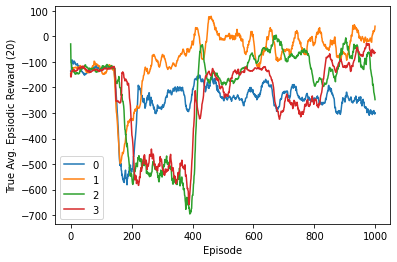

total time: 44333.59647035599 s


In [36]:
run(total_trials=4, total_episodes=1000, buffer_capacity=200000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=10000, continuous=False)

In [ ]:
run(total_trials=4, total_episodes=600, buffer_capacity=200000, tau=0.001, critic_lr=0.0002, 
    actor_lr=0.0001, start_steps=1000, continuous=False)

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 5.67 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 4.58 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 4.06 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 4.10 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 4.47 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 3.25 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 4.96 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 4.16 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 3.41 * step 643
Ep 9 

Ep 73 * AvgReward -372.52 * true AvgReward -372.52 * Reward -241.50 * True Reward -241.50 * time 4.20 * step 5122
Ep 74 * AvgReward -370.18 * true AvgReward -370.18 * Reward -275.32 * True Reward -275.32 * time 3.51 * step 5177
Ep 75 * AvgReward -363.29 * true AvgReward -363.29 * Reward -243.08 * True Reward -243.08 * time 4.47 * step 5247
Ep 76 * AvgReward -347.54 * true AvgReward -347.54 * Reward -197.43 * True Reward -197.43 * time 3.35 * step 5300
Ep 77 * AvgReward -347.95 * true AvgReward -347.95 * Reward -545.65 * True Reward -545.65 * time 5.82 * step 5392
Ep 78 * AvgReward -340.56 * true AvgReward -340.56 * Reward -331.12 * True Reward -331.12 * time 4.43 * step 5462
Ep 79 * AvgReward -332.19 * true AvgReward -332.19 * Reward -386.19 * True Reward -386.19 * time 7.67 * step 5581
Ep 80 * AvgReward -341.27 * true AvgReward -341.27 * Reward -335.27 * True Reward -335.27 * time 5.07 * step 5654
Ep 81 * AvgReward -343.33 * true AvgReward -343.33 * Reward -479.17 * True Reward -479.1

Ep 145 * AvgReward -236.85 * true AvgReward -236.85 * Reward -218.55 * True Reward -218.55 * time 10.50 * step 15688
Ep 146 * AvgReward -238.62 * true AvgReward -238.62 * Reward -195.10 * True Reward -195.10 * time 10.22 * step 15845
Ep 147 * AvgReward -236.50 * true AvgReward -236.50 * Reward -197.37 * True Reward -197.37 * time 12.09 * step 16029
Ep 148 * AvgReward -230.87 * true AvgReward -230.87 * Reward -170.56 * True Reward -170.56 * time 13.05 * step 16227
Ep 149 * AvgReward -229.79 * true AvgReward -229.79 * Reward -168.09 * True Reward -168.09 * time 10.66 * step 16391
Ep 150 * AvgReward -223.43 * true AvgReward -223.43 * Reward -135.93 * True Reward -135.93 * time 13.82 * step 16597
Ep 151 * AvgReward -222.45 * true AvgReward -222.45 * Reward -237.39 * True Reward -237.39 * time 30.63 * step 17068
Ep 152 * AvgReward -222.96 * true AvgReward -222.96 * Reward -221.19 * True Reward -221.19 * time 20.29 * step 17377
Ep 153 * AvgReward -217.85 * true AvgReward -217.85 * Reward -19

Ep 216 * AvgReward -172.73 * true AvgReward -172.73 * Reward -203.94 * True Reward -203.94 * time 12.43 * step 38250
Ep 217 * AvgReward -175.92 * true AvgReward -175.92 * Reward -225.67 * True Reward -225.67 * time 6.73 * step 38350
Ep 218 * AvgReward -176.02 * true AvgReward -176.02 * Reward -201.59 * True Reward -201.59 * time 12.89 * step 38539
Ep 219 * AvgReward -170.48 * true AvgReward -170.48 * Reward -161.34 * True Reward -161.34 * time 6.32 * step 38632
Ep 220 * AvgReward -169.62 * true AvgReward -169.62 * Reward -181.85 * True Reward -181.85 * time 14.81 * step 38850
Ep 221 * AvgReward -170.13 * true AvgReward -170.13 * Reward -131.93 * True Reward -131.93 * time 9.08 * step 38984
Ep 222 * AvgReward -166.25 * true AvgReward -166.25 * Reward -65.90 * True Reward -65.90 * time 8.77 * step 39115
Ep 223 * AvgReward -167.65 * true AvgReward -167.65 * Reward -195.54 * True Reward -195.54 * time 27.44 * step 39521
Ep 224 * AvgReward -170.57 * true AvgReward -170.57 * Reward -194.58 *

Ep 287 * AvgReward -133.57 * true AvgReward -133.57 * Reward -150.70 * True Reward -150.70 * time 9.66 * step 65478
Ep 288 * AvgReward -140.72 * true AvgReward -140.72 * Reward -208.38 * True Reward -208.38 * time 15.26 * step 65701
Ep 289 * AvgReward -143.01 * true AvgReward -143.01 * Reward -223.25 * True Reward -223.25 * time 14.56 * step 65918
Ep 290 * AvgReward -158.58 * true AvgReward -158.58 * Reward -200.38 * True Reward -200.38 * time 15.41 * step 66145
Ep 291 * AvgReward -165.80 * true AvgReward -165.80 * Reward -180.40 * True Reward -180.40 * time 14.06 * step 66352
Ep 292 * AvgReward -163.29 * true AvgReward -163.29 * Reward -185.27 * True Reward -185.27 * time 19.52 * step 66646
Ep 293 * AvgReward -160.67 * true AvgReward -160.67 * Reward -82.50 * True Reward -82.50 * time 32.19 * step 67129
Ep 294 * AvgReward -161.29 * true AvgReward -161.29 * Reward -135.32 * True Reward -135.32 * time 69.77 * step 68129
Ep 295 * AvgReward -160.41 * true AvgReward -160.41 * Reward -165.5

Ep 358 * AvgReward -69.18 * true AvgReward -69.18 * Reward -131.76 * True Reward -131.76 * time 20.14 * step 92163
Ep 359 * AvgReward -86.73 * true AvgReward -86.73 * Reward -129.54 * True Reward -129.54 * time 21.56 * step 92477
Ep 360 * AvgReward -67.18 * true AvgReward -67.18 * Reward 239.75 * True Reward 239.75 * time 41.90 * step 93092
Ep 361 * AvgReward -62.70 * true AvgReward -62.70 * Reward -63.37 * True Reward -63.37 * time 25.37 * step 93453
Ep 362 * AvgReward -52.84 * true AvgReward -52.84 * Reward 42.49 * True Reward 42.49 * time 69.82 * step 94453
Ep 363 * AvgReward -47.28 * true AvgReward -47.28 * Reward -55.29 * True Reward -55.29 * time 26.26 * step 94829
Ep 364 * AvgReward -51.46 * true AvgReward -51.46 * Reward -198.13 * True Reward -198.13 * time 27.13 * step 95155
Ep 365 * AvgReward -49.05 * true AvgReward -49.05 * Reward -73.00 * True Reward -73.00 * time 38.55 * step 95694
Ep 366 * AvgReward -47.67 * true AvgReward -47.67 * Reward -111.56 * True Reward -111.56 * t

Ep 430 * AvgReward -156.81 * true AvgReward -156.81 * Reward -47.16 * True Reward -47.16 * time 20.28 * step 128731
Ep 431 * AvgReward -155.06 * true AvgReward -155.06 * Reward -142.98 * True Reward -142.98 * time 11.93 * step 128904
Ep 432 * AvgReward -134.99 * true AvgReward -134.99 * Reward 223.62 * True Reward 223.62 * time 53.14 * step 129629
Ep 433 * AvgReward -132.07 * true AvgReward -132.07 * Reward -191.87 * True Reward -191.87 * time 41.63 * step 130217
Ep 434 * AvgReward -109.69 * true AvgReward -109.69 * Reward 262.55 * True Reward 262.55 * time 27.47 * step 130605
Ep 435 * AvgReward -102.84 * true AvgReward -102.84 * Reward -33.79 * True Reward -33.79 * time 13.88 * step 130805
Ep 436 * AvgReward -90.55 * true AvgReward -90.55 * Reward 157.34 * True Reward 157.34 * time 32.51 * step 131269
Ep 437 * AvgReward -83.41 * true AvgReward -83.41 * Reward -29.54 * True Reward -29.54 * time 69.84 * step 132269
Ep 438 * AvgReward -62.99 * true AvgReward -62.99 * Reward 182.69 * True

Ep 502 * AvgReward -61.00 * true AvgReward -61.00 * Reward -135.10 * True Reward -135.10 * time 19.45 * step 159887
Ep 503 * AvgReward -41.42 * true AvgReward -41.42 * Reward 176.57 * True Reward 176.57 * time 58.45 * step 160688
Ep 504 * AvgReward -45.56 * true AvgReward -45.56 * Reward -167.22 * True Reward -167.22 * time 42.21 * step 161287
Ep 505 * AvgReward -33.31 * true AvgReward -33.31 * Reward 84.46 * True Reward 84.46 * time 70.36 * step 162287
Ep 506 * AvgReward -20.49 * true AvgReward -20.49 * Reward 84.26 * True Reward 84.26 * time 70.14 * step 163287
Ep 507 * AvgReward -34.85 * true AvgReward -34.85 * Reward -306.86 * True Reward -306.86 * time 14.55 * step 163482
Ep 508 * AvgReward -22.43 * true AvgReward -22.43 * Reward 88.89 * True Reward 88.89 * time 71.06 * step 164482
Ep 509 * AvgReward -18.93 * true AvgReward -18.93 * Reward -30.52 * True Reward -30.52 * time 10.66 * step 164632
Ep 510 * AvgReward -51.13 * true AvgReward -51.13 * Reward -745.50 * True Reward -745.50

Ep 575 * AvgReward 102.08 * true AvgReward 102.08 * Reward -5.23 * True Reward -5.23 * time 19.02 * step 203849
Ep 576 * AvgReward 119.42 * true AvgReward 119.42 * Reward 270.31 * True Reward 270.31 * time 42.28 * step 204457
Ep 577 * AvgReward 96.80 * true AvgReward 96.80 * Reward -173.99 * True Reward -173.99 * time 28.89 * step 204878
Ep 578 * AvgReward 92.31 * true AvgReward 92.31 * Reward 31.75 * True Reward 31.75 * time 16.06 * step 205101
Ep 579 * AvgReward 85.32 * true AvgReward 85.32 * Reward 68.53 * True Reward 68.53 * time 71.74 * step 206101
Ep 580 * AvgReward 88.90 * true AvgReward 88.90 * Reward 122.10 * True Reward 122.10 * time 70.61 * step 207101
Ep 581 * AvgReward 86.31 * true AvgReward 86.31 * Reward 51.77 * True Reward 51.77 * time 72.41 * step 208101
Ep 582 * AvgReward 79.30 * true AvgReward 79.30 * Reward 117.51 * True Reward 117.51 * time 73.04 * step 209101
Ep 583 * AvgReward 75.86 * true AvgReward 75.86 * Reward -54.89 * True Reward -54.89 * time 29.80 * step 2

Ep 48 * AvgReward -311.92 * true AvgReward -311.92 * Reward -156.34 * True Reward -156.34 * time 5.33 * step 3320
Ep 49 * AvgReward -296.84 * true AvgReward -296.84 * Reward -192.37 * True Reward -192.37 * time 6.02 * step 3405
Ep 50 * AvgReward -282.44 * true AvgReward -282.44 * Reward -128.40 * True Reward -128.40 * time 4.28 * step 3466
Ep 51 * AvgReward -273.46 * true AvgReward -273.46 * Reward -135.75 * True Reward -135.75 * time 6.44 * step 3561
Ep 52 * AvgReward -265.54 * true AvgReward -265.54 * Reward -161.98 * True Reward -161.98 * time 5.06 * step 3635
Ep 53 * AvgReward -259.00 * true AvgReward -259.00 * Reward -172.53 * True Reward -172.53 * time 5.58 * step 3717
Ep 54 * AvgReward -236.82 * true AvgReward -236.82 * Reward -71.02 * True Reward -71.02 * time 4.92 * step 3789
Ep 55 * AvgReward -218.88 * true AvgReward -218.88 * Reward -143.20 * True Reward -143.20 * time 4.36 * step 3854
Ep 56 * AvgReward -186.37 * true AvgReward -186.37 * Reward -143.96 * True Reward -143.96 

Ep 120 * AvgReward -134.19 * true AvgReward -134.19 * Reward -141.20 * True Reward -141.20 * time 5.86 * step 8607
Ep 121 * AvgReward -131.56 * true AvgReward -131.56 * Reward -103.80 * True Reward -103.80 * time 4.33 * step 8671
Ep 122 * AvgReward -131.36 * true AvgReward -131.36 * Reward -120.38 * True Reward -120.38 * time 5.15 * step 8748
Ep 123 * AvgReward -130.35 * true AvgReward -130.35 * Reward -124.53 * True Reward -124.53 * time 4.13 * step 8809
Ep 124 * AvgReward -130.71 * true AvgReward -130.71 * Reward -151.25 * True Reward -151.25 * time 4.16 * step 8870
Ep 125 * AvgReward -130.72 * true AvgReward -130.72 * Reward -122.86 * True Reward -122.86 * time 4.40 * step 8936
Ep 126 * AvgReward -130.10 * true AvgReward -130.10 * Reward -98.05 * True Reward -98.05 * time 4.66 * step 9003
Ep 127 * AvgReward -131.13 * true AvgReward -131.13 * Reward -109.96 * True Reward -109.96 * time 4.30 * step 9066
Ep 128 * AvgReward -136.42 * true AvgReward -136.42 * Reward -216.37 * True Reward

Ep 191 * AvgReward -242.20 * true AvgReward -242.20 * Reward -500.60 * True Reward -500.60 * time 7.87 * step 13998
Ep 192 * AvgReward -261.60 * true AvgReward -261.60 * Reward -490.59 * True Reward -490.59 * time 6.27 * step 14087
Ep 193 * AvgReward -283.85 * true AvgReward -283.85 * Reward -587.13 * True Reward -587.13 * time 8.67 * step 14213
Ep 194 * AvgReward -298.22 * true AvgReward -298.22 * Reward -408.69 * True Reward -408.69 * time 5.62 * step 14292
Ep 195 * AvgReward -338.81 * true AvgReward -338.81 * Reward -939.37 * True Reward -939.37 * time 14.35 * step 14499
Ep 196 * AvgReward -358.72 * true AvgReward -358.72 * Reward -504.31 * True Reward -504.31 * time 7.62 * step 14611
Ep 197 * AvgReward -381.04 * true AvgReward -381.04 * Reward -605.28 * True Reward -605.28 * time 5.63 * step 14692
Ep 198 * AvgReward -394.74 * true AvgReward -394.74 * Reward -408.89 * True Reward -408.89 * time 5.51 * step 14772
Ep 199 * AvgReward -422.52 * true AvgReward -422.52 * Reward -674.13 * 

Ep 262 * AvgReward -105.84 * true AvgReward -105.84 * Reward -49.06 * True Reward -49.06 * time 5.85 * step 30689
Ep 263 * AvgReward -107.49 * true AvgReward -107.49 * Reward -157.32 * True Reward -157.32 * time 13.05 * step 30880
Ep 264 * AvgReward -99.82 * true AvgReward -99.82 * Reward 4.65 * True Reward 4.65 * time 8.81 * step 31007
Ep 265 * AvgReward -104.06 * true AvgReward -104.06 * Reward -221.84 * True Reward -221.84 * time 61.69 * step 31838
Ep 266 * AvgReward -106.35 * true AvgReward -106.35 * Reward -159.75 * True Reward -159.75 * time 13.66 * step 32034
Ep 267 * AvgReward -98.56 * true AvgReward -98.56 * Reward -12.06 * True Reward -12.06 * time 6.47 * step 32115
